In [1]:
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
# import plotly.graph_objs as go
# import plotly.express as px
# from plotly.subplots import make_subplots
import numpy as np
import seaborn as sns
import scanpy as sc
import gseapy
from datetime import datetime
from lifelines.utils import restricted_mean_survival_time
from lifelines.statistics import logrank_test,multivariate_logrank_test
from lifelines import KaplanMeierFitter
import lifelines 
import statsmodels
from scipy.stats import rankdata
import math
from sklearn.preprocessing import scale
from sklearn import preprocessing


from combat.pycombat import pycombat
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from mycolorpy import colorlist as mcp
import warnings
warnings.filterwarnings("ignore")



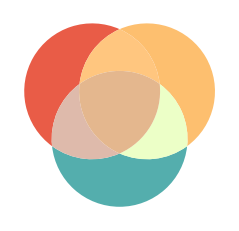

In [67]:
from matplotlib_venn import venn2, venn3
cmap = mcp.gen_color(cmap="Spectral",n=7)
c1 = cmap[1]
c2 = cmap[2]
c3 = cmap[5]
common = 1

a = list(range(common)) +['A']*2
b = list(range(common)) +['B']*2
c = list(range(common)) +['C']*2

out=venn3([set(a), set(b), set(c)], set_labels=(None,None,None), 
          set_colors=(c1,c2,c3),alpha=1)
for text in out.subset_labels:
    text.remove()
plt.show()

In [54]:
text.remove

[Text(-0.4118258634585446, 0.23776777312704078, '1'),
 Text(0.4118258634585446, 0.23776777312704078, '1'),
 Text(1.697636051641271e-17, 0.3437955325317239, '0'),
 Text(-1.0498336619268805e-16, -0.4755355462540817, '1'),
 Text(-0.29773566488007236, -0.171897766265862, '0'),
 Text(0.2977356648800723, -0.17189776626586198, '0'),
 Text(-8.971203230297362e-18, -2.653036043455914e-17, '2')]

In [53]:
out.get_label_by_id('100')

Text(-0.4118258634585446, 0.23776777312704078, '1')

In [49]:
out.hide_zeroes
out.get_label_by_id('100').set_text('')

<bound method VennDiagram.hide_zeroes of <matplotlib_venn._common.VennDiagram object at 0x7fc261155220>>

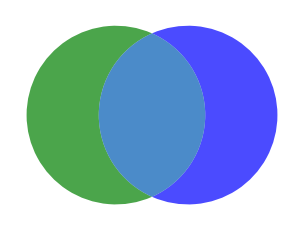

In [28]:
from matplotlib_venn import venn2_unweighted, venn3_unweighted


out = venn2_unweighted(subsets = ('', '', ''), set_colors=("green","blue"),alpha=0.7, set_labels=(None,None))
for text in out.subset_labels:
    text.set_fontsize(16)
plt.show()




# out = venn2_unweighted(subsets = ('', '', ''), set_colors=("green","blue"),alpha=0.7, set_labels=(None,None))
# for text in out.subset_labels:
#     text.set_fontsize(16)
# plt.show()

In [ ]:
from matplotlib_venn import venn2_unweighted


out = venn2_unweighted(subsets = ('', '', ''), set_colors=("green","blue"),alpha=0.7, set_labels=(None,None))
for text in out.subset_labels:
    text.set_fontsize(16)
plt.show()

In [2]:
sc.settings.set_figure_params(dpi=100)
sns.set_style("whitegrid", {'axes.grid' : False})

def km_plot_multi(df_info, category, os, event, title=''):
    
    kmf = lifelines.KaplanMeierFitter()
    plt.figure(figsize=(8,4))
    ax = plt.gca()
    category_vals = sorted(list(df_info[category].unique()))
    #val_str = '/'.join(category_vals)
    
    
    for val in category_vals:
        m = df_info[category] == val
        count = sum(m)
        label = "{} (n={})".format(val,count)
        T_exp, E_exp = df_info.loc[m,os], df_info.loc[m,event]
        kmf.fit(T_exp, E_exp, label=label)
        ax = kmf.plot_survival_function(ci_show=False, linewidth=3,)
        

    result = multivariate_logrank_test(df_info[os], df_info[category], df_info[event])
    p_val="{:.2e}".format(result.p_value)
    plt.text(0, 0.01, 'p-value: {}'.format(p_val), fontsize=15)
    if title=='':
        title = 'KM Plot - {}'.format(category)
        
    plt.title(title, fontsize=20)
    plt.xlabel('OS(month)',fontsize=15)
    plt.ylabel('Overall Survival',fontsize=15)
    plt.ylim(-0.1,1.1)
    plt.legend(fontsize=15)
    plt.grid()
    plt.show()
    return p_val



    

def km_plot_bi(df_info, category, os, event):
    category_vals = list(df_info[category].unique())
    
    for val in category_vals:
        kmf = lifelines.KaplanMeierFitter()
        plt.figure(figsize=(8,4))
        ax = plt.gca()
        
        m = df_info[category] == val
        T_test, E_test = df_info.loc[m,'OS'], df_info.loc[m,'death2']
        t_count = T_test.shape[0]
        T_control, E_control = df_info.loc[~m, 'OS'], df_info.loc[~m, 'death2']
        c_count = T_control.shape[0]
        
        kmf.fit(T_test, E_test, label='{} (n={})'.format(val, t_count))
        ax = kmf.plot_survival_function(ci_show=False, linewidth=3,)
        
        kmf.fit(T_control, E_control, label='Rest (n={})'.format(c_count))
        ax = kmf.plot_survival_function(ax=ax,ci_show=False, linewidth=3,)
        
        plt.legend(loc='upper right')
        t_res = logrank_test(T_test, T_control, event_observed_A=E_test, event_observed_B=E_control, alpha=.95)
        p_val="{:.2e}".format(t_res.p_value)
        
        
        plt.text(0, 0.01, 'p-value: {}'.format(p_val),fontsize=15)
        title = 'KM Plot - {} vs Rest'.format(val)
        plt.title(title, fontsize=20)
        plt.xlabel('OS(month)',fontsize=15)
        plt.ylabel('Overall Survival',fontsize=15)
        plt.legend(fontsize=15)
        plt.ylim(-0.1,1.1)
        plt.grid()
        plt.show()

def category_count_plot(df_mg,col_sel):
    val_counts_dict = dict()
    PC_clinical_data_sel = df_mg.loc[:,col_sel]
    for col in col_sel:
        counter = dict(Counter(PC_clinical_data_sel[col]).most_common())
        val_counts_dict[col] = counter
    
    print(val_counts_dict)
    
    sns.set(rc={'figure.figsize':(4,3), "figure.dpi":100, 'savefig.dpi':100})
    sns.set_style("ticks")

    titles = list(val_counts_dict.keys())
    

    for title in titles:
        labels = list(val_counts_dict[title].keys())
        fracs = list(val_counts_dict[title].values())
        
        
        #print(labels)
        
        if np.nan in labels:
            h_size = (len(labels)-1)*0.5
        else:
            h_size = len(labels)*0.5
        

        sns.set(rc={'figure.figsize':(4,h_size)})
        sns.set_style("ticks")
        sns.barplot(x=fracs,y=labels,palette=sns.color_palette("hls", 8))
        plt.title(title,fontsize=18)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=12)
        plt.show()
        
def scatter_plot(df, x, y, hue=None):
    pearsonr_res = scipy.stats.pearsonr(df[x], df[y])
    p_r,p_p = pearsonr_res[0],pearsonr_res[1]
    
    spearmanr_res = scipy.stats.spearmanr(df[x], df[y])
    s_r,s_p = spearmanr_res[0],spearmanr_res[1]
    
    text1 = 'Pearson:\n R={:.4f}, p-val={:.2e}'.format(p_r,p_p)
    text2 = 'Spearman:\n R={:.4f}, p-val={:.2e}'.format(s_r,s_p)
    
    sns.set(rc={'figure.figsize':(3,3), "figure.dpi":100, 'savefig.dpi':100})
    sns.set_style("ticks")
    sns.scatterplot(data=df, x=x, y=y, hue=hue, alpha=0.5, color='red')
    
    title = '{} and {}'.format(x, y)
    plt.title(title)
    diff = (df[x].max()-df[x].min())/10
    x_pos = df[x].min()+diff
    y_pos = df[y].min()
    plt.text(x_pos, y_pos, text1,fontsize=10)
    #plt.text(8, 0.7, text2,fontsize=10)
    
    plt.show()


def Count2TPM(df):
    all_sum = df.sum()
    multi = 1000000/all_sum
    return df*multi
def idx_mapping(x):
    return 'Patient{}'.format(x)
def str_replace(x):
    return x.replace('_',' ')

In [3]:
def multiclass_scorer(y_true, y_pred):
    score = np.nan
    try:
        score = roc_auc_score(y_true, y_pred, multi_class='ovr')
    except Exception: 
        pass

    return score

def classification_model_training(model, param_grid, X, y, title, n_splits=5, n_reapts=1):
    
    rkfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_reapts, random_state=123)
    gsearch = GridSearchCV(model, param_grid, cv=rkfold, scoring='roc_auc', verbose=True, 
                           return_train_score=True, n_jobs=8)
    gsearch.fit(X,y)
    print('Best Estimator')
    print(gsearch.best_estimator_)

    classifier = gsearch.best_estimator_        
    best_idx = gsearch.best_index_
    grid_results = pd.DataFrame(gsearch.cv_results_)
    print('cv score mean: {}'.format(grid_results.loc[best_idx,'mean_test_score']))
    print('=========================================')
    
#    coef_df = pd.DataFrame(classifier.coef_, columns=X.columns, index=['Genes']).T
#     m = coef_df != 0
#     print('Non Zero Coeff = {}'.format(sum(m)))
    return gsearch.best_estimator_


def draw_AUC_curve_multi(X,y, final_model):
    sc.settings.set_figure_params(dpi=100, figsize=(5,5), fontsize=18)
    y_bin = lb.fit_transform(y)
    n_classes = y_bin.shape[1]
    color_ = mcp.gen_color(cmap="jet",n=n_classes)
    rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=123)
    
    mean_fpr = np.linspace(0, 1, 100)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        tpr[i]=[]
        fpr[i]=[]
        roc_auc[i]=[]
    for i, (train, test) in enumerate(rkfold.split(X, y)):
        final_model.fit(X.iloc[train,:], lb.inverse_transform(y_bin[train]))
        y_score = final_model.decision_function(X.iloc[test,:])
        for i in range(n_classes):
            fpr_i, tpr_i, _ = roc_curve(y_bin[test, i], y_score[:, i])
            roc_auc_i = auc(fpr_i, tpr_i)
            tpr[i].append(np.interp(mean_fpr, fpr_i, tpr_i))
            roc_auc[i].append(roc_auc_i)
    for i in range(n_classes):
        mean_tpr = np.mean(tpr[i],axis=0)
        mean_tpr[0]=0
        mean_auc = np.mean(roc_auc[i])
        plt.plot(mean_fpr, mean_tpr, color=color_[i],label='{} ({})'.format(lb.classes_[i],np.round(mean_auc,3)))
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlim([0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylim(bottom=0)
    plt.legend(loc='lower right',fontsize=15)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC (5 fold CV)")
    plt.show()
    
def draw_AUC_curve_binary(X,y,classifier):
    rkfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=123)
    pos_label = y.unique()[0]
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(5,5))
    for i, (train, test) in enumerate(rkfold.split(X, y)):
        classifier.fit(X.iloc[train,:], y.iloc[train])
        viz = plot_roc_curve(classifier, X.iloc[test,:], y.iloc[test],
                             label=None,
                             alpha=0.3, lw=1, ax=ax)

        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        y_hat = classifier.predict(X.iloc[test,:])
        y_true = y.iloc[test]

    mean_auc = np.mean(aucs)
    mean_tpr = np.mean(tprs,axis=0)

    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean AUC = %0.2f' % (mean_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#     ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                     label=r'$\pm$ std. dev.')
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.legend(loc='lower right',fontsize=15)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC-AUC (5 fold CV)")
    plt.show()    


# Bailey Annotation to SNU

In [4]:
sc.settings.set_figure_params(dpi=100)
dataset_color = ['#f59393', '#f5c693']

In [5]:
SNU_adata = sc.read_h5ad('SNU_AnnDataForm_20220519.h5ad')
SNU_adata.obs['Dataset'] = 'SNUBH'
SNU_genes = list(SNU_adata.to_df().columns)
print(len(SNU_genes))
sc.pp.log1p(SNU_adata)

TCGA_adata = sc.read_h5ad('TCGA_TPM_AnnDataForm.h5ad')
TCGA_adata.obs['Dataset'] = 'TCGA'
sc.pp.log1p(TCGA_adata)
TCGA_genes = list(TCGA_adata.to_df().columns)
print(len(TCGA_genes))

Bailey_adata = sc.read_h5ad('Bailey_TPM_norm_AnnDataForm.h5ad')
Bailey_adata.obs['Dataset'] = 'Bailey'
Bailey_genes = list(Bailey_adata.to_df().columns)
print(len(Bailey_genes))

common_genes_all = list(set(SNU_genes)&set(Bailey_genes))
print(len(common_genes_all))

19987
20502
18077
15420


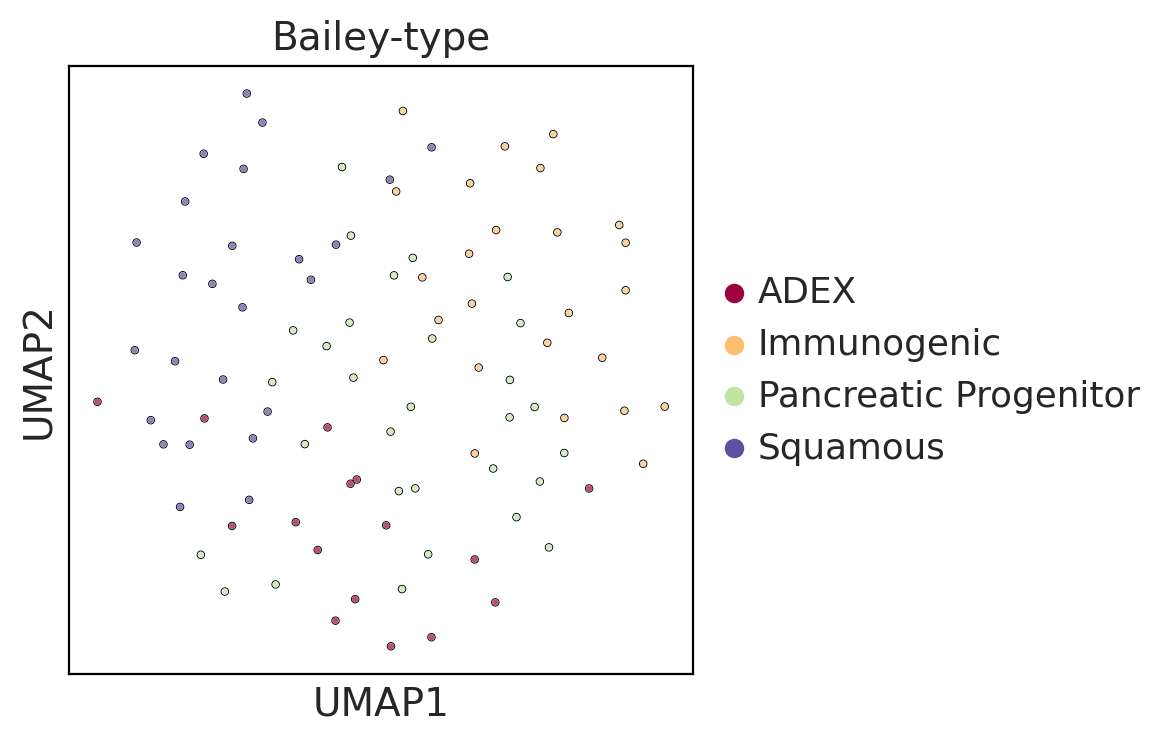

In [94]:
N_pca = 40
sc.tl.pca(Bailey_adata, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(Bailey_adata, n_neighbors=20, n_pcs=N_pca)
sc.tl.umap(Bailey_adata)
sc.pl.umap(Bailey_adata, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

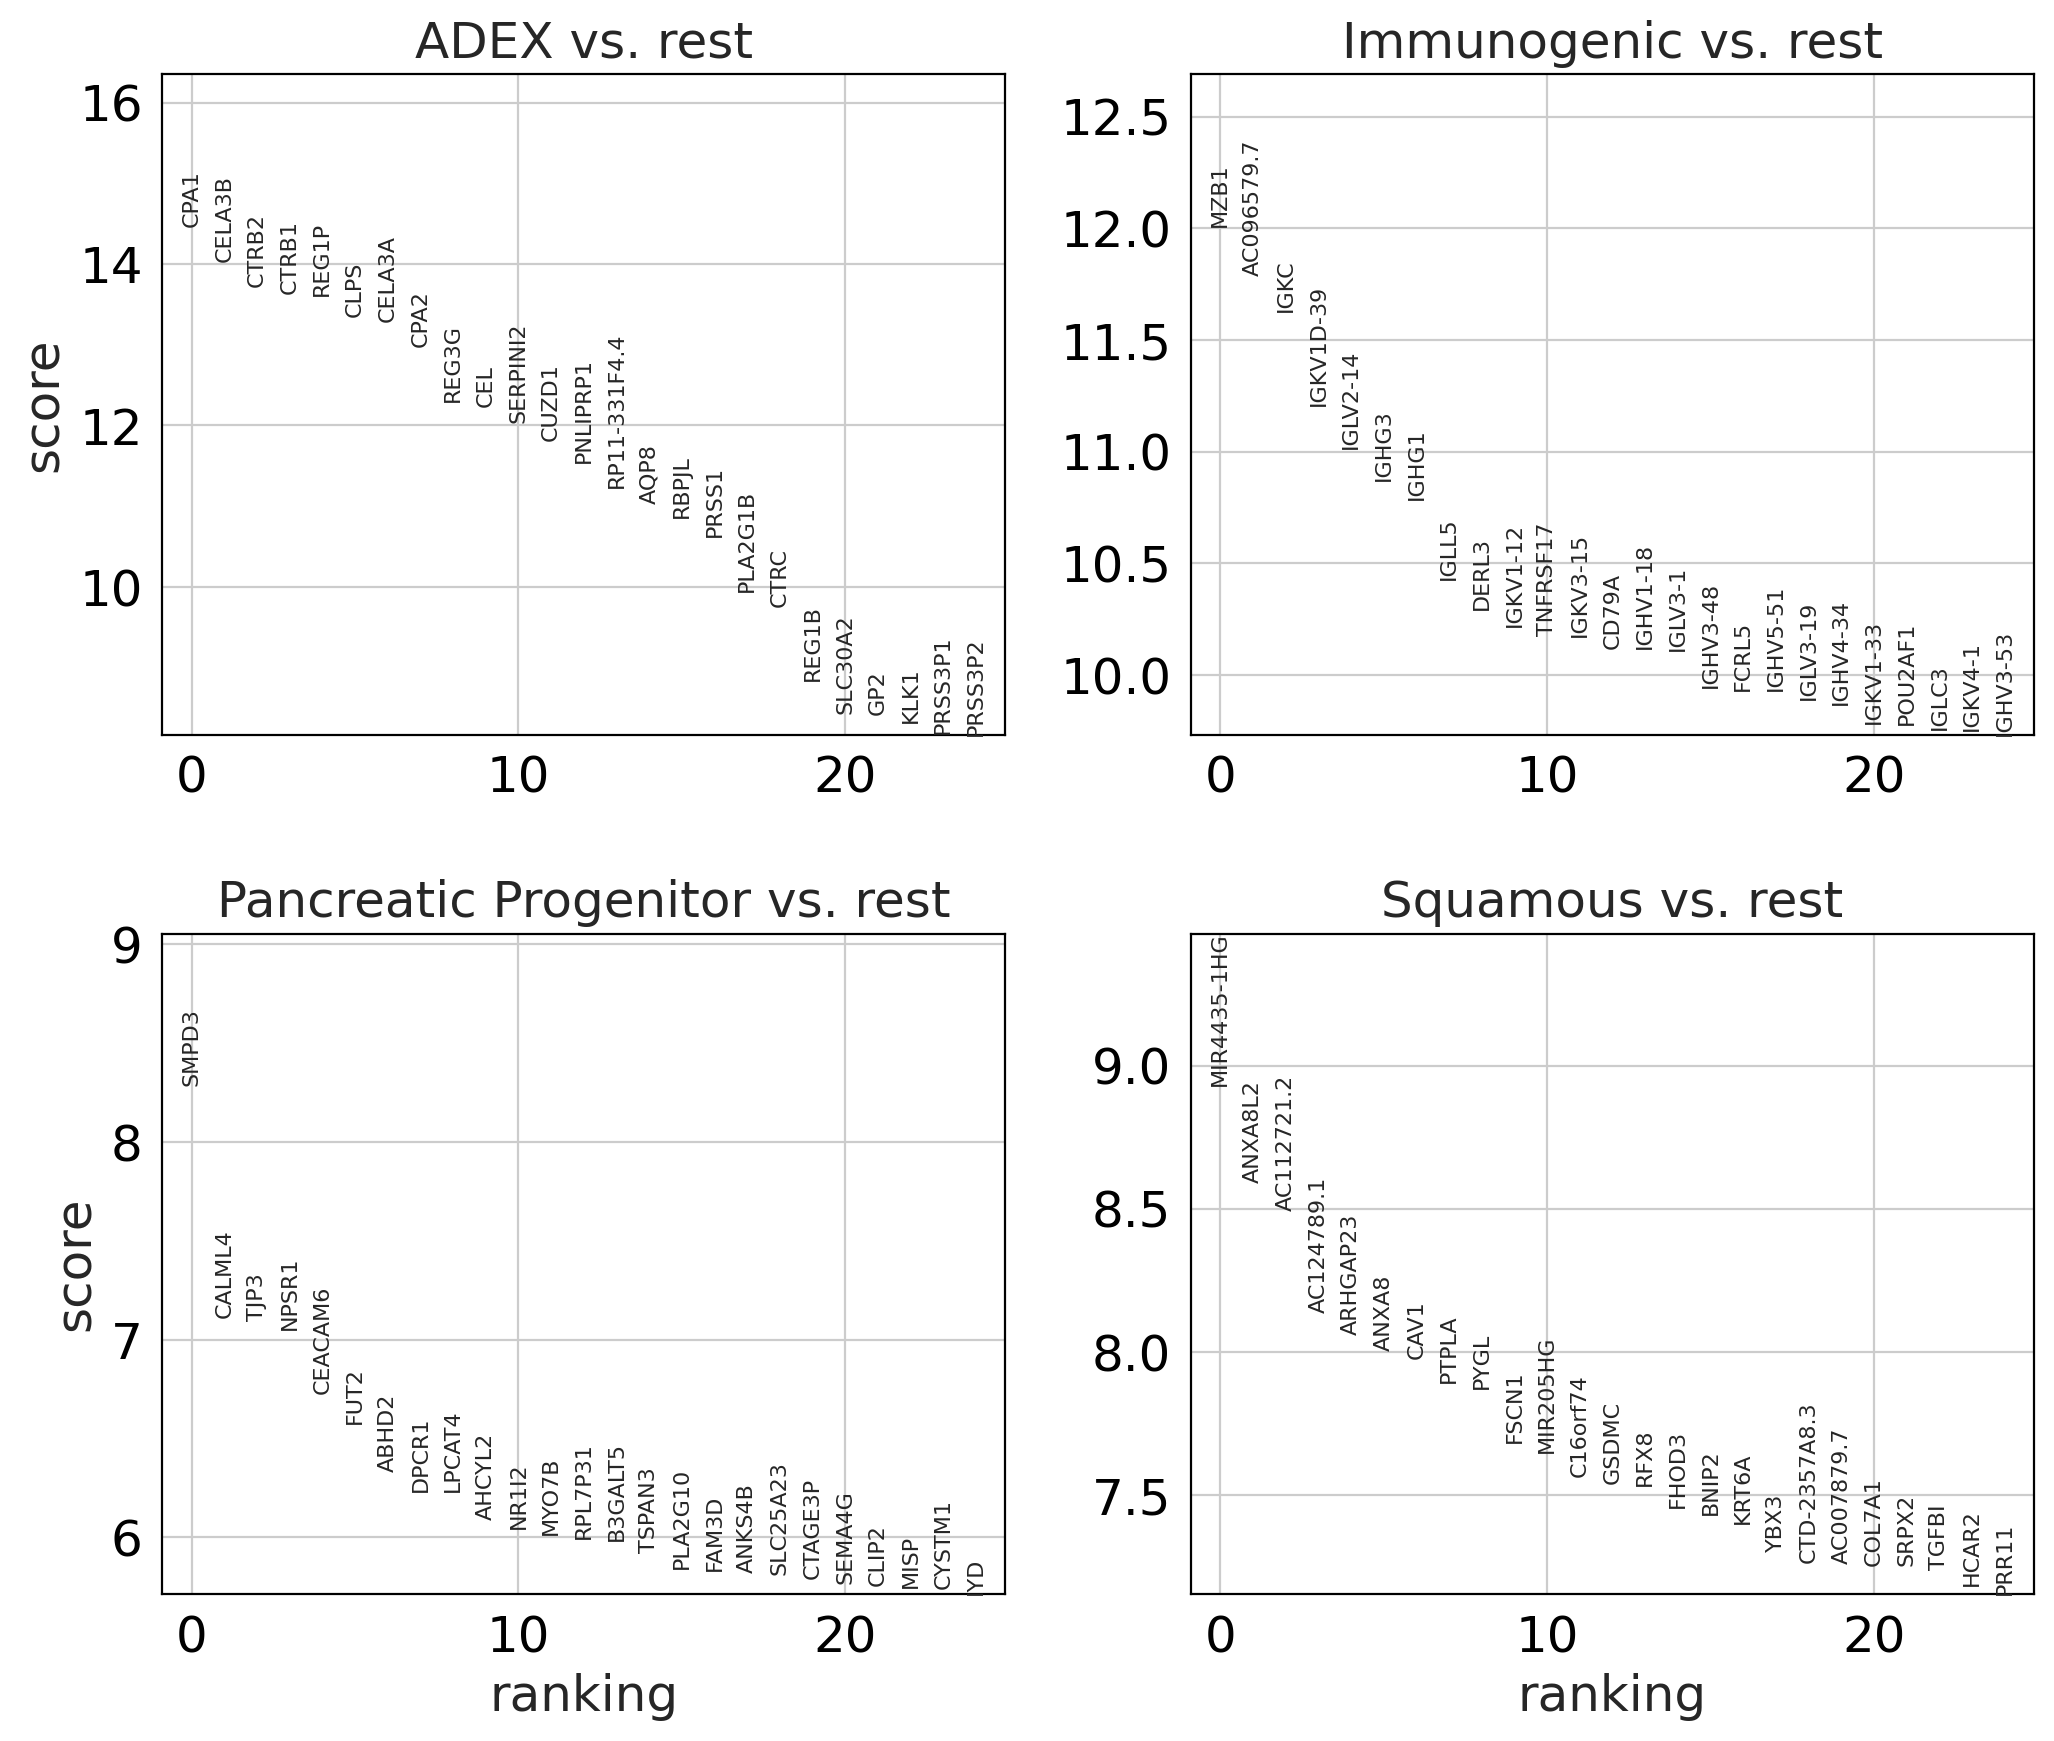

In [95]:
sc.settings.set_figure_params(dpi=100, figsize=(6,5), fontsize=18)
sc.tl.rank_genes_groups(Bailey_adata, 'Bailey-type', method='t-test')
sc.pl.rank_genes_groups(Bailey_adata, n_genes=25, sharey=False, ncols=2, wspace=0.5)

In [6]:
min_val = -Bailey_adata.to_df().min().min()
X = Bailey_adata.to_df() + min_val
Bailey_adata.X = X
sc.tl.rank_genes_groups(Bailey_adata, 'Bailey-type', method='t-test')

In [7]:
def add_suffix(x, suff):
    return x+'_'+suff

result = Bailey_adata.uns['rank_genes_groups']
groups = result['names'].dtype.names


df_genes = pd.DataFrame(result['names'])
df_genes.columns = [sub + '_genes' for sub in df_genes.columns]

df_pvals = pd.DataFrame(result['pvals'])
df_pvals.columns = [sub + '_pvals' for sub in df_pvals.columns]

df_adjpvals = pd.DataFrame(result['pvals_adj'])
df_adjpvals.columns = [sub + '_pvals(adj)' for sub in df_adjpvals.columns]

df_logfc = pd.DataFrame(result['logfoldchanges'])
df_logfc.columns = [sub + '_logFC' for sub in df_logfc.columns]

df_scores = pd.DataFrame(result['scores'])
df_scores.columns = [sub + '_scores' for sub in df_scores.columns]

bailey_deg_all = pd.concat([df_genes,df_pvals,df_adjpvals,df_logfc, df_scores], axis=1)
bailey_deg_all

ADEX_genes Immunogenic_genes Pancreatic Progenitor_genes Squamous_genes  \
0           CPA1              MZB1                       SMPD3    MIR4435-1HG   
1         CELA3B        AC096579.7                      CALML4        ANXA8L2   
2          CTRB2              IGKC                        TJP3     AC112721.2   
3          CTRB1         IGKV1D-39                       NPSR1     AC124789.1   
4          REG1P          IGLV2-14                     CEACAM6       ARHGAP23   
...          ...               ...                         ...            ...   
18072     RNF19B             NDRG4                     TBC1D31         MARCH3   
18073      CSPG4        AC156455.1                      ERGIC2         ATP2A3   
18074    FAM86C1             APLP1                        YBX3          CRYL1   
18075      PSMD3             FBXL2                        RBL1        PIP5K1B   
18076       NOD2            BAIAP3                        MSH6          PAQR8   

         ADEX_pvals  Immunogenic_pvals  Pancreatic Progenitor_pvals  \
0      3.426910e-14       8.289392e-17                 8.290911e-13   
1      8.310367e-14       6.500443e-18                 5.360363e-10   
2      3.434807e-16       1.463565e-17                 2.533794e-10   
3      2.588383e-15       5.517218e-17                 7.118683e-10   
4      1.395122e-14       1.313704e-16                 1.361817e-09   
...             ...                ...                          ...   
18072  6.848139e-06       1.602469e-06                 5.701376e-08   
18073  1.201487e-05       8.843589e-07                 5.393551e-08   
18074  2.527750e-05       3.228527e-07                 1.247338e-08   
18075  1.171152e-05       1.457527e-07                 2.393929e-09   
18076  1.160310e-05       1.734171e-07                 1.459677e-09   

       Squamous_pvals  ADEX_pvals(adj)  Immunogenic_pvals(adj)  \
0        2.736383e-12     1.238965e-10            3.746184e-13   
1        4.079941e-13     2.503775e-10            1.175085e-13   
2        2.211714e-12     6.209101e-12            1.322843e-13   
3        2.404959e-10     2.226866e-11            3.324492e-13   
4        1.933003e-10     6.304905e-11            4.749566e-13   
...               ...              ...                     ...   
18072    1.683537e-11     1.904520e-03            2.178033e-04   
18073    1.214695e-12     3.016567e-03            1.268774e-04   
18074    1.196809e-12     5.375780e-03            5.119480e-05   
18075    9.730601e-12     3.016567e-03            2.417221e-05   
18076    6.872130e-14     3.016567e-03            2.824198e-05   

       Pancreatic Progenitor_pvals(adj)  Squamous_pvals(adj)  ADEX_logFC  \
0                          1.498748e-08         7.066513e-09   11.907033   
1                          3.217111e-06         3.687655e-09   11.411255   
2                          2.290169e-06         7.066513e-09   11.608735   
3                          3.217111e-06         1.890193e-07   11.318287   
4                          4.397763e-06         1.747145e-07    9.454347   
...                                 ...                  ...         ...   
18072                      5.725765e-05         3.043331e-08   -0.644447   
18073                      5.725765e-05         5.489512e-09   -1.688638   
18074                      2.254813e-05         5.489512e-09   -0.769697   
18075                      6.182152e-06         2.198751e-08   -0.635162   
18076                      4.397763e-06         1.242275e-09   -1.252169   

       Immunogenic_logFC  Pancreatic Progenitor_logFC  Squamous_logFC  \
0               4.249172                     2.544737        1.318630   
1               5.056964                     1.715688        5.790361   
2               5.267571                     1.599369        4.036329   
3               5.079212                     6.409282        4.162665   
4               5.023134                     2.443651        2.231146   
...                  ...            

In [23]:
m = bailey_deg_all.columns.str.contains('ADEX')
ADEX_df = bailey_deg_all.loc[:,m]
m = bailey_deg_all.columns.str.contains('Immunogenic')
Immunogenic_df = bailey_deg_all.loc[:,m]
ADEX_df['-log(p-value)'] = ADEX_df['ADEX_pvals'].map(np.log10)*-1
m = ADEX_df['ADEX_pvals(adj)'] < 0.001
arcina_cell_mk = 'AKR1C3,ALDOB,AMY2B,ANGPTL4,ANPEP,C15ORF48,CEL,CELA1,CELA2A,CELA3A,CELA3B,CFB,CLPS,CPA1,CPA2,CPB1,CTRB1,CTRB2,CTRC,CXCL17,DUOXA2,GDF15,GSTA1,GSTA2,KLK1,LGALS2,LYZ,MUC1,OLFM4,PDZK1IP1,PLA2G1B,PNLIP,PNLIPRP1,PRSS1,PRSS2,PRSS3,PTF1A,RARRES2,RBPJL,REG1A,REG1B,REG3A,RNASE1,SERPINA3,SPINK1,SYCN,UBD,ZG16'.split(',')
arcina_cell_genes = list(set(ADEX_df.loc[m,'ADEX_genes'])&set(arcina_cell_mk))
arcina_cell_genes
ADEX_df['Arcinar cell Marker']='No'
m = ADEX_df['ADEX_genes'].isin(arcina_cell_genes)
ADEX_df.loc[m,'Arcinar cell Marker']='Yes'

Immunogenic_df['-log(p-value)'] = Immunogenic_df['Immunogenic_pvals'].map(np.log10)*-1

m1 = Immunogenic_df['Immunogenic_pvals(adj)'] < 0.001
m2 = Immunogenic_df['Immunogenic_genes'].str.startswith('IG')
m = m1&m2
bcell_genes = list(Immunogenic_df[m]['Immunogenic_genes'])
bcell_genes = bcell_genes+['CD79A']
m = Immunogenic_df['Immunogenic_genes'].isin(bcell_genes)
Immunogenic_df['B cell Marker'] = 'No'
m = Immunogenic_df['Immunogenic_genes'].isin(bcell_genes)
Immunogenic_df.loc[m,'B cell Marker']='Yes'

# arcina_cell_mk = 'AKR1C3,ALDOB,AMY2B,ANGPTL4,ANPEP,C15ORF48,CEL,CELA1,CELA2A,CELA3A,CELA3B,CFB,CLPS,CPA1,CPA2,CPB1,CTRB1,CTRB2,CTRC,CXCL17,DUOXA2,GDF15,GSTA1,GSTA2,KLK1,LGALS2,LYZ,MUC1,OLFM4,PDZK1IP1,PLA2G1B,PNLIP,PNLIPRP1,PRSS1,PRSS2,PRSS3,PTF1A,RARRES2,RBPJL,REG1A,REG1B,REG3A,RNASE1,SERPINA3,SPINK1,SYCN,UBD,ZG16'.split(',')
# arcina_cell_genes = list(set(ADEX_df.loc[m,'ADEX_genes'])&set(arcina_cell_mk))
# arcina_cell_genes
# ADEX_df['Arcinar Cell Marker']='No'
# m = ADEX_df['ADEX_genes'].isin(arcina_cell_genes)
# ADEX_df.loc[m,'Arcinar Cell Marker']='Yes'
# ADEX_df

In [24]:
ADEX_df

ADEX_genes    ADEX_pvals  ADEX_pvals(adj)  ADEX_logFC  ADEX_scores  \
0           CPA1  3.426910e-14     1.238965e-10   11.907033    14.460230   
1         CELA3B  8.310367e-14     2.503775e-10   11.411255    14.031083   
2          CTRB2  3.434807e-16     6.209101e-12   11.608735    13.713585   
3          CTRB1  2.588383e-15     2.226866e-11   11.318287    13.633559   
4          REG1P  1.395122e-14     6.304905e-11    9.454347    13.610223   
...          ...           ...              ...         ...          ...   
18072     RNF19B  6.848139e-06     1.904520e-03   -0.644447    -5.172845   
18073      CSPG4  1.201487e-05     3.016567e-03   -1.688638    -5.289244   
18074    FAM86C1  2.527750e-05     5.375780e-03   -0.769697    -5.352817   
18075      PSMD3  1.171152e-05     3.016567e-03   -0.635162    -5.400527   
18076       NOD2  1.160310e-05     3.016567e-03   -1.252169    -5.411579   

       -log(p-value) Arcinar cell Marker  
0          13.465097                 Yes  
1          13.080380                 Yes  
2          15.464098                 Yes  
3          14.586971                 Yes  
4          13.855388                  No  
...              ...                 ...  
18072       5.164427                  No  
18073       4.920281                  No  
18074       4.597266                  No  
18075       4.931387                  No  
18076       4.935426                  No  

[18077 rows x 7 columns]

'CPA1,CELA3B,CTRB2,CTRB1,CLPS,CELA3A,CPA2,CEL,PNLIPRP1,RBPJL,PRSS1,PLA2G1B,CTRC,REG1B,KLK1,SYCN,REG1A,REG3A,CPB1,CELA2A'

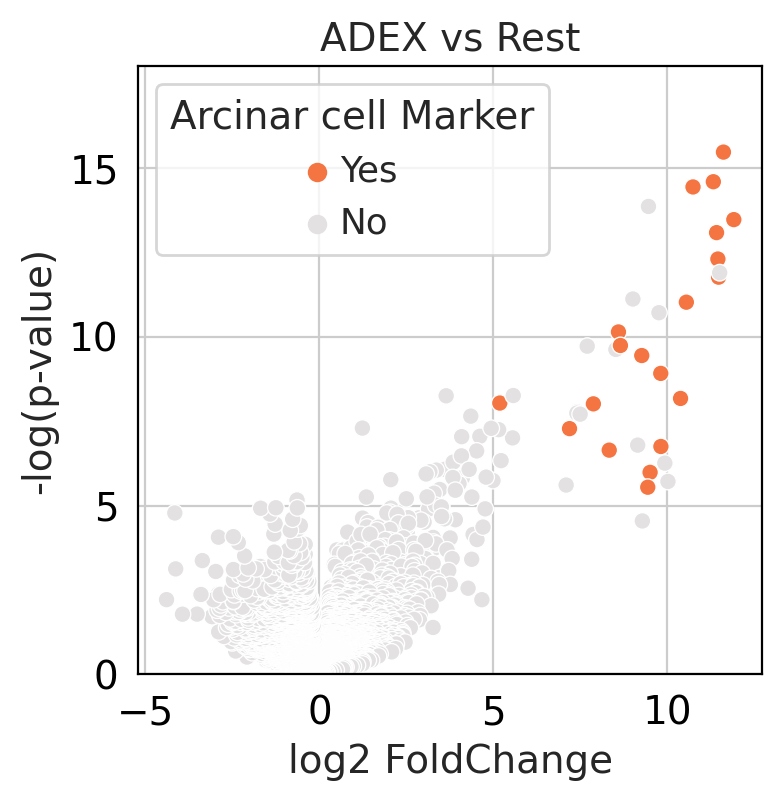

In [30]:
ax = sns.scatterplot(data=ADEX_df, x='ADEX_logFC', y='-log(p-value)', hue='Arcinar cell Marker', palette=['#f57542','#e3e1e1'])
ax.set_xlabel('log2 FoldChange')
ax.set_title('ADEX vs Rest')
ax.set_ylim((0,18))

m = ADEX_df['Arcinar cell Marker'] == 'Yes'
','.join(list(ADEX_df[m]['ADEX_genes']))

'IGKC,IGKV1D-39,IGLV2-14,IGHG3,IGHG1,IGLL5,IGKV1-12,IGKV3-15,CD79A,IGHV1-18,IGLV3-1,IGHV3-48,IGHV5-51,IGLV3-19,IGHV4-34,IGKV1-33,IGLC3,IGKV4-1,IGHV3-53,IGHV3-21,IGJ,IGKV3-11,IGKV3-20,IGHG2,IGHV3-23,IGHV4-61,IGLV1-40,IGHV4-4,IGHV3-13,IGHV3-33,IGHV1-46,IGHV3-74,IGHV4-59,IGHV1-69,IGHV3-7,IGKV1-5,IGKV2-28,IGLV2-18,IGHA1,IGHV3-49,IGLV2-23,IGLV1-41,IGLC1,IGHV3-11,IGLV3-21,IGKV1-6,IGKV1-8,IGKV3D-15,IGLV1-51,IGLV2-11,IGHV3-15,IGLV1-36,IGLV1-47,IGHV2-26,IGLV1-44,IGHV1-58,IGHGP,IGHV2-70,IGHV3-20,IGHV1-24,IGLV4-69,IGKV2-30,IGKV1-27,IGLV3-25,IGHV3-72,IGKV2-24,IGLV6-57,IGHV3-30,IGHA2,IGHV3-43,IGKV1-9,IGHV2-5,IGKV1-16,IGKV1D-16,IGLV2-8,IGHM,IGKV1-17,IGKV6D-21,IGHG4,IGHV1-2,IGHV3-73,IGHV6-1,IGHV4-28,IGLV5-45,IGLV3-10,IGLV7-43,IGHV4-39,IGKV3D-20,IGKV6-21,IGHV4-31,IGKV1D-13,IGHV3-64,IGKV2D-29,IGLV3-27,IGHV3-66,IGHV1-8'

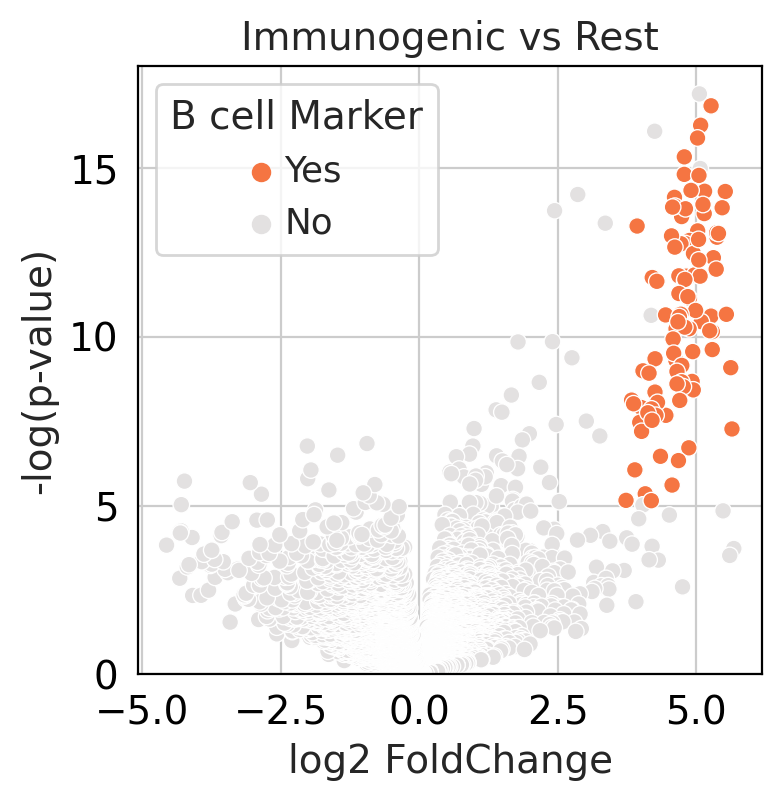

In [31]:
ax = sns.scatterplot(data=Immunogenic_df, x='Immunogenic_logFC', y='-log(p-value)', hue='B cell Marker', hue_order=['Yes', 'No'], palette=['#f57542','#e3e1e1'])
ax.set_xlabel('log2 FoldChange')
ax.set_title('Immunogenic vs Rest')
ax.set_ylim((0,18))

m = Immunogenic_df['B cell Marker'] == 'Yes'
','.join(list(Immunogenic_df[m]['Immunogenic_genes']))

In [131]:
threshold = 0.05
m =  bailey_deg_all['ADEX_pvals(adj)'] < threshold
ADEX_genes = list(bailey_deg_all[m]['ADEX_genes'])
print('ADEX: {}'.format(len(ADEX_genes)))

m =  bailey_deg_all['Immunogenic_pvals(adj)'] < threshold
Immunogenic_genes = list(bailey_deg_all[m]['Immunogenic_genes'])
print('Immunogenic: {}'.format(len(Immunogenic_genes)))

m =  bailey_deg_all['Pancreatic Progenitor_pvals(adj)'] < threshold
PProgenitor_genes = list(bailey_deg_all[m]['Pancreatic Progenitor_genes'])
print('Pancreatic Progenitor: {}'.format(len(PProgenitor_genes)))

m =  bailey_deg_all['Squamous_pvals(adj)'] < threshold
Squamous_genes = list(bailey_deg_all[m]['Squamous_genes'])
print('Squamous: {}'.format(len(Squamous_genes)))

total_unique = list(set(ADEX_genes)|set(Immunogenic_genes)|set(PProgenitor_genes)|set(Squamous_genes))
print('Total unique genes: {}'.format(len(total_unique)))

ADEX: 247
Immunogenic: 1144
Pancreatic Progenitor: 1128
Squamous: 4304
Total unique genes: 5378


['CPB1',
 'CELA2A',
 'PNLIP',
 'REG1B',
 'CLPS',
 'PRSS1',
 'CTRB1',
 'CPA2',
 'CPA1',
 'CTRB2',
 'REG1A',
 'CELA3B',
 'SYCN',
 'AMY2B',
 'SPINK1',
 'PRSS3',
 'PLA2G1B',
 'CELA3A',
 'CEL',
 'KLK1',
 'CTRC',
 'PNLIPRP1',
 'REG3A',
 'SERPINA3',
 'RBPJL']

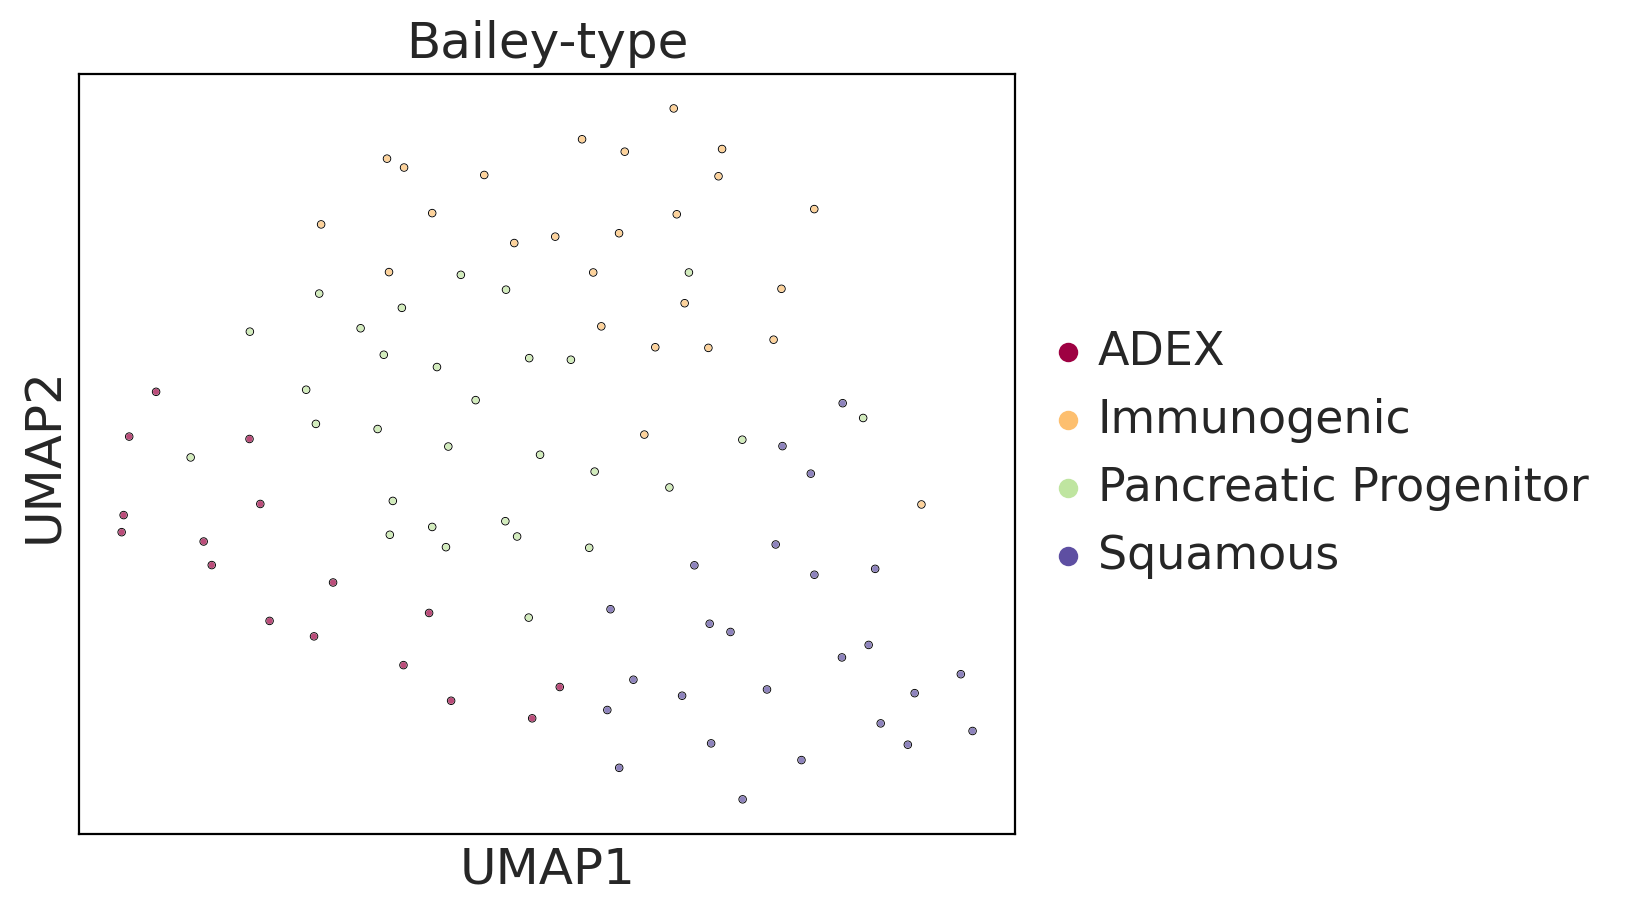

In [11]:
Bailey_adata_sel = Bailey_adata[:,total_unique]

N_pca = 40
sc.tl.pca(Bailey_adata_sel, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(Bailey_adata_sel, n_neighbors=20, n_pcs=N_pca)
sc.tl.umap(Bailey_adata_sel)
sc.pl.umap(Bailey_adata_sel, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

In [12]:
features = list(set(common_genes_all)&set(total_unique))
print(len(features))
mg_adata = SNU_adata[:,features].concatenate(Bailey_adata[:,features])
mg_adata.to_df()

4810


ST6GALNAC5    KDELR3     REG1B    FNDC3A     PAAF1  \
20-T00330_FO-01-0    1.327075  2.617396  3.151025  2.832036  2.374906   
19-T00062_FO-01-0    1.960095  3.069447  6.372364  2.871868  1.761300   
20-T00814_FT-01-0    1.893112  3.606856  2.829678  3.426540  2.562639   
19-T00201_FO-01-0    2.118662  2.765060  0.000000  3.421980  2.572612   
19-T00505_FO-01-0    0.824175  3.811318  3.558771  3.561614  2.112634   
...                       ...       ...       ...       ...       ...   
ICGC_0507-1          3.513256  5.106463 -2.594265  6.787901  3.060850   
ICGC_0521-1          3.693166  4.495277 -6.997310  6.719610  3.354695   
ICGC_0522-1          2.919128  3.665585 -6.122054  6.745006  2.709973   
ICGC_0526-1          1.446814  6.899192 -6.997310  6.615949  3.382110   
ICGC_0543-1          3.918599  5.195895 -2.454324  6.829370  3.163980   

                       MFNG      LIPH    CEACAM5   PACSIN3   C5orf45  ...  \
20-T00330_FO-01-0  2.823163  3.813307   5.053056  3.587124  3.259250  ...   
19-T00062_FO-01-0  2.754297  2.754934   6.533498  2.595255  2.684440  ...   
20-T00814_FT-01-0  3.198265  4.401462   6.442604  2.915606  4.074992  ...   
19-T00201_FO-01-0  3.131137  4.335328   5.723193  3.003700  4.018183  ...   
19-T00505_FO-01-0  3.809326  4.546587   7.143151  2.857619  3.747384  ...   
...                     ...       ...        ...       ...       ...  ...   
ICGC_0507-1        2.057431  5.462241   7.595734  3.441860  4.215391  ...   
ICGC_0521-1        1.129837  6.292701  10.093668  2.809331  4.902890  ...   
ICGC_0522-1        2.992511  6.248356   7.562331  4.057909  4.759846  ...   
ICGC_0526-1        1.515194  7.666806   4.562992  2.352547  3.766883  ...   
ICGC_0543-1        1.522513  4.744153   7.357212  3.826323  3.080645  ...   

                      AGFG2     P2RY8       TNC        F5     AMER3    CEP112  \
20-T00330_FO-01-0  3.004196  2.016236  3.453474  0.879627  0.891998  2.658860   
19-T00062_FO-01-0  1.558145  1.463255  2.662355  2.851284  0.000000  2.379546   
20-T00814_FT-01-0  4.001132  1.004302  0.837247  3.535728  1.740466  2.375836   
19-T00201_FO-01-0  4.236278  1.214913  4.993422  1.838961  0.000000  1.879465   
19-T00505_FO-01-0  3.701796  1.396245  3.447445  3.293612  0.131028  2.117460   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0507-1        5.214702  1.406710  8.628172  6.484998 -1.971141  3.830387   
ICGC_0521-1        3.276599  0.204617  5.312052  5.585287 -3.167350  4.032965   
ICGC_0522-1        4.556883  1.500914  7.826172  5.074431 -2.042282  3.819251   
ICGC_0526-1        3.939676  1.484877  3.952646  7.831950 -3.189804  2.924703   
ICGC_0543-1        2.802128  1.987296  9.435153  2.324183 -6.358267  3.577204   

                      MSMO1       HRK      MID2     SMCO4  
20-T00330_FO-01-0  2.498152  1.061257  2.068128  3.015535  
19-T00062_FO-01-0  3.529591  0.000000  1.321756  1.859418  
20-T00814_FT-01-0  2.971952  0.900161  0.955511  3.251924  
19-T00201_FO-01-0  3.520757  0.322083  1.911023  2.789937  
19-T00505_FO-01-0  4.074312  0.067659  1.560248  3.333275  
...                     ...       ...       ...       ...  
ICGC_0507-1        4.838086  0.654305  3.572266  2.940709  
ICGC_0521-1        4.788481  1.756531  3.238788  2.858372  
ICGC_0522-1        4.399362  2.071863  3.098712  2.755864  
ICGC_0526-1        5.653291 -0.833751  3.474059  3.679906  
ICGC_0543-1        5.373358  0.092923  3.942560  2.816330  

[189 rows x 4810 columns]

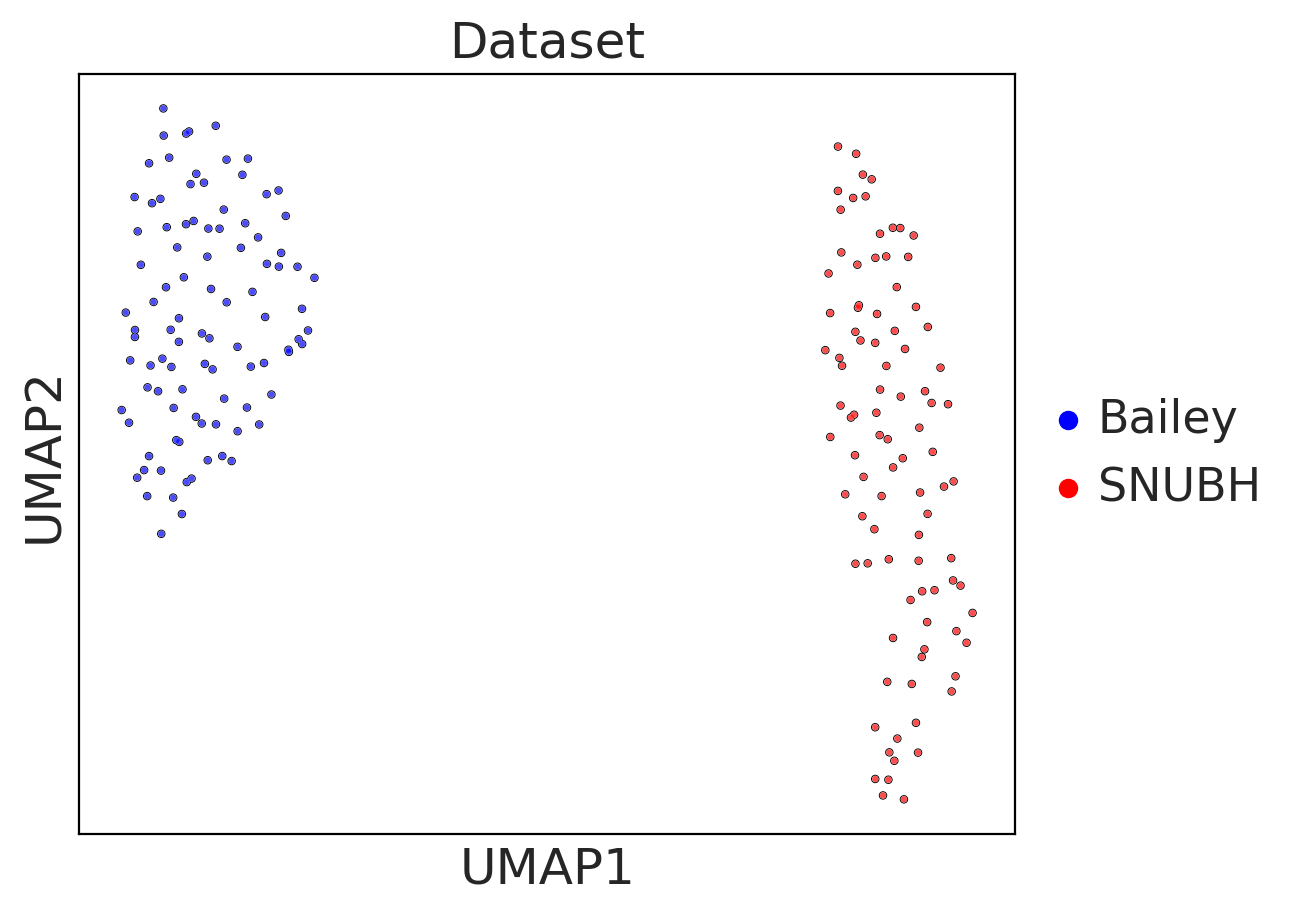

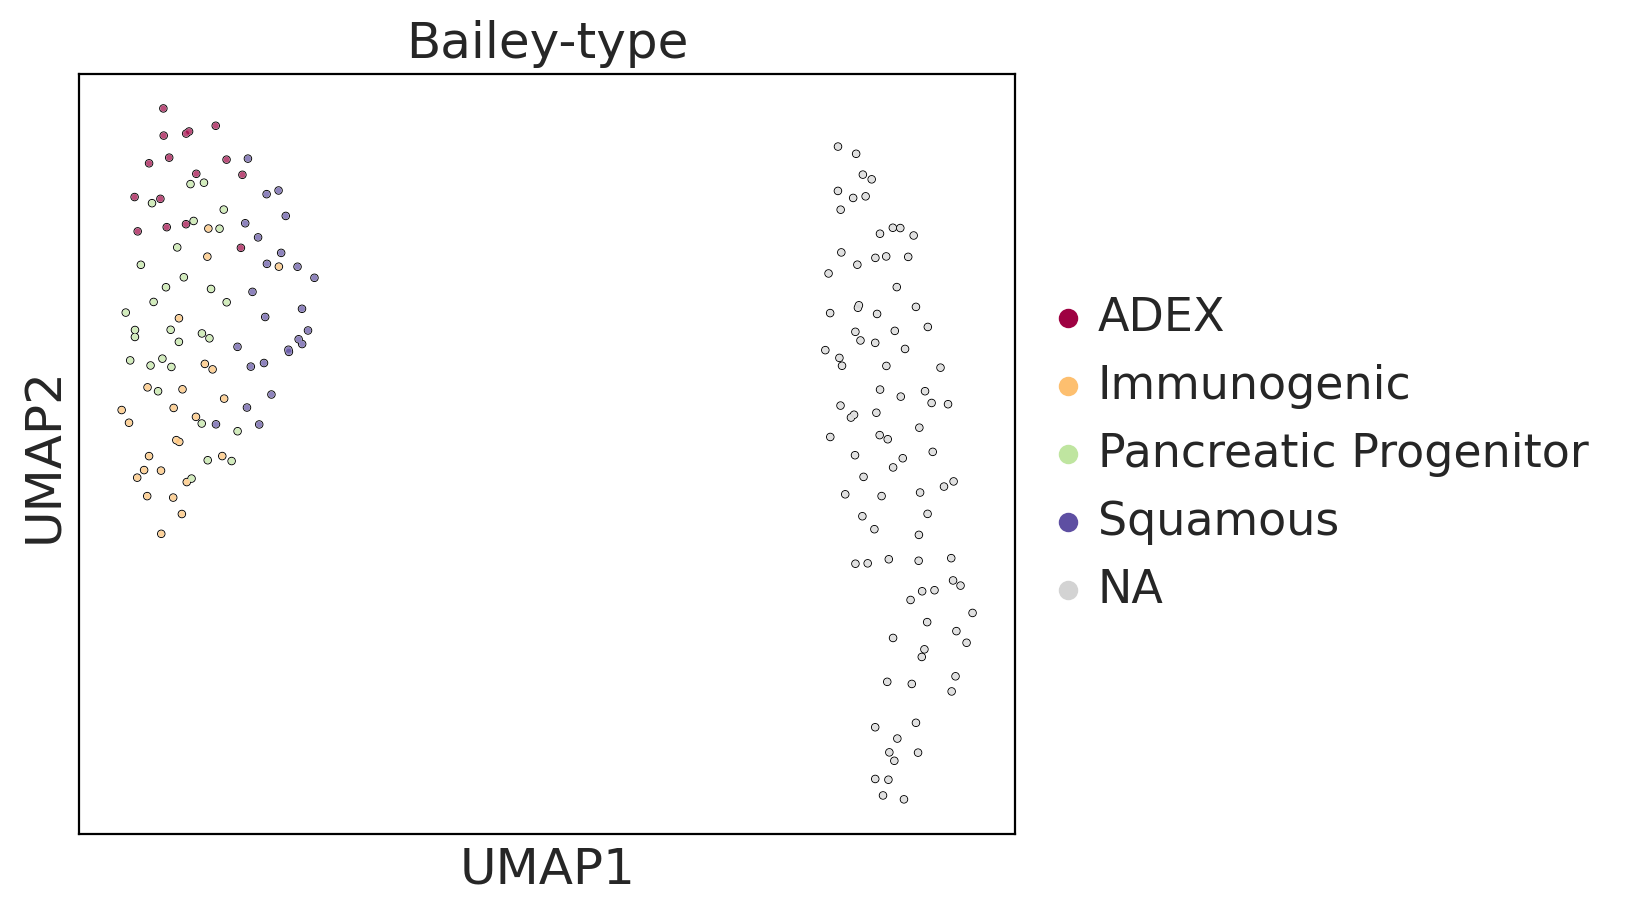

In [13]:
N_pca = 40
sc.tl.pca(mg_adata, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(mg_adata, n_neighbors=20, n_pcs=N_pca)
sc.tl.umap(mg_adata)
sc.pl.umap(mg_adata, color=['Dataset'], palette='bwr', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))
sc.pl.umap(mg_adata, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

# Combat Batch Effect Reduction

In [520]:
df_exp_all = mg_adata.to_df().T
batch = list(mg_adata.obs['Dataset'].values)
df_corrected = pycombat(df_exp_all,batch).T
mg_adata_bec = sc.AnnData(df_corrected)
mg_adata_bec.obs = mg_adata.obs.copy()
mg_adata_bec.to_df()

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


FAM160A2     RUNX2    LMAN2L       PPY      TGFA    IL1RAP  \
20-T00330_FO-01-0  4.094869  3.715903  3.001089  6.817541  4.708012  3.929679   
19-T00062_FO-01-0  3.984845  3.424245  2.266161 -0.800533  3.693843  4.346752   
20-T00814_FT-01-0  5.967812  2.486933  2.590017  1.860171  4.247869  4.927292   
19-T00201_FO-01-0  4.467832  4.219067  3.563941 -0.800533  5.321800  5.648303   
19-T00505_FO-01-0  4.882112  4.035561  3.181023  7.713940  5.002523  5.125636   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0507-1        4.608512  3.312836  2.993670 -0.332324  3.608642  3.619407   
ICGC_0521-1        5.138515  4.829382  3.358043  0.583428  4.618367  5.319366   
ICGC_0522-1        5.633263  3.590103  2.686638 -3.998469  3.517558  3.867416   
ICGC_0526-1        4.709728  2.148741  3.104869 -0.177464  4.567955  3.518142   
ICGC_0543-1        3.950366  3.935238  3.968709 -3.998469  5.521575  5.907336   

                      CELF3      MCM8     TRIQK    WNT10A  ...  C1orf226  \
20-T00330_FO-01-0 -0.444311  2.556804  3.516297  4.699336  ...  3.147258   
19-T00062_FO-01-0 -1.816291  2.200212  3.438834  2.737859  ...  1.444478   
20-T00814_FT-01-0 -1.816291  1.990534  4.472869  0.117092  ...  3.423330   
19-T00201_FO-01-0 -0.535514  3.162092  4.929133  2.866986  ...  3.146530   
19-T00505_FO-01-0 -0.307886  2.750795  4.206538  1.261657  ...  3.447661   
...                     ...       ...       ...       ...  ...       ...   
ICGC_0507-1       -0.210023  2.200655  4.535044  0.490825  ...  3.352700   
ICGC_0521-1       -3.179093  2.963660  4.042275  3.360498  ...  3.883821   
ICGC_0522-1       -0.644532  3.092402  2.973573  3.173009  ...  2.247333   
ICGC_0526-1       -3.504286  2.822798  4.340676 -0.740196  ...  3.773531   
ICGC_0543-1       -3.718934  3.913637  3.499519  2.087392  ...  0.761312   

                      HDAC7     RBM47    PTPRN2   FAM217B     APBB2     KLHL3  \
20-T00330_FO-01-0  4.898281  5.126813  2.344863  2.678450  4.137278  2.443555   
19-T00062_FO-01-0  4.544415  4.535910  3.597125  2.967693  4.766164  2.903636   
20-T00814_FT-01-0  5.100910  6.037793  5.257509  4.085358  4.521362  3.981162   
19-T00201_FO-01-0  5.455890  6.220290  4.983940  4.024116  5.167794  4.229104   
19-T00505_FO-01-0  5.177528  5.656679  5.296204  3.864051  4.358913  4.148891   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0507-1        4.866201  5.365479  4.820529  3.275133  5.090683  3.775480   
ICGC_0521-1        5.610932  5.305554  2.291620  3.893713  4.629704  3.825755   
ICGC_0522-1        5.942852  4.247725  3.089617  3.484368  4.870369  4.113625   
ICGC_0526-1        4.408799  6.648900  4.119499  2.920258  3.769350  3.904871   
ICGC_0543-1        4.775712  4.696911  0.445210  3.235417  5.002744  2.075467   

                      EEPD1      USP7     PRKCB  
20-T00330_FO-01-0  2.727184  5.343137  2.738815  
19-T00062_FO-01-0  2.353397  4.935565  2.730639  
20-T00814_FT-01-0  4.302453  4.981135  1.799726  
19-T00201_FO-01-0  3.958627  5.947652  0.835765  
19-T00505_FO-01-0  4.056014  5.376324  2.185988  
...                     ...       ...       ...  
ICGC_0507-1        4.579843  5.475750  4.878619  
ICGC_0521-1        2.650344  5.699238  0.768450  
ICGC_0522-1        4.259327  4.938935  3.157639  
ICGC_0526-1        5.287154  5.500690  1.994684  
ICGC_0543-1        2.423043  6.082036  2.870399  

[189 rows x 4810 columns]

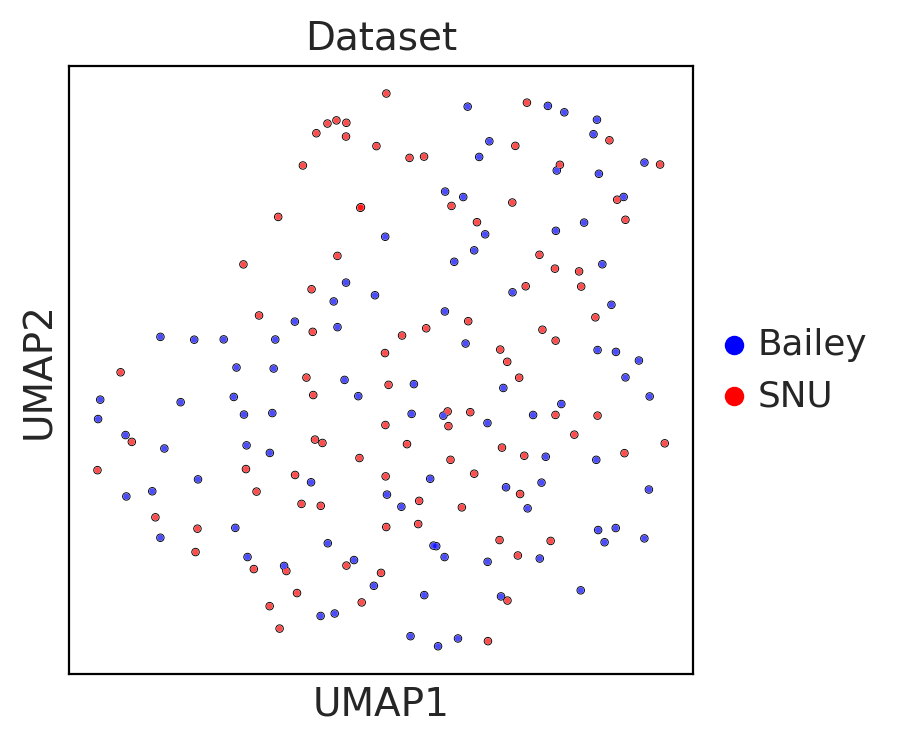

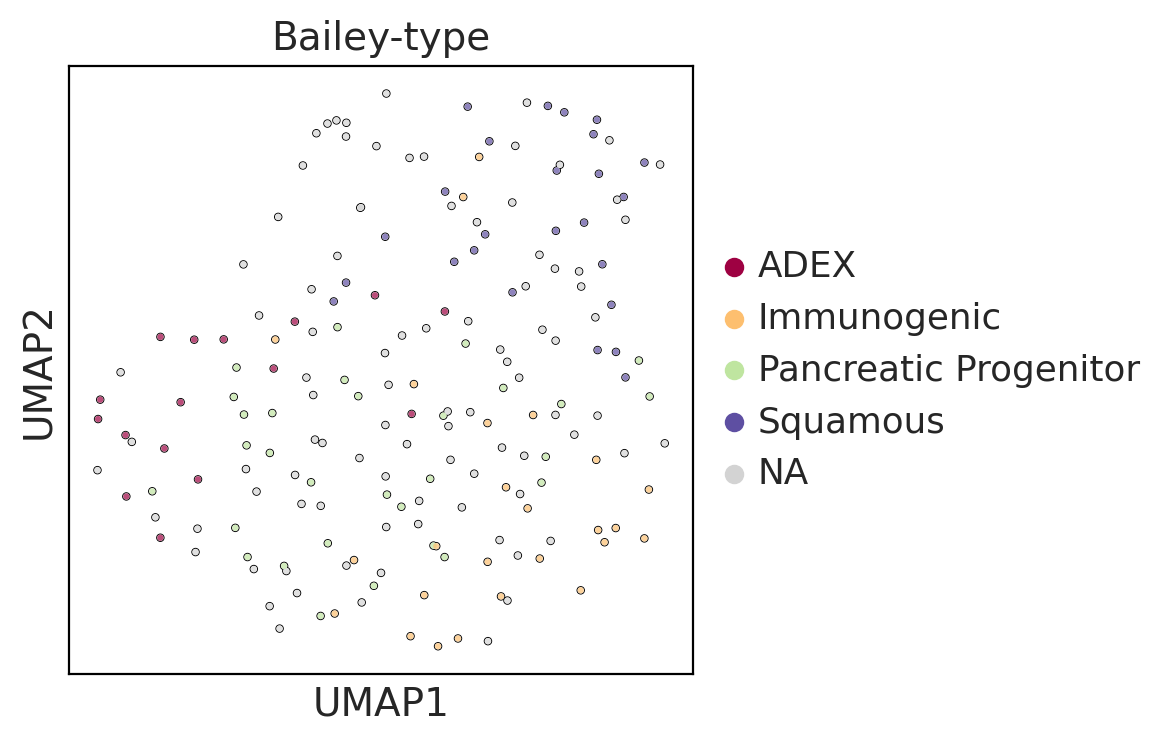

In [521]:
N_pca = 30
sc.tl.pca(mg_adata_bec, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(mg_adata_bec, n_neighbors=30, n_pcs=N_pca)
sc.tl.umap(mg_adata_bec)
sc.pl.umap(mg_adata_bec, color=['Dataset'], palette='bwr', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))
sc.pl.umap(mg_adata_bec, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

In [522]:
all_exp = mg_adata_bec.to_df()
all_exp

FAM160A2     RUNX2    LMAN2L       PPY      TGFA    IL1RAP  \
20-T00330_FO-01-0  4.094869  3.715903  3.001089  6.817541  4.708012  3.929679   
19-T00062_FO-01-0  3.984845  3.424245  2.266161 -0.800533  3.693843  4.346752   
20-T00814_FT-01-0  5.967812  2.486933  2.590017  1.860171  4.247869  4.927292   
19-T00201_FO-01-0  4.467832  4.219067  3.563941 -0.800533  5.321800  5.648303   
19-T00505_FO-01-0  4.882112  4.035561  3.181023  7.713940  5.002523  5.125636   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0507-1        4.608512  3.312836  2.993670 -0.332324  3.608642  3.619407   
ICGC_0521-1        5.138515  4.829382  3.358043  0.583428  4.618367  5.319366   
ICGC_0522-1        5.633263  3.590103  2.686638 -3.998469  3.517558  3.867416   
ICGC_0526-1        4.709728  2.148741  3.104869 -0.177464  4.567955  3.518142   
ICGC_0543-1        3.950366  3.935238  3.968709 -3.998469  5.521575  5.907336   

                      CELF3      MCM8     TRIQK    WNT10A  ...  C1orf226  \
20-T00330_FO-01-0 -0.444311  2.556804  3.516297  4.699336  ...  3.147258   
19-T00062_FO-01-0 -1.816291  2.200212  3.438834  2.737859  ...  1.444478   
20-T00814_FT-01-0 -1.816291  1.990534  4.472869  0.117092  ...  3.423330   
19-T00201_FO-01-0 -0.535514  3.162092  4.929133  2.866986  ...  3.146530   
19-T00505_FO-01-0 -0.307886  2.750795  4.206538  1.261657  ...  3.447661   
...                     ...       ...       ...       ...  ...       ...   
ICGC_0507-1       -0.210023  2.200655  4.535044  0.490825  ...  3.352700   
ICGC_0521-1       -3.179093  2.963660  4.042275  3.360498  ...  3.883821   
ICGC_0522-1       -0.644532  3.092402  2.973573  3.173009  ...  2.247333   
ICGC_0526-1       -3.504286  2.822798  4.340676 -0.740196  ...  3.773531   
ICGC_0543-1       -3.718934  3.913637  3.499519  2.087392  ...  0.761312   

                      HDAC7     RBM47    PTPRN2   FAM217B     APBB2     KLHL3  \
20-T00330_FO-01-0  4.898281  5.126813  2.344863  2.678450  4.137278  2.443555   
19-T00062_FO-01-0  4.544415  4.535910  3.597125  2.967693  4.766164  2.903636   
20-T00814_FT-01-0  5.100910  6.037793  5.257509  4.085358  4.521362  3.981162   
19-T00201_FO-01-0  5.455890  6.220290  4.983940  4.024116  5.167794  4.229104   
19-T00505_FO-01-0  5.177528  5.656679  5.296204  3.864051  4.358913  4.148891   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0507-1        4.866201  5.365479  4.820529  3.275133  5.090683  3.775480   
ICGC_0521-1        5.610932  5.305554  2.291620  3.893713  4.629704  3.825755   
ICGC_0522-1        5.942852  4.247725  3.089617  3.484368  4.870369  4.113625   
ICGC_0526-1        4.408799  6.648900  4.119499  2.920258  3.769350  3.904871   
ICGC_0543-1        4.775712  4.696911  0.445210  3.235417  5.002744  2.075467   

                      EEPD1      USP7     PRKCB  
20-T00330_FO-01-0  2.727184  5.343137  2.738815  
19-T00062_FO-01-0  2.353397  4.935565  2.730639  
20-T00814_FT-01-0  4.302453  4.981135  1.799726  
19-T00201_FO-01-0  3.958627  5.947652  0.835765  
19-T00505_FO-01-0  4.056014  5.376324  2.185988  
...                     ...       ...       ...  
ICGC_0507-1        4.579843  5.475750  4.878619  
ICGC_0521-1        2.650344  5.699238  0.768450  
ICGC_0522-1        4.259327  4.938935  3.157639  
ICGC_0526-1        5.287154  5.500690  1.994684  
ICGC_0543-1        2.423043  6.082036  2.870399  

[189 rows x 4810 columns]

In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, auc, plot_roc_curve
from sklearn import svm
from sklearn.metrics import roc_curve, auc
scaler = StandardScaler()
lb = preprocessing.LabelBinarizer()

In [524]:
scaled_df = pd.DataFrame(scaler.fit_transform(all_exp), columns=all_exp.columns, index=all_exp.index)
scaled_df

FAM160A2     RUNX2    LMAN2L       PPY      TGFA    IL1RAP  \
20-T00330_FO-01-0 -0.797161  0.665560 -0.418397  2.453826  0.283950 -1.049564   
19-T00062_FO-01-0 -0.989968  0.272050 -1.941989 -0.503011 -1.198974 -0.484397   
20-T00814_FT-01-0  2.485003 -0.992591 -1.270598  0.529700 -0.388874  0.302280   
19-T00201_FO-01-0 -0.143578  1.344439  0.748462 -0.503011  1.181435  1.279306   
19-T00505_FO-01-0  0.582411  1.096849 -0.045374  2.801750  0.714587  0.571052   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0507-1        0.102952  0.121735 -0.433777 -0.321283 -1.323555 -1.470008   
ICGC_0521-1        1.031735  2.167888  0.321611  0.034152  0.152871  0.833571   
ICGC_0522-1        1.898736  0.495829 -1.070292 -1.744241 -1.456738 -1.133935   
ICGC_0526-1        0.280324 -1.448886 -0.203250 -0.261177  0.079159 -1.607229   
ICGC_0543-1       -1.050391  0.961491  1.587593 -1.744241  1.473548  1.630316   

                      CELF3      MCM8     TRIQK    WNT10A  ...  C1orf226  \
20-T00330_FO-01-0  0.228897 -0.471662 -1.425613  1.865734  ...  0.454905   
19-T00062_FO-01-0 -0.609599 -1.165420 -1.569059  0.575930  ... -1.653532   
20-T00814_FT-01-0 -0.609599 -1.573352  0.345763 -1.147402  ...  0.796747   
19-T00201_FO-01-0  0.173157  0.705937  1.190672  0.660839  ...  0.454004   
19-T00505_FO-01-0  0.312274 -0.094249 -0.147427 -0.394773  ...  0.826874   
...                     ...       ...       ...       ...  ...       ...   
ICGC_0507-1        0.372083 -1.164557  0.460899 -0.901647  ...  0.709291   
ICGC_0521-1       -1.442486  0.319884 -0.451609  0.985357  ...  1.366941   
ICGC_0522-1        0.106530  0.570353 -2.430627  0.862071  ... -0.659411   
ICGC_0526-1       -1.641230  0.045834  0.100969 -1.711127  ...  1.230377   
ICGC_0543-1       -1.772414  2.168082 -1.456681  0.148204  ... -2.499451   

                      HDAC7     RBM47    PTPRN2   FAM217B     APBB2     KLHL3  \
20-T00330_FO-01-0  0.261444 -0.857358 -1.273586 -0.881517 -1.113675 -1.041399   
19-T00062_FO-01-0 -0.573603 -1.935053 -0.283599 -0.300846  0.117497 -0.405733   
20-T00814_FT-01-0  0.739607  0.804095  1.029032  1.942930 -0.361752  1.083018   
19-T00201_FO-01-0  1.577282  1.136934  0.812759  1.819983  0.903769  1.425583   
19-T00505_FO-01-0  0.920408  0.109016  1.059623  1.498645 -0.679780  1.314759   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0507-1        0.185743 -0.422078  0.683573  0.316358  0.752809  0.798839   
ICGC_0521-1        1.943149 -0.531369 -1.315679  1.558192 -0.149650  0.868301   
ICGC_0522-1        2.726409 -2.460646 -0.684815  0.736408  0.321501  1.266033   
ICGC_0526-1       -0.893627  1.918637  0.129368 -0.396074 -1.833970  0.977611   
ICGC_0543-1       -0.027791 -1.641417 -2.775375  0.236625  0.580650 -1.549963   

                      EEPD1      USP7     PRKCB  
20-T00330_FO-01-0 -1.789749 -0.797851  0.182160  
19-T00062_FO-01-0 -2.380169 -2.156463  0.173387  
20-T00814_FT-01-0  0.698487 -2.004556 -0.825514  
19-T00201_FO-01-0  0.155394  1.217253 -1.859877  
19-T00505_FO-01-0  0.309222 -0.687226 -0.411042  
...                     ...       ...       ...  
ICGC_0507-1        1.136643 -0.355797  2.478243  
ICGC_0521-1       -1.911122  0.389182 -1.932109  
ICGC_0522-1        0.630367 -2.145226  0.631573  
ICGC_0526-1        2.253885 -0.272661 -0.616318  
ICGC_0543-1       -2.270159  1.665212  0.323354  

[189 rows x 4810 columns]

In [525]:
Bailey_labels = mg_adata_bec.obs['Bailey-type'].to_frame('labels')
Bailey_labels

labels
20-T00330_FO-01-0                    NaN
19-T00062_FO-01-0                    NaN
20-T00814_FT-01-0                    NaN
19-T00201_FO-01-0                    NaN
19-T00505_FO-01-0                    NaN
...                                  ...
ICGC_0507-1        Pancreatic Progenitor
ICGC_0521-1                     Squamous
ICGC_0522-1                     Squamous
ICGC_0526-1                  Immunogenic
ICGC_0543-1                     Squamous

[189 rows x 1 columns]

In [526]:
train_idx = ~Bailey_labels['labels'].isna()
test_idx = ~train_idx

In [527]:
X = scaled_df.loc[train_idx,:]
y = Bailey_labels.loc[train_idx,:]
y = y['labels']
y

ICGC_0006-1                     ADEX
ICGC_0007-1              Immunogenic
ICGC_0009-1                 Squamous
ICGC_0075-1                     ADEX
ICGC_0354-1                     ADEX
                       ...          
ICGC_0507-1    Pancreatic Progenitor
ICGC_0521-1                 Squamous
ICGC_0522-1                 Squamous
ICGC_0526-1              Immunogenic
ICGC_0543-1                 Squamous
Name: labels, Length: 96, dtype: category
Categories (4, object): ['ADEX', 'Immunogenic', 'Pancreatic Progenitor', 'Squamous']

In [528]:
model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', class_weight = 'balanced', multi_class='multinomial', 
                           max_iter = 5000, l1_ratio=0.01)
model.fit(X,y)
# #SklearnClassifier(SVC(kernel='linear',probability=True))
# model = svm.SVC(kernel='linear', probability=True, class_weight='balanced')
# param_grid = {'C': np.arange(0.01,0.5,0.05)}
# final_model = classification_model_training(model=model, param_grid=param_grid, X=X, y=y, title='')

LogisticRegression(class_weight='balanced', l1_ratio=0.01, max_iter=5000,
                   multi_class='multinomial', penalty='elasticnet',
                   solver='saga')

In [289]:
coeff_ = pd.DataFrame(model.coef_, columns=X.columns)
m = coeff_.sum(axis=0) == 0
len(coeff_.columns[m])

153

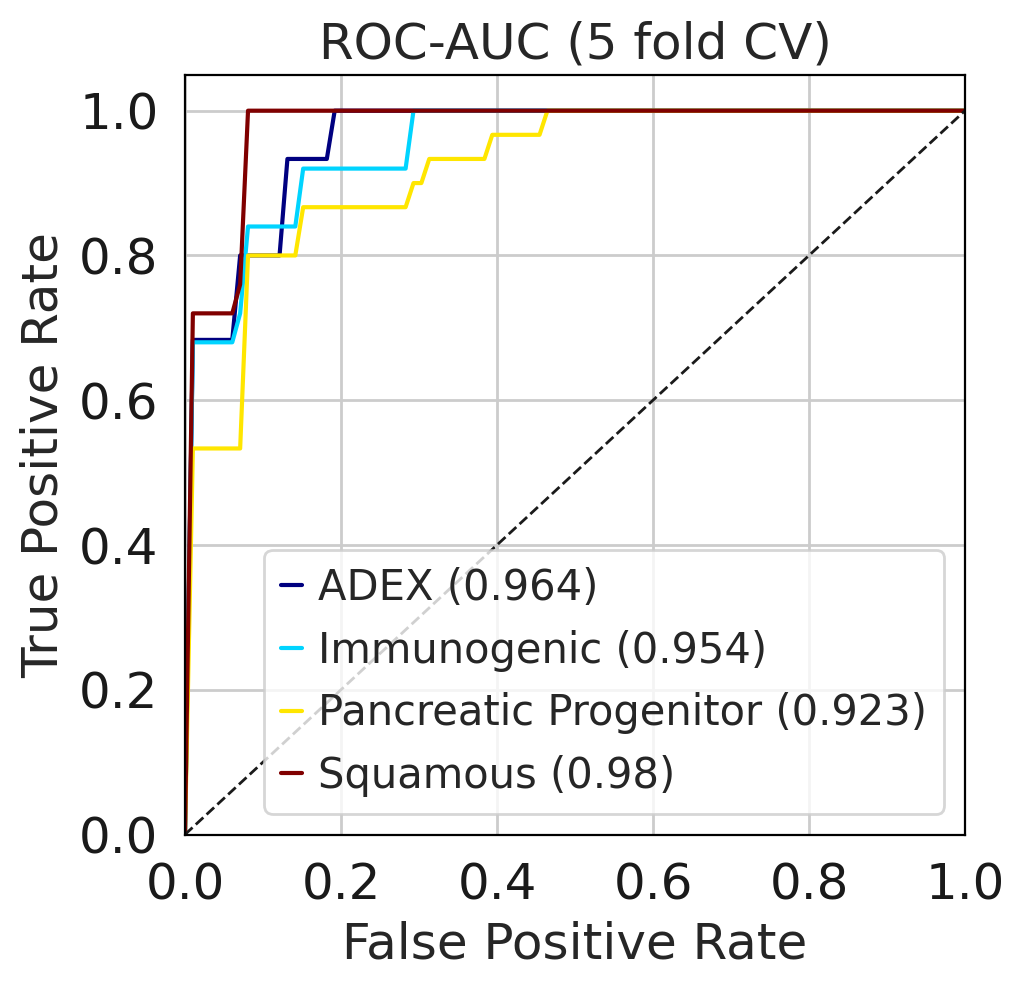

In [529]:
draw_AUC_curve_multi(X,y,model)

In [530]:
X_test = scaled_df.loc[test_idx,:]
y_test = list(model.predict(X_test))
tmp = pd.DataFrame(model.predict_proba(X_test)).idxmax(axis=1).to_frame('argmax')
tmp['type'] = y_test
tmp

argmax                   type
0        3               Squamous
1        0                   ADEX
2        2  Pancreatic Progenitor
3        3               Squamous
4        2  Pancreatic Progenitor
..     ...                    ...
88       0                   ADEX
89       1            Immunogenic
90       2  Pancreatic Progenitor
91       1            Immunogenic
92       0                   ADEX

[93 rows x 2 columns]

In [531]:
X_test

FAM160A2     RUNX2    LMAN2L       PPY      TGFA    IL1RAP  \
20-T00330_FO-01-0 -0.797161  0.665560 -0.418397  2.453826  0.283950 -1.049564   
19-T00062_FO-01-0 -0.989968  0.272050 -1.941989 -0.503011 -1.198974 -0.484397   
20-T00814_FT-01-0  2.485003 -0.992591 -1.270598  0.529700 -0.388874  0.302280   
19-T00201_FO-01-0 -0.143578  1.344439  0.748462 -0.503011  1.181435  1.279306   
19-T00505_FO-01-0  0.582411  1.096849 -0.045374  2.801750  0.714587  0.571052   
...                     ...       ...       ...       ...       ...       ...   
21-T00576_FT-01-0  0.121429  0.137959 -0.215633  0.416769 -0.710979  0.079397   
19-T00620_FO-01-0 -2.298616 -0.475292  0.241062 -0.503011 -0.951864 -0.219271   
19-T00413_FO-01-0  1.887019 -0.797943 -0.403879 -0.503011 -1.584970  0.072410   
20-T00073_FO-01-0 -1.339538  0.751159 -2.128089 -0.503011 -1.630010  0.477803   
19-T00119_FO-01-0 -0.215378 -2.331358 -0.128637  2.130577 -2.077783 -2.322598   

                      CELF3      MCM8     TRIQK    WNT10A  ...  C1orf226  \
20-T00330_FO-01-0  0.228897 -0.471662 -1.425613  1.865734  ...  0.454905   
19-T00062_FO-01-0 -0.609599 -1.165420 -1.569059  0.575930  ... -1.653532   
20-T00814_FT-01-0 -0.609599 -1.573352  0.345763 -1.147402  ...  0.796747   
19-T00201_FO-01-0  0.173157  0.705937  1.190672  0.660839  ...  0.454004   
19-T00505_FO-01-0  0.312274 -0.094249 -0.147427 -0.394773  ...  0.826874   
...                     ...       ...       ...       ...  ...       ...   
21-T00576_FT-01-0  1.231691 -0.816203 -0.303336 -1.194885  ... -0.089623   
19-T00620_FO-01-0  0.702170  1.441998  0.273516 -1.155848  ... -0.007417   
19-T00413_FO-01-0  0.165012 -0.971478  0.852880 -0.208830  ...  1.287261   
20-T00073_FO-01-0 -0.609599 -0.888536 -2.316467 -0.577951  ... -1.428414   
19-T00119_FO-01-0 -0.609599  0.872090 -1.005470 -1.809605  ... -0.633907   

                      HDAC7     RBM47    PTPRN2   FAM217B     APBB2     KLHL3  \
20-T00330_FO-01-0  0.261444 -0.857358 -1.273586 -0.881517 -1.113675 -1.041399   
19-T00062_FO-01-0 -0.573603 -1.935053 -0.283599 -0.300846  0.117497 -0.405733   
20-T00814_FT-01-0  0.739607  0.804095  1.029032  1.942930 -0.361752  1.083018   
19-T00201_FO-01-0  1.577282  1.136934  0.812759  1.819983  0.903769  1.425583   
19-T00505_FO-01-0  0.920408  0.109016  1.059623  1.498645 -0.679780  1.314759   
...                     ...       ...       ...       ...       ...       ...   
21-T00576_FT-01-0 -2.096865 -0.476383 -0.135883 -1.889322 -1.219867 -0.829321   
19-T00620_FO-01-0 -0.325677 -0.103013 -0.530834  2.189989  0.032813 -1.375152   
19-T00413_FO-01-0  1.742775  0.812412  0.785069  1.673439 -0.359636  1.221926   
20-T00073_FO-01-0 -0.035019 -1.370831 -1.728803  0.052477 -1.607894  0.499215   
19-T00119_FO-01-0 -0.186224 -0.985441  0.299895  0.579530 -0.278362  1.610056   

                      EEPD1      USP7     PRKCB  
20-T00330_FO-01-0 -1.789749 -0.797851  0.182160  
19-T00062_FO-01-0 -2.380169 -2.156463  0.173387  
20-T00814_FT-01-0  0.698487 -2.004556 -0.825514  
19-T00201_FO-01-0  0.155394  1.217253 -1.859877  
19-T00505_FO-01-0  0.309222 -0.687226 -0.411042  
...                     ...       ...       ...  
21-T00576_FT-01-0 -0.368429 -1.807396  0.940822  
19-T00620_FO-01-0  1.731301 -0.678382  0.180410  
19-T00413_FO-01-0  0.883099  1.737221 -1.082744  
20-T00073_FO-01-0 -2.404809  0.844302  2.994431  
19-T00119_FO-01-0 -0.703659 -0.731840  0.792480  

[93 rows x 4810 columns]

In [532]:
mg_adata_bec.obs['Bailey-type'].loc[X_test.index] = y_test
mg_adata_bec.obs

N0         PID       dateA         Snubh_BB  \
20-T00330_FO-01-0  sb2441  32644755.0  2020-05-15  20-B01156_EB-03   
19-T00062_FO-01-0  sb1947  10108754.0  2019-03-18  19-B00635_EB-03   
20-T00814_FT-01-0  sb2669  33563897.0  2020-12-16  20-B04522_EB-04   
19-T00201_FO-01-0  sb2097  24118798.0  2019-05-27              NaN   
19-T00505_FO-01-0  sb2298  31651231.0  2019-09-09  19-B02081_EB-03   
...                   ...         ...         ...              ...   
ICGC_0507-1           NaN         NaN         NaN              NaN   
ICGC_0521-1           NaN         NaN         NaN              NaN   
ICGC_0522-1           NaN         NaN         NaN              NaN   
ICGC_0526-1           NaN         NaN         NaN              NaN   
ICGC_0543-1           NaN         NaN         NaN              NaN   

                  pathology_number tumorcellularity(pathology)  DNA_RNA  \
20-T00330_FO-01-0      S 200019390                          25  DNA+RNA   
19-T00062_FO-01-0      S 190013089                          45  DNA+RNA   
20-T00814_FT-01-0      S 200053444                          35  DNA+RNA   
19-T00201_FO-01-0      S 190025387                          40      RNA   
19-T00505_FO-01-0      S 190043830                          50  DNA+RNA   
...                            ...                         ...      ...   
ICGC_0507-1                    NaN                         NaN      NaN   
ICGC_0521-1                    NaN                         NaN      NaN   
ICGC_0522-1                    NaN                         NaN      NaN   
ICGC_0526-1                    NaN                         NaN      NaN   
ICGC_0543-1                    NaN                         NaN      NaN   

                   methylSeq  metagenomic liquid_number  ...         Country  \
20-T00330_FO-01-0        NaN          NaN          R167  ...             NaN   
19-T00062_FO-01-0        NaN          NaN           NaN  ...             NaN   
20-T00814_FT-01-0        NaN          NaN          R201  ...             NaN   
19-T00201_FO-01-0        NaN          NaN          R017  ...             NaN   
19-T00505_FO-01-0        NaN          NaN          R074  ...             NaN   
...                      ...          ...           ...  ...             ...   
ICGC_0507-1              NaN          NaN           NaN  ...  United Kingdom   
ICGC_0521-1              NaN          NaN           NaN  ...  United Kingdom   
ICGC_0522-1              NaN          NaN           NaN  ...  United Kingdom   
ICGC_0526-1              NaN          NaN           NaN  ...  United Kingdom   
ICGC_0543-1              NaN          NaN           NaN  ...       Australia   

                            Smoker                   Tumour Grade  \
20-T00330_FO-01-0              NaN                            NaN   
19-T00062_FO-01-0              NaN                            NaN   
20-T00814_FT-01-0              NaN                            NaN   
19-T00201_FO-01-0              NaN                            NaN   
19-T00505_FO-01-0              NaN                            NaN   
...                            ...                            ...   
ICGC_0507-1         Not documented  2 - Moderately differentiated   
ICGC_0521-1         Not documented  2 - Moderately differentiated   
ICGC_0522-1         Not documented      3 - Poorly differentiated   
ICGC_0526-1         Not documented      3 - Poorly differentiated   
ICGC_0543-1        Stopped Smoking                 Not documented   

                                       HistoSubtype Tumour Location  \
20-T00330_FO-01-0                               NaN             NaN   
19-T00062_FO-01-0                               NaN             NaN   
20-T00814_FT-01-0                               NaN             NaN   
19-T00201_FO-01-0                               NaN             NaN   
19-T00505_FO-01-0                               NaN             NaN   
...                                             ...             .

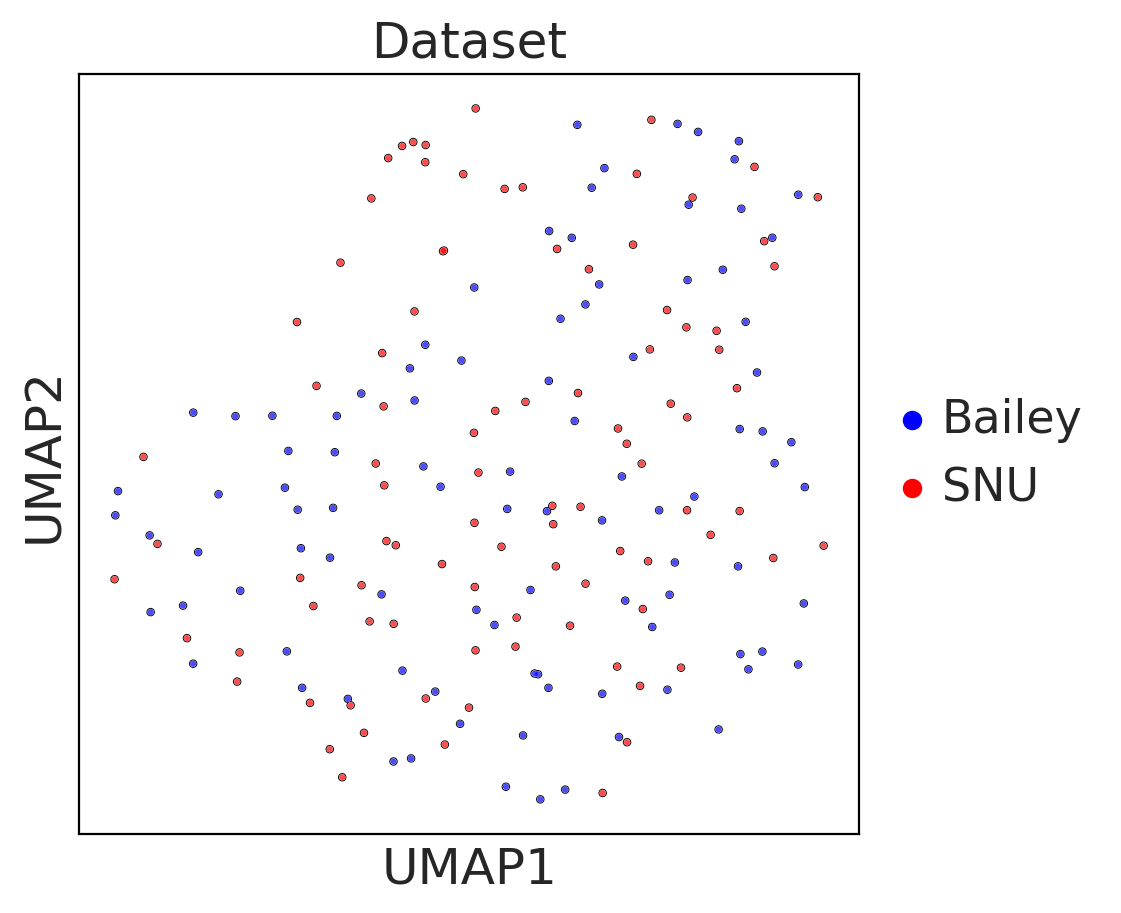

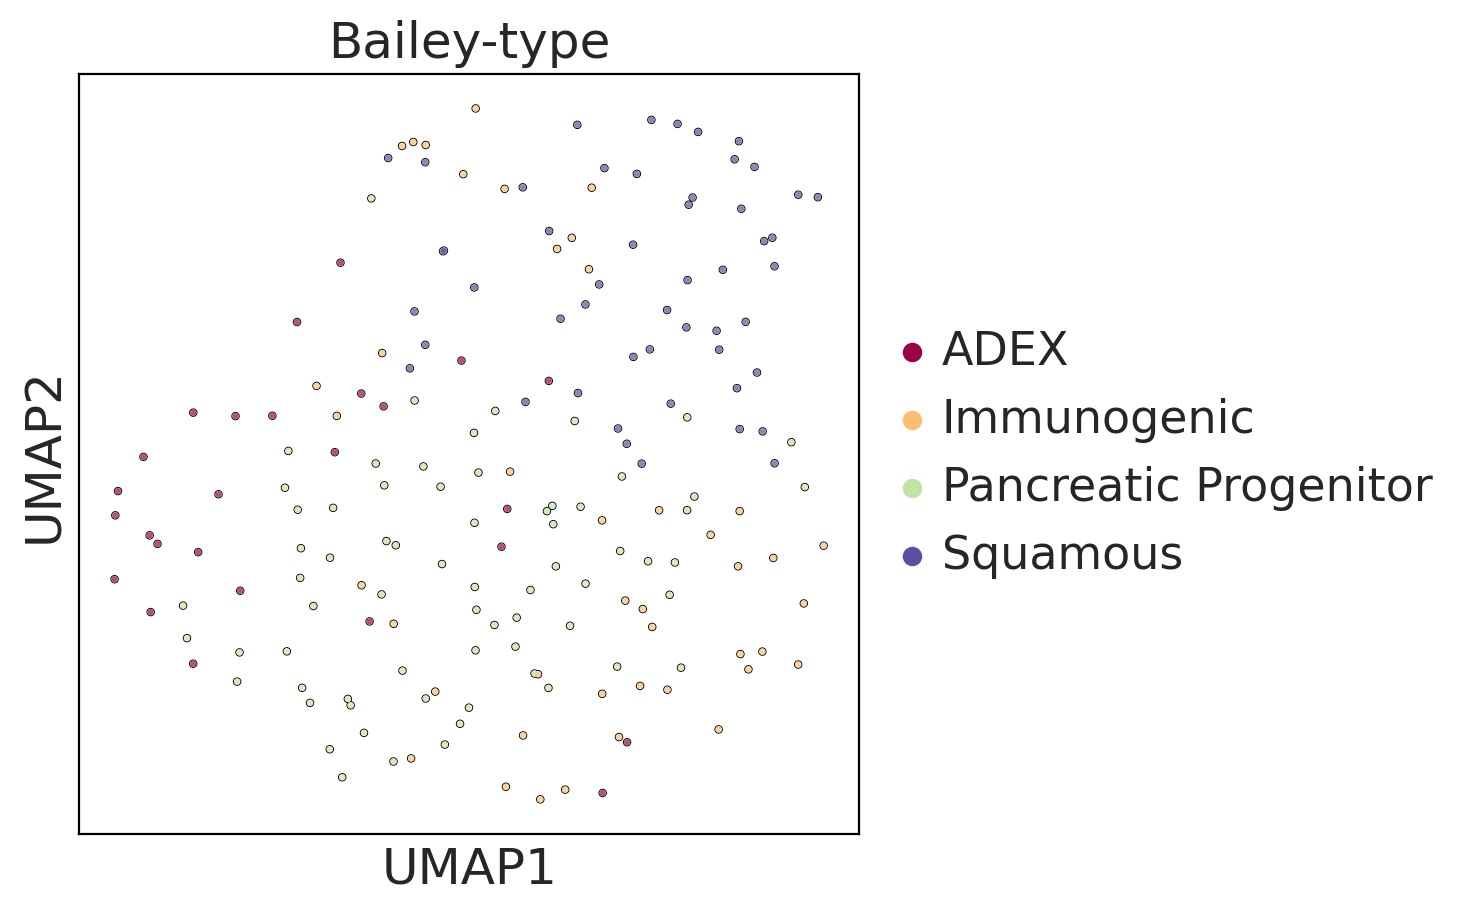

In [533]:
N_pca = 30
sc.tl.pca(mg_adata_bec, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(mg_adata_bec, n_neighbors=30, n_pcs=N_pca)
sc.tl.umap(mg_adata_bec)

sc.pl.umap(mg_adata_bec, color=['Dataset'], palette='bwr', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))
sc.pl.umap(mg_adata_bec, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

In [534]:
mg_adata_bec.obs['Bailey-type-EL'] = mg_adata_bec.obs['Bailey-type'].copy()
mg_adata_bec.obs['Bailey-type-EL'].loc[test_idx] = y_test
mg_adata_bec.obs['Bailey-type-EL']

20-T00330_FO-01-0                 Squamous
19-T00062_FO-01-0                     ADEX
20-T00814_FT-01-0    Pancreatic Progenitor
19-T00201_FO-01-0                 Squamous
19-T00505_FO-01-0    Pancreatic Progenitor
                             ...          
ICGC_0507-1          Pancreatic Progenitor
ICGC_0521-1                       Squamous
ICGC_0522-1                       Squamous
ICGC_0526-1                    Immunogenic
ICGC_0543-1                       Squamous
Name: Bailey-type-EL, Length: 189, dtype: category
Categories (4, object): ['ADEX', 'Immunogenic', 'Pancreatic Progenitor', 'Squamous']

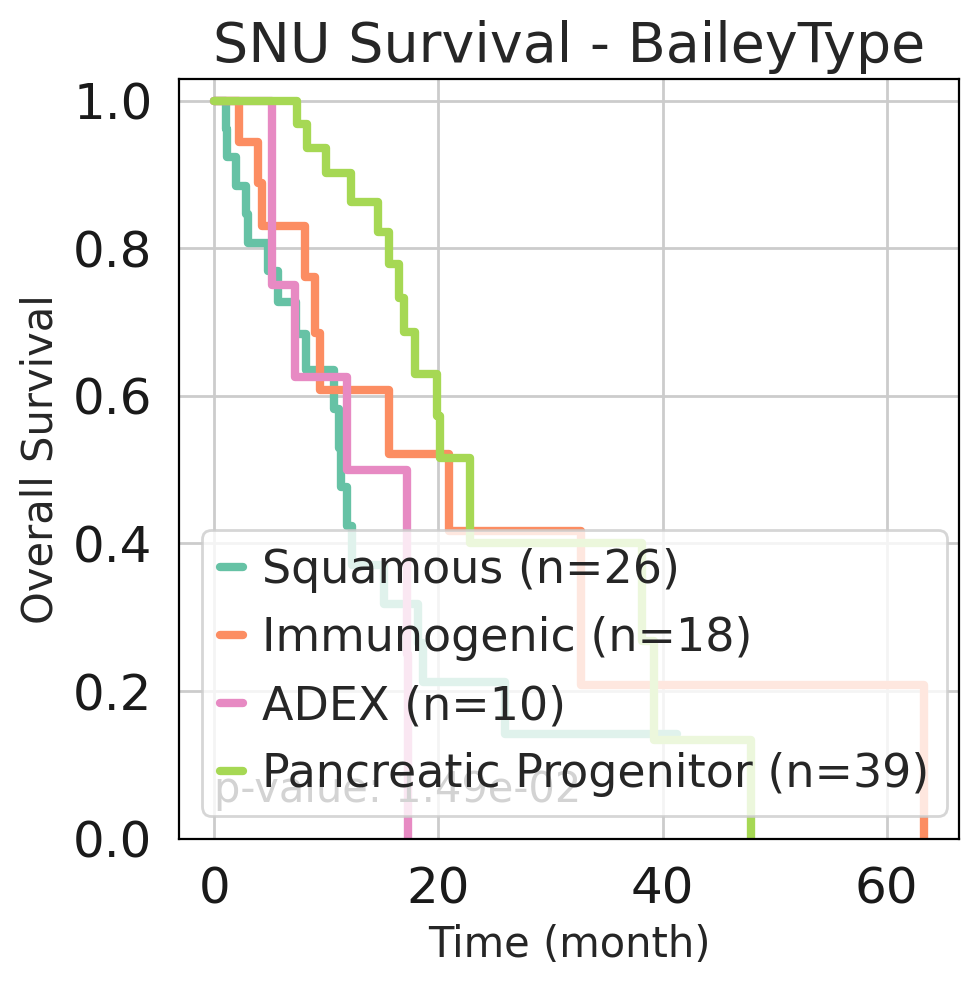

'1.49e-02'

In [535]:
m = mg_adata_bec.obs['Dataset'] == 'SNU'
SNU_sel = mg_adata_bec[m]
snu_df1 = SNU_sel.obs.copy()
km_plot(df_info=snu_df1, category='Bailey-type-EL', os='OS_F', event='OS_event', title='SNU Survival - BaileyType')

# Bailey Only 2 type (Pancreatic Progenitor and Squamous)

In [32]:
SNU_adata = sc.read_h5ad('SNU_AnnDataForm_20220519.h5ad')
SNU_adata.obs['Dataset'] = 'SNU'
SNU_genes = list(SNU_adata.to_df().columns)
print(len(SNU_genes))
sc.pp.log1p(SNU_adata)

# TCGA_adata = sc.read_h5ad('TCGA_TPM_AnnDataForm.h5ad')
# TCGA_adata.obs['Dataset'] = 'TCGA'
# sc.pp.log1p(TCGA_adata)
# TCGA_genes = list(TCGA_adata.to_df().columns)

Bailey_adata = sc.read_h5ad('Bailey_TPM_norm_AnnDataForm.h5ad')
Bailey_adata.obs['Dataset'] = 'Bailey'
Bailey_genes = list(Bailey_adata.to_df().columns)
print(len(Bailey_genes))

common_genes_all = list(set(SNU_genes)&set(Bailey_genes))
print(len(common_genes_all))

19987
18077
15420


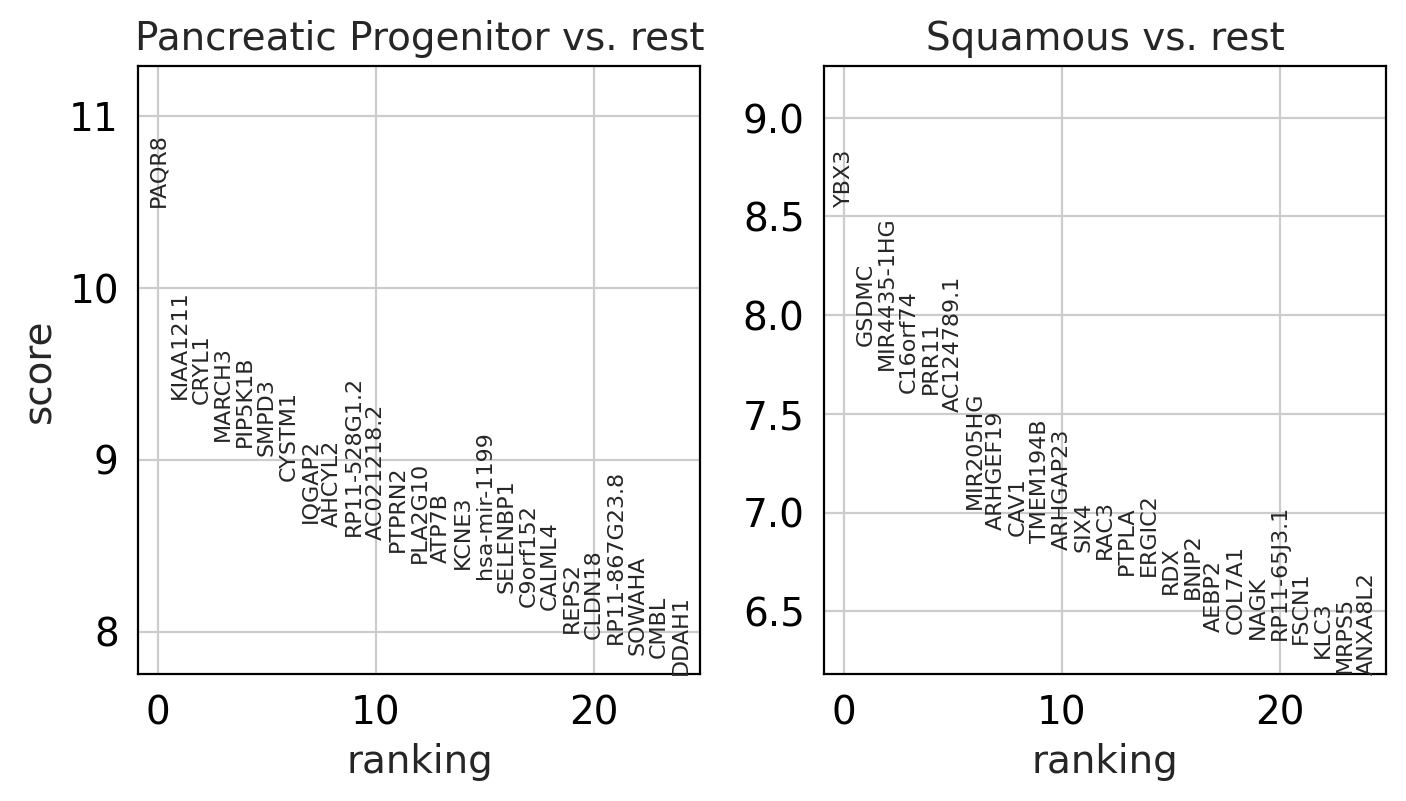

total genes: 3702


In [33]:
sc.settings.set_figure_params(dpi=100)
m = Bailey_adata.obs['Bailey-type'].isin(['Pancreatic Progenitor', 'Squamous'])
Bailey_adata = Bailey_adata[m,:]
sc.tl.rank_genes_groups(Bailey_adata, 'Bailey-type', method='t-test')
sc.pl.rank_genes_groups(Bailey_adata, n_genes=25, sharey=False, ncols=2, wspace=0.5)

test_method = 't-test' # wilcoxon / t-test
target_group = 'Bailey-type'
groups = ['Pancreatic Progenitor', 'Squamous']
test = groups[0]
control = groups[1]
sc.tl.rank_genes_groups(Bailey_adata, target_group, groups=[test], reference=control, method=test_method)
result = Bailey_adata.uns['rank_genes_groups']
df_deg = pd.DataFrame( index = result['names'][test] )
for key in ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']:
    df_deg[key] = result[key][test]
#df_wilcoxon.columns = ['logfoldchanges', 'wilcoxon-pvals', 'wilcoxon-pvals_adj', 'wilcoxon-scores']
df_deg = df_deg.sort_values(by='pvals')

threshold = 0.05
m = df_deg['pvals_adj'] < threshold
df_deg = df_deg[m]
total_unique = list(df_deg.index)
print('total genes: {}'.format(len(total_unique)))

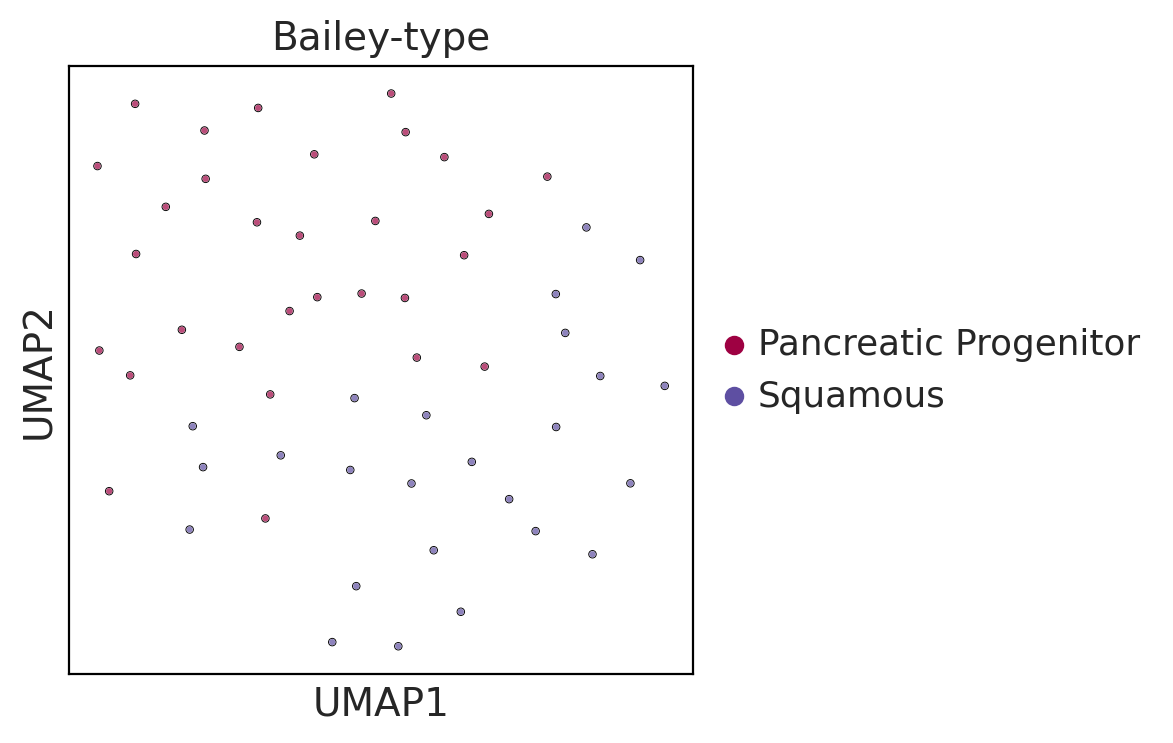

In [34]:
Bailey_adata
N_pca = 40
sc.tl.pca(Bailey_adata, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(Bailey_adata, n_neighbors=20, n_pcs=N_pca)
sc.tl.umap(Bailey_adata)
sc.pl.umap(Bailey_adata, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

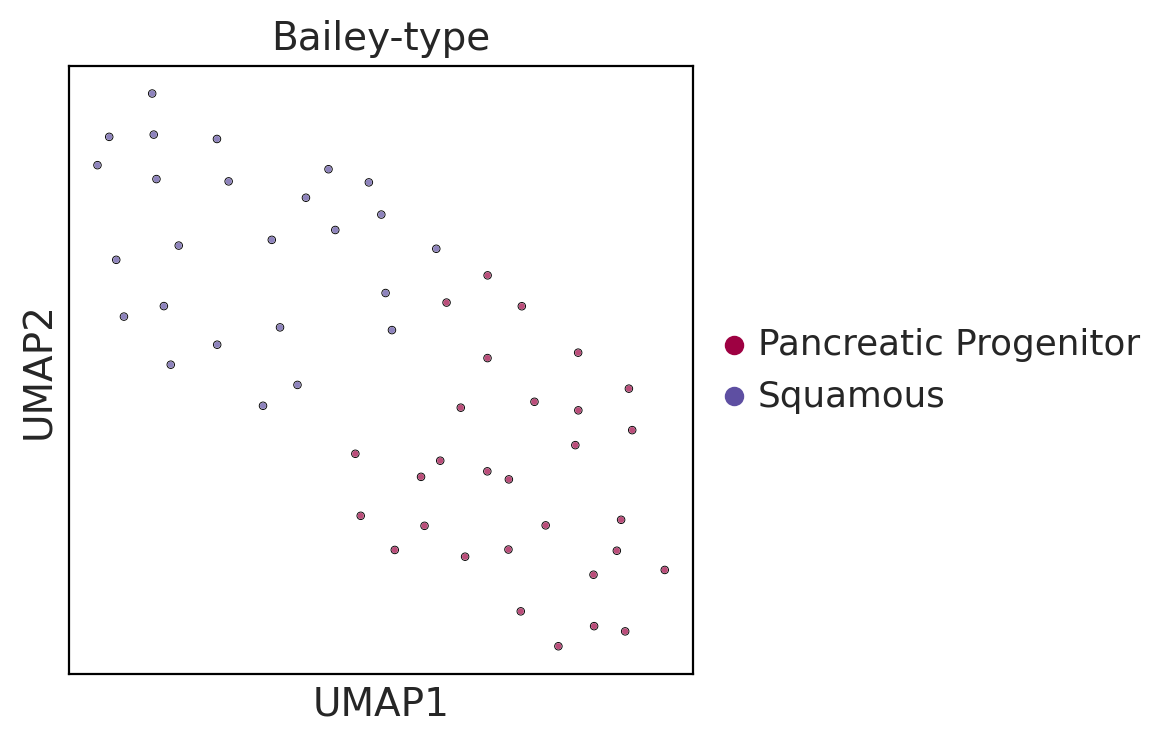

In [35]:
Bailey_adata_sel = Bailey_adata[:,total_unique]



# sc.pp.highly_variable_genes(Bailey_adata_sel,n_top_genes=1000)
# Bailey_adata_HVG = SNU_adata[:,Bailey_adata_sel.var.highly_variable]
# sc.tl.pca(Bailey_adata_HVG, svd_solver='arpack', n_comps = 20)
# sc.pp.neighbors(Bailey_adata_HVG, n_neighbors=5)

N_pca = 12
n_neighbors = 7
sc.tl.pca(Bailey_adata_sel, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(Bailey_adata_sel, n_neighbors=n_neighbors, n_pcs=N_pca)
sc.tl.umap(Bailey_adata_sel)
sc.pl.umap(Bailey_adata_sel, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

In [36]:
features = list(set(common_genes_all)&set(total_unique))
print(len(features))
mg_adata = SNU_adata[:,features].concatenate(Bailey_adata[:,features])
mg_adata.to_df()

3417


ICK    PKMYT1     MRPS5     DUSP8    PTPRN2   IFITM10  \
20-T00330_FO-01-0  2.135349  1.853168  3.181382  1.534714  1.244155  3.162094   
19-T00062_FO-01-0  1.795087  1.199965  2.930660  0.858662  2.388763  1.470176   
20-T00814_FT-01-0  2.388763  3.289521  3.243763  1.900614  3.906407  0.993252   
19-T00201_FO-01-0  2.596746  3.505257  3.853970  1.536867  3.656356  2.106570   
19-T00505_FO-01-0  2.389680  1.576915  3.888754  2.590767  3.941776  1.141033   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0518-1        5.205132  2.523276  4.844659  3.289335  5.685454  1.270287   
ICGC_0507-1        5.587638  0.932651  4.912928  2.328151  6.086920  1.854099   
ICGC_0521-1        5.265754  1.330574  4.910418  1.884937  3.364271  2.184839   
ICGC_0522-1        4.577578  2.894958  4.715846  1.892860  4.223403  0.820287   
ICGC_0543-1        5.182299  3.605593  5.197027  1.752633  1.376407  2.259866   

                      KIFC3     YIF1B   FAM102B      TIFA  ...      HHEX  \
20-T00330_FO-01-0  4.969049  2.716018  1.621367  2.328253  ...  1.621367   
19-T00062_FO-01-0  3.197856  2.094330  1.994700  1.631199  ...  1.947338   
20-T00814_FT-01-0  4.857717  2.800933  2.756205  1.286474  ...  1.788421   
19-T00201_FO-01-0  5.037148  3.135494  2.939162  1.842136  ...  1.750937   
19-T00505_FO-01-0  4.228730  3.051167  2.369309  1.553925  ...  2.543961   
...                     ...       ...       ...       ...  ...       ...   
ICGC_0518-1        4.750118  2.917123  5.679130  2.310848  ...  2.398265   
ICGC_0507-1        4.051429  2.401700  5.348797  2.389974  ...  3.381216   
ICGC_0521-1        4.980377  2.779894  5.035299  3.119536  ...  1.742995   
ICGC_0522-1        5.607916  3.424836  4.425006  1.635687  ...  2.051365   
ICGC_0543-1        5.018108  3.985393  5.802577  3.569741  ...  1.335973   

                      TTC22    PIK3CB     SYTL3       PGC     HJURP    CYP3A4  \
20-T00330_FO-01-0  3.248435  3.132882  2.243896  0.802002  1.410987  3.011606   
19-T00062_FO-01-0  2.424803  2.809403  1.903599  1.750937  1.862529  1.530395   
20-T00814_FT-01-0  4.047952  4.311202  1.252763  1.947338  2.396075  0.343590   
19-T00201_FO-01-0  4.054564  4.216710  2.002831  1.033185  3.056357  0.576613   
19-T00505_FO-01-0  3.679082  3.895080  2.494857  3.034953  1.587192  1.061257   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0518-1        3.296681  6.339474  1.753901 -2.216157  3.784590 -0.745900   
ICGC_0507-1        4.369148  5.241957  1.603598  5.852665  2.135508  1.268772   
ICGC_0521-1        4.093831  5.538215  1.904139 -0.056746  3.158138 -1.944039   
ICGC_0522-1        3.307225  5.438433  2.729640 -0.532600  3.594641  1.267123   
ICGC_0543-1        3.268193  4.877558  2.216969 -1.253819  4.386376 -3.873616   

                     PSAPL1   BCL2L14   PHYHIPL  
20-T00330_FO-01-0  0.058269  2.463002  0.683097  
19-T00062_FO-01-0  0.425268  1.512927  0.652325  
20-T00814_FT-01-0  0.173953  2.824944  0.412110  
19-T00201_FO-01-0  0.300105  3.097386  0.000000  
19-T00505_FO-01-0  0.609766  3.343215  0.667829  
...                     ...       ...       ...  
ICGC_0518-1        5.176229  2.984663 -0.726659  
ICGC_0507-1        0.860751  3.742453  1.319000  
ICGC_0521-1       -3.133639  2.775862 -6.391962  
ICGC_0522-1       -6.874409  2.033489 -1.319044  
ICGC_0543-1       -2.285110  0.773783 -3.793078  

[148 rows x 3417 columns]

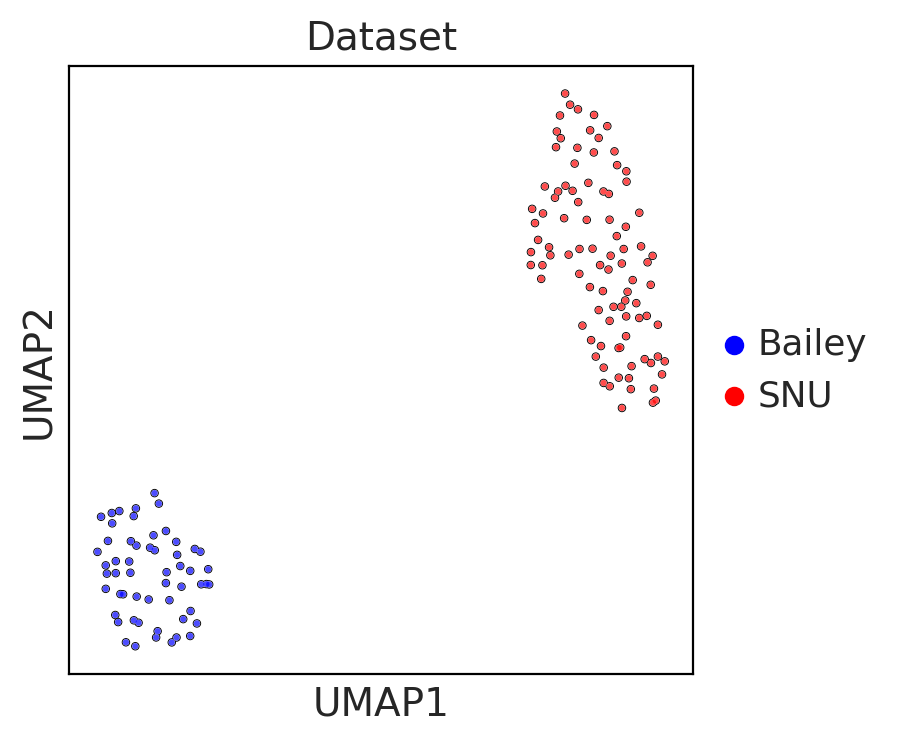

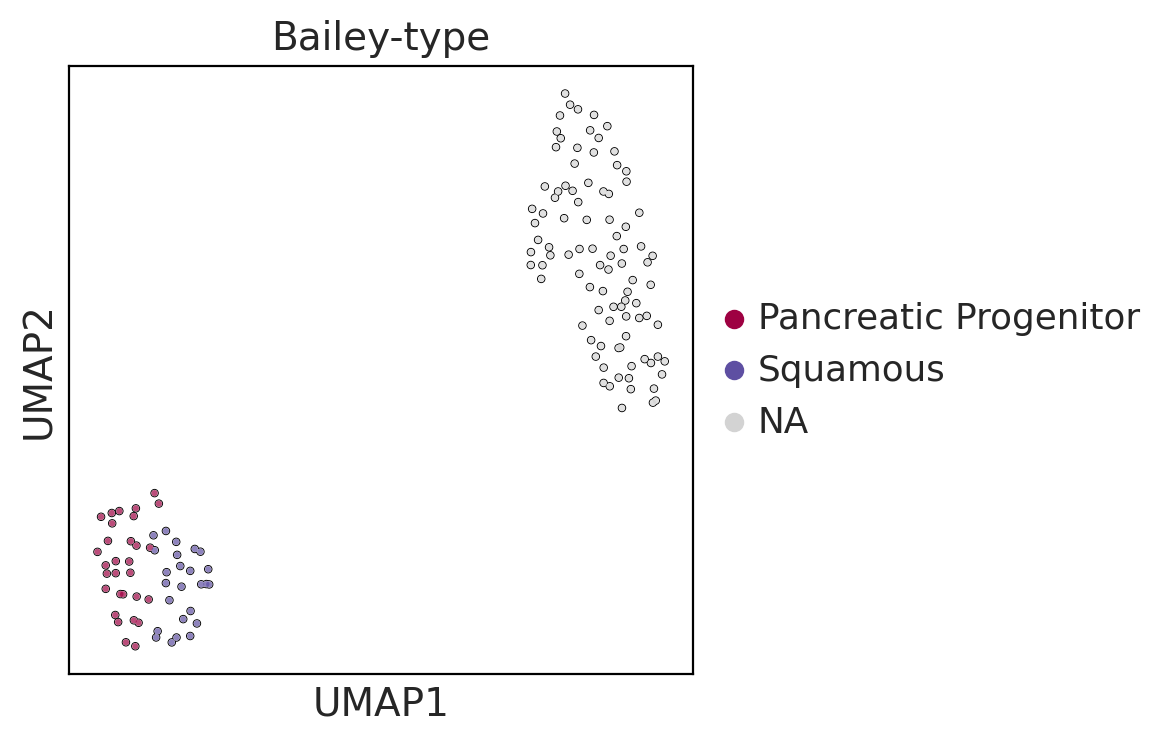

In [624]:
N_pca = 40
sc.tl.pca(mg_adata, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(mg_adata, n_neighbors=20, n_pcs=N_pca)
sc.tl.umap(mg_adata)
sc.pl.umap(mg_adata, color=['Dataset'], palette='bwr', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))
sc.pl.umap(mg_adata, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

# ComBat

In [625]:
df_exp_all = mg_adata.to_df().T
batch = list(mg_adata.obs['Dataset'].values)
df_corrected = pycombat(df_exp_all,batch).T
mg_adata_bec = sc.AnnData(df_corrected)
mg_adata_bec.obs = mg_adata.obs.copy()
mg_adata_bec.to_df()

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


FAM160A2     RUNX2    LMAN2L    IL1RAP     CELF3     TRIQK  \
20-T00330_FO-01-0  4.046631  3.455044  2.875763  3.794912 -0.137750  3.193224   
19-T00062_FO-01-0  3.933424  3.175462  2.117547  4.188657 -1.347392  3.113924   
20-T00814_FT-01-0  5.973761  2.276959  2.451665  4.736727 -1.347392  4.172493   
19-T00201_FO-01-0  4.430384  3.937375  3.456451  5.417410 -0.218161  4.639582   
19-T00505_FO-01-0  4.856650  3.761466  3.061398  4.923977 -0.017467  3.899842   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0518-1        4.482657  3.261479  3.037834  4.057162 -0.589875  4.614642   
ICGC_0507-1        4.490463  2.901797  2.828550  3.234190  0.027002  4.295206   
ICGC_0521-1        5.041321  4.385925  3.192437  4.913103 -2.579566  3.821173   
ICGC_0522-1        5.555536  3.173137  2.521926  3.479129 -0.354457  2.793108   
ICGC_0543-1        3.806420  3.510894  3.802289  5.493793 -3.053497  3.299056   

                     WNT10A      MCM8      MUC1    COL6A2  ...      KLF3  \
20-T00330_FO-01-0  4.659105  2.406774  6.625603  5.975594  ...  4.629607   
19-T00062_FO-01-0  2.881848  2.057553  5.879580  6.517061  ...  4.919885   
20-T00814_FT-01-0  0.507219  1.852210  7.384309  5.342721  ...  5.079905   
19-T00201_FO-01-0  2.998847  2.999548  7.290975  5.761352  ...  5.636443   
19-T00505_FO-01-0  1.544289  2.596754  7.427976  5.486617  ...  5.630601   
...                     ...       ...       ...       ...  ...       ...   
ICGC_0518-1        1.507670  2.938814  7.643897  5.506061  ...  5.986374   
ICGC_0507-1        0.396611  1.987285  6.882319  6.313884  ...  5.297608   
ICGC_0521-1        3.136848  2.734641  7.732466  6.346247  ...  5.189723   
ICGC_0522-1        2.957815  2.860742  6.812646  6.228400  ...  4.231803   
ICGC_0543-1        1.921165  3.665135  3.927583  6.874567  ...  5.274851   

                     LRRC17       CIT  C1orf226     RBM47    PTPRN2     APBB2  \
20-T00330_FO-01-0  2.148014  2.817565  2.948671  4.729059  1.871022  3.783929   
19-T00062_FO-01-0  2.094189  2.636325  1.294099  4.165939  3.149590  4.439975   
20-T00814_FT-01-0  2.247146  2.600347  3.216928  5.597205  4.844853  4.184601   
19-T00201_FO-01-0  2.408563  4.023435  2.947964  5.771121  4.565537  4.858951   
19-T00505_FO-01-0  0.251819  3.412501  3.240570  5.234010  4.884361  4.015135   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0518-1        0.091685  2.888953  2.840099  5.840294  4.225084  4.354862   
ICGC_0507-1        1.341956  2.876313  3.340830  5.094937  4.573045  4.707686   
ICGC_0521-1        2.599196  2.837520  3.876949  5.037008  2.213254  4.238746   
ICGC_0522-1        1.993385  3.420899  2.225059  4.014429  2.957886  4.483568   
ICGC_0543-1        1.954400  4.335861  0.725051  4.448647  0.490321  4.618228   

                      EEPD1    PPHLN1     CAPN6  
20-T00330_FO-01-0  2.611069  3.826942 -0.036549  
19-T00062_FO-01-0  2.265426  3.738408  1.088794  
20-T00814_FT-01-0  4.067728  3.941270 -0.131474  
19-T00201_FO-01-0  3.749791  4.432529  0.534029  
19-T00505_FO-01-0  3.839845  4.310693  0.670851  
...                     ...       ...       ...  
ICGC_0518-1        4.372189  3.867463  1.632761  
ICGC_0507-1        4.410077  4.389142  2.567787  
ICGC_0521-1        2.387193  4.796046  0.821829  
ICGC_0522-1        4.074049  4.721914  1.085034  
ICGC_0543-1        2.148890  4.861378 -1.346768  

[148 rows x 3417 columns]

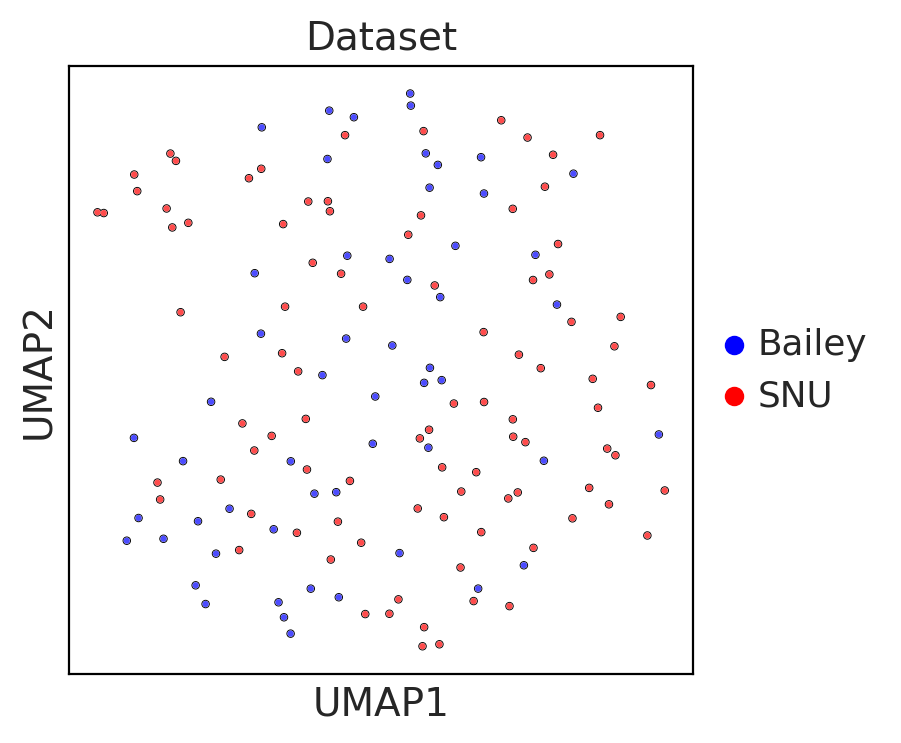

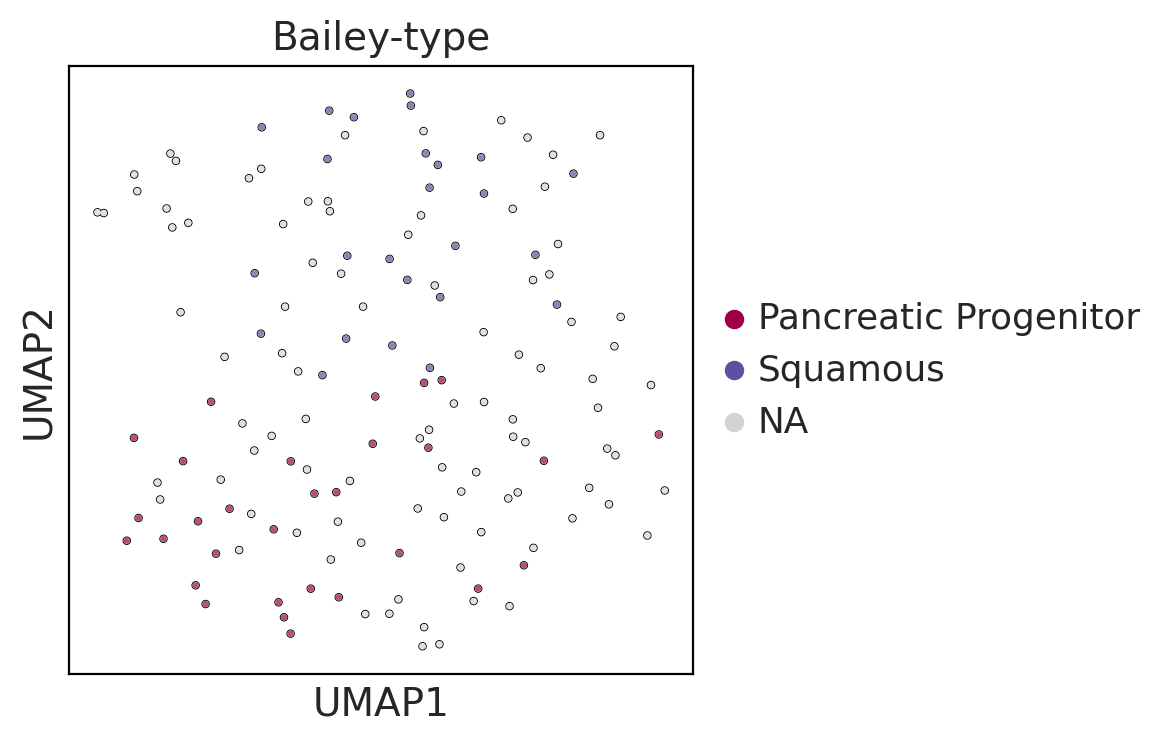

In [626]:
N_pca = 30
sc.tl.pca(mg_adata_bec, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(mg_adata_bec, n_neighbors=30, n_pcs=N_pca)
sc.tl.umap(mg_adata_bec)
sc.pl.umap(mg_adata_bec, color=['Dataset'], palette='bwr', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))
sc.pl.umap(mg_adata_bec, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

In [627]:
all_exp = mg_adata_bec.to_df()
all_exp

FAM160A2     RUNX2    LMAN2L    IL1RAP     CELF3     TRIQK  \
20-T00330_FO-01-0  4.046631  3.455044  2.875763  3.794912 -0.137750  3.193224   
19-T00062_FO-01-0  3.933424  3.175462  2.117547  4.188657 -1.347392  3.113924   
20-T00814_FT-01-0  5.973761  2.276959  2.451665  4.736727 -1.347392  4.172493   
19-T00201_FO-01-0  4.430384  3.937375  3.456451  5.417410 -0.218161  4.639582   
19-T00505_FO-01-0  4.856650  3.761466  3.061398  4.923977 -0.017467  3.899842   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0518-1        4.482657  3.261479  3.037834  4.057162 -0.589875  4.614642   
ICGC_0507-1        4.490463  2.901797  2.828550  3.234190  0.027002  4.295206   
ICGC_0521-1        5.041321  4.385925  3.192437  4.913103 -2.579566  3.821173   
ICGC_0522-1        5.555536  3.173137  2.521926  3.479129 -0.354457  2.793108   
ICGC_0543-1        3.806420  3.510894  3.802289  5.493793 -3.053497  3.299056   

                     WNT10A      MCM8      MUC1    COL6A2  ...      KLF3  \
20-T00330_FO-01-0  4.659105  2.406774  6.625603  5.975594  ...  4.629607   
19-T00062_FO-01-0  2.881848  2.057553  5.879580  6.517061  ...  4.919885   
20-T00814_FT-01-0  0.507219  1.852210  7.384309  5.342721  ...  5.079905   
19-T00201_FO-01-0  2.998847  2.999548  7.290975  5.761352  ...  5.636443   
19-T00505_FO-01-0  1.544289  2.596754  7.427976  5.486617  ...  5.630601   
...                     ...       ...       ...       ...  ...       ...   
ICGC_0518-1        1.507670  2.938814  7.643897  5.506061  ...  5.986374   
ICGC_0507-1        0.396611  1.987285  6.882319  6.313884  ...  5.297608   
ICGC_0521-1        3.136848  2.734641  7.732466  6.346247  ...  5.189723   
ICGC_0522-1        2.957815  2.860742  6.812646  6.228400  ...  4.231803   
ICGC_0543-1        1.921165  3.665135  3.927583  6.874567  ...  5.274851   

                     LRRC17       CIT  C1orf226     RBM47    PTPRN2     APBB2  \
20-T00330_FO-01-0  2.148014  2.817565  2.948671  4.729059  1.871022  3.783929   
19-T00062_FO-01-0  2.094189  2.636325  1.294099  4.165939  3.149590  4.439975   
20-T00814_FT-01-0  2.247146  2.600347  3.216928  5.597205  4.844853  4.184601   
19-T00201_FO-01-0  2.408563  4.023435  2.947964  5.771121  4.565537  4.858951   
19-T00505_FO-01-0  0.251819  3.412501  3.240570  5.234010  4.884361  4.015135   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0518-1        0.091685  2.888953  2.840099  5.840294  4.225084  4.354862   
ICGC_0507-1        1.341956  2.876313  3.340830  5.094937  4.573045  4.707686   
ICGC_0521-1        2.599196  2.837520  3.876949  5.037008  2.213254  4.238746   
ICGC_0522-1        1.993385  3.420899  2.225059  4.014429  2.957886  4.483568   
ICGC_0543-1        1.954400  4.335861  0.725051  4.448647  0.490321  4.618228   

                      EEPD1    PPHLN1     CAPN6  
20-T00330_FO-01-0  2.611069  3.826942 -0.036549  
19-T00062_FO-01-0  2.265426  3.738408  1.088794  
20-T00814_FT-01-0  4.067728  3.941270 -0.131474  
19-T00201_FO-01-0  3.749791  4.432529  0.534029  
19-T00505_FO-01-0  3.839845  4.310693  0.670851  
...                     ...       ...       ...  
ICGC_0518-1        4.372189  3.867463  1.632761  
ICGC_0507-1        4.410077  4.389142  2.567787  
ICGC_0521-1        2.387193  4.796046  0.821829  
ICGC_0522-1        4.074049  4.721914  1.085034  
ICGC_0543-1        2.148890  4.861378 -1.346768  

[148 rows x 3417 columns]

In [2]:
# from sklearn.model_selection import KFold
# from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, cross_val_predict
# from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
# from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
# from sklearn.svm import LinearSVR, SVR
# from sklearn.neighbors import KNeighborsRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_fscore_support
# from sklearn.metrics import confusion_matrix, auc, plot_roc_curve
# from sklearn import svm
# from sklearn.metrics import roc_curve, auc
# scaler = StandardScaler()
# lb = preprocessing.LabelBinarizer()

In [629]:
scaled_df = pd.DataFrame(scaler.fit_transform(all_exp), columns=all_exp.columns, index=all_exp.index)
scaled_df

FAM160A2     RUNX2    LMAN2L    IL1RAP     CELF3     TRIQK  \
20-T00330_FO-01-0 -0.797275  0.667050 -0.416359 -1.059805  0.243775 -1.416875   
19-T00062_FO-01-0 -0.990063  0.271573 -1.932818 -0.490324 -0.637406 -1.559519   
20-T00814_FT-01-0  2.484561 -0.999387 -1.264570  0.302360 -0.637406  0.344602   
19-T00201_FO-01-0 -0.143757  1.349322  0.745037  1.286846  0.185198  1.184788   
19-T00505_FO-01-0  0.582160  1.100494 -0.045082  0.573184  0.331397 -0.145833   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0518-1       -0.054737  0.393247 -0.092210 -0.680508 -0.085582  1.139926   
ICGC_0507-1       -0.041445 -0.115535 -0.510787 -1.870788  0.363790  0.565334   
ICGC_0521-1        0.896647  1.983810  0.217001  0.557456 -1.535001 -0.287340   
ICGC_0522-1        1.772338  0.268284 -1.124044 -1.516528  0.085912 -2.136592   
ICGC_0543-1       -1.206347  0.746052  1.436726  1.397319 -1.880242 -1.226509   

                     WNT10A      MCM8      MUC1    COL6A2  ...      KLF3  \
20-T00330_FO-01-0  1.891245 -0.473476  0.006543  0.213058  ... -1.702165   
19-T00062_FO-01-0  0.583553 -1.168630 -0.579387  0.717080  ... -0.943240   
20-T00814_FT-01-0 -1.163679 -1.577382  0.602433 -0.376048  ... -0.524873   
19-T00201_FO-01-0  0.669641  0.706492  0.529129  0.013632  ...  0.930183   
19-T00505_FO-01-0 -0.400612 -0.095303  0.636730 -0.242103  ...  0.914912   
...                     ...       ...       ...       ...  ...       ...   
ICGC_0518-1       -0.427556  0.585595  0.806315 -0.224004  ...  1.845071   
ICGC_0507-1       -1.245064 -1.308504  0.208168  0.527953  ...  0.044309   
ICGC_0521-1        0.771180  0.179173  0.875878  0.558078  ... -0.237754   
ICGC_0522-1        0.639450  0.430187  0.153447  0.448381  ... -2.742214   
ICGC_0543-1       -0.123310  2.031400 -2.112494  1.049861  ... -0.015189   

                     LRRC17       CIT  C1orf226     RBM47    PTPRN2     APBB2  \
20-T00330_FO-01-0  0.647777 -0.573385  0.458280 -0.862397 -1.264390 -1.107374   
19-T00062_FO-01-0  0.592656 -0.866231 -1.660801 -1.945844 -0.280550  0.117401   
20-T00814_FT-01-0  0.749296 -0.924364  0.801847  0.807923  1.023932 -0.359358   
19-T00201_FO-01-0  0.914600  1.375041  0.457374  1.142539  0.809002  0.899589   
19-T00505_FO-01-0 -1.294079  0.387904  0.832126  0.109134  1.054333 -0.675734   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0518-1       -1.458070 -0.458039  0.319226  1.275630  0.547028 -0.041497   
ICGC_0507-1       -0.177691 -0.478461  0.960533 -0.158445  0.814779  0.617193   
ICGC_0521-1        1.109823 -0.541143  1.647164 -0.269900 -1.001047 -0.258275   
ICGC_0522-1        0.489424  0.401473 -0.468481 -2.237352 -0.428063  0.198785   
ICGC_0543-1        0.449501  1.879855 -2.389604 -1.401913 -2.326820  0.450183   

                      EEPD1    PPHLN1     CAPN6  
20-T00330_FO-01-0 -1.816377 -1.412687 -0.849077  
19-T00062_FO-01-0 -2.415316 -1.677187 -0.054184  
20-T00814_FT-01-0  0.707757 -1.071131 -0.916128  
19-T00201_FO-01-0  0.156829  0.396520 -0.446045  
19-T00505_FO-01-0  0.312876  0.032533 -0.349401  
...                     ...       ...       ...  
ICGC_0518-1        1.235336 -1.291631  0.330051  
ICGC_0507-1        1.300989  0.266899  0.990512  
ICGC_0521-1       -2.204314  1.482539 -0.242756  
ICGC_0522-1        0.718710  1.261066 -0.056840  
ICGC_0543-1       -2.617251  1.677720 -1.774559  

[148 rows x 3417 columns]

In [630]:
Bailey_labels = mg_adata_bec.obs['Bailey-type'].to_frame('labels')
Bailey_labels

labels
20-T00330_FO-01-0                    NaN
19-T00062_FO-01-0                    NaN
20-T00814_FT-01-0                    NaN
19-T00201_FO-01-0                    NaN
19-T00505_FO-01-0                    NaN
...                                  ...
ICGC_0518-1        Pancreatic Progenitor
ICGC_0507-1        Pancreatic Progenitor
ICGC_0521-1                     Squamous
ICGC_0522-1                     Squamous
ICGC_0543-1                     Squamous

[148 rows x 1 columns]

In [631]:
train_idx = ~Bailey_labels['labels'].isna()
test_idx = ~train_idx

In [632]:
X = scaled_df.loc[train_idx,:]
y = Bailey_labels.loc[train_idx,:]
y = y['labels']
y

ICGC_0009-1                 Squamous
ICGC_0021-1                 Squamous
ICGC_0025-1                 Squamous
ICGC_0031-1    Pancreatic Progenitor
ICGC_0037-1                 Squamous
ICGC_0087-1    Pancreatic Progenitor
ICGC_0088-1    Pancreatic Progenitor
ICGC_0051-1    Pancreatic Progenitor
ICGC_0053-1    Pancreatic Progenitor
ICGC_0054-1                 Squamous
ICGC_0055-1    Pancreatic Progenitor
ICGC_0059-1    Pancreatic Progenitor
ICGC_0105-1    Pancreatic Progenitor
ICGC_0206-1                 Squamous
ICGC_0114-1                 Squamous
ICGC_0212-1    Pancreatic Progenitor
ICGC_0066-1    Pancreatic Progenitor
ICGC_0392-1                 Squamous
ICGC_0393-1                 Squamous
ICGC_0067-1                 Squamous
ICGC_0134-1                 Squamous
ICGC_0139-1    Pancreatic Progenitor
ICGC_0140-1    Pancreatic Progenitor
ICGC_0141-1                 Squamous
ICGC_0143-1    Pancreatic Progenitor
ICGC_0169-1                 Squamous
ICGC_0185-1    Pancreatic Progenitor
I

In [384]:
param_grid = {'C': np.arange(0.1,1.1,0.1),
             'l1_ratio': np.arange(0.1,1,0.1)}
model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', class_weight = 'balanced', multi_class='multinomial', 
                           max_iter = 5000, l1_ratio=0.1)
#model.fit(X,y)
# #SklearnClassifier(SVC(kernel='linear',probability=True))
# model = svm.SVC(kernel='linear', probability=True, class_weight='balanced')
# param_grid = {'C': np.arange(0.01,0.5,0.05)}
final_model = classification_model_training(model=model, param_grid=param_grid, X=X, y=y, title='')

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Estimator
LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.1, max_iter=5000,
                   multi_class='multinomial', penalty='elasticnet',
                   solver='saga')
cv score mean: 1.0


In [633]:
final_model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', class_weight = 'balanced', multi_class='multinomial', 
                           max_iter = 5000, l1_ratio=0.1,C=0.15)
final_model.fit(X,y)

LogisticRegression(C=0.15, class_weight='balanced', l1_ratio=0.1, max_iter=5000,
                   multi_class='multinomial', penalty='elasticnet',
                   solver='saga')

In [638]:
coeff_ = pd.DataFrame(final_model.coef_, columns=X.columns)
coeff_
m = coeff_.sum(axis=0) != 0
Bailey_PS_genes = list(coeff_.loc[:,m].columns)
coeff_.loc[:,m]

LY6D    TREH  RP11-295K3.1    CYSTM1      ACE2    DNAH17    MARCH3  \
0  0.002368 -0.0165      0.015863 -0.005242 -0.010807  0.014736 -0.039832   

     SEMA3G     CASP4  TNFRSF11A  ...    FAM3D   HMGCLL1      NASP      GOPC  \
0 -0.018445  0.001502  -0.012238  ... -0.00521 -0.006146  0.010128  0.009123   

      CLCN1     G6PC2     PRAME   SLC15A2      GBP5    PTPRN2  
0 -0.017042 -0.007481  0.015682  0.004333  0.002047 -0.019289  

[1 rows x 269 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


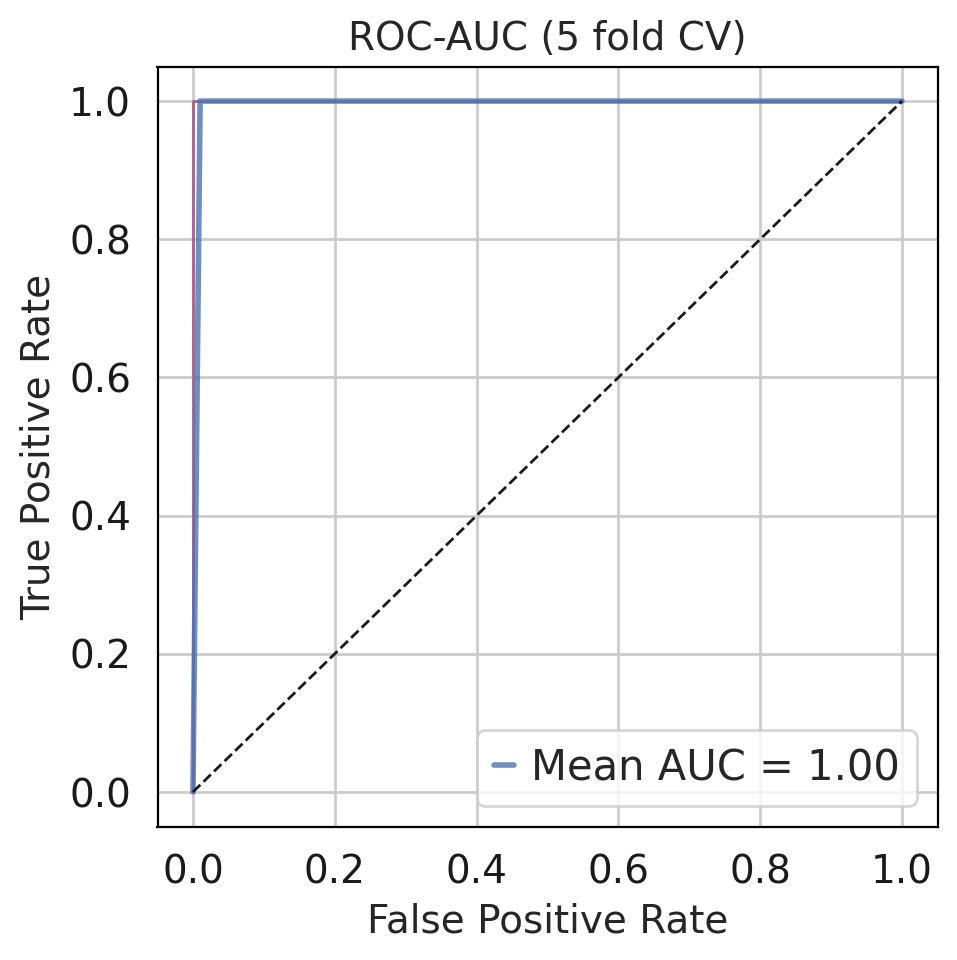

In [552]:
draw_AUC_curve_binary(X,y,final_model)

In [553]:
X_test = scaled_df.loc[test_idx,:]
y_test = list(final_model.predict(X_test))
tmp = pd.DataFrame(final_model.predict_proba(X_test)).idxmax(axis=1).to_frame('argmax')
tmp['type'] = y_test
tmp

argmax                   type
0        1               Squamous
1        1               Squamous
2        0  Pancreatic Progenitor
3        1               Squamous
4        0  Pancreatic Progenitor
..     ...                    ...
88       1               Squamous
89       1               Squamous
90       0  Pancreatic Progenitor
91       1               Squamous
92       0  Pancreatic Progenitor

[93 rows x 2 columns]

In [554]:
mg_adata_bec.obs['Bailey-type'].loc[X_test.index] = y_test
mg_adata_bec.obs

N0         PID       dateA         Snubh_BB  \
20-T00330_FO-01-0  sb2441  32644755.0  2020-05-15  20-B01156_EB-03   
19-T00062_FO-01-0  sb1947  10108754.0  2019-03-18  19-B00635_EB-03   
20-T00814_FT-01-0  sb2669  33563897.0  2020-12-16  20-B04522_EB-04   
19-T00201_FO-01-0  sb2097  24118798.0  2019-05-27              NaN   
19-T00505_FO-01-0  sb2298  31651231.0  2019-09-09  19-B02081_EB-03   
...                   ...         ...         ...              ...   
ICGC_0518-1           NaN         NaN         NaN              NaN   
ICGC_0507-1           NaN         NaN         NaN              NaN   
ICGC_0521-1           NaN         NaN         NaN              NaN   
ICGC_0522-1           NaN         NaN         NaN              NaN   
ICGC_0543-1           NaN         NaN         NaN              NaN   

                  pathology_number tumorcellularity(pathology)  DNA_RNA  \
20-T00330_FO-01-0      S 200019390                          25  DNA+RNA   
19-T00062_FO-01-0      S 190013089                          45  DNA+RNA   
20-T00814_FT-01-0      S 200053444                          35  DNA+RNA   
19-T00201_FO-01-0      S 190025387                          40      RNA   
19-T00505_FO-01-0      S 190043830                          50  DNA+RNA   
...                            ...                         ...      ...   
ICGC_0518-1                    NaN                         NaN      NaN   
ICGC_0507-1                    NaN                         NaN      NaN   
ICGC_0521-1                    NaN                         NaN      NaN   
ICGC_0522-1                    NaN                         NaN      NaN   
ICGC_0543-1                    NaN                         NaN      NaN   

                   methylSeq  metagenomic liquid_number  ...         Country  \
20-T00330_FO-01-0        NaN          NaN          R167  ...             NaN   
19-T00062_FO-01-0        NaN          NaN           NaN  ...             NaN   
20-T00814_FT-01-0        NaN          NaN          R201  ...             NaN   
19-T00201_FO-01-0        NaN          NaN          R017  ...             NaN   
19-T00505_FO-01-0        NaN          NaN          R074  ...             NaN   
...                      ...          ...           ...  ...             ...   
ICGC_0518-1              NaN          NaN           NaN  ...  United Kingdom   
ICGC_0507-1              NaN          NaN           NaN  ...  United Kingdom   
ICGC_0521-1              NaN          NaN           NaN  ...  United Kingdom   
ICGC_0522-1              NaN          NaN           NaN  ...  United Kingdom   
ICGC_0543-1              NaN          NaN           NaN  ...       Australia   

                            Smoker                   Tumour Grade  \
20-T00330_FO-01-0              NaN                            NaN   
19-T00062_FO-01-0              NaN                            NaN   
20-T00814_FT-01-0              NaN                            NaN   
19-T00201_FO-01-0              NaN                            NaN   
19-T00505_FO-01-0              NaN                            NaN   
...                            ...                            ...   
ICGC_0518-1         Not documented  2 - Moderately differentiated   
ICGC_0507-1         Not documented  2 - Moderately differentiated   
ICGC_0521-1         Not documented  2 - Moderately differentiated   
ICGC_0522-1         Not documented      3 - Poorly differentiated   
ICGC_0543-1        Stopped Smoking                 Not documented   

                                       HistoSubtype Tumour Location  \
20-T00330_FO-01-0                               NaN             NaN   
19-T00062_FO-01-0                               NaN             NaN   
20-T00814_FT-01-0                               NaN             NaN   
19-T00201_FO-01-0                               NaN             NaN   
19-T00505_FO-01-0                               NaN             NaN   
...                                             ...             .

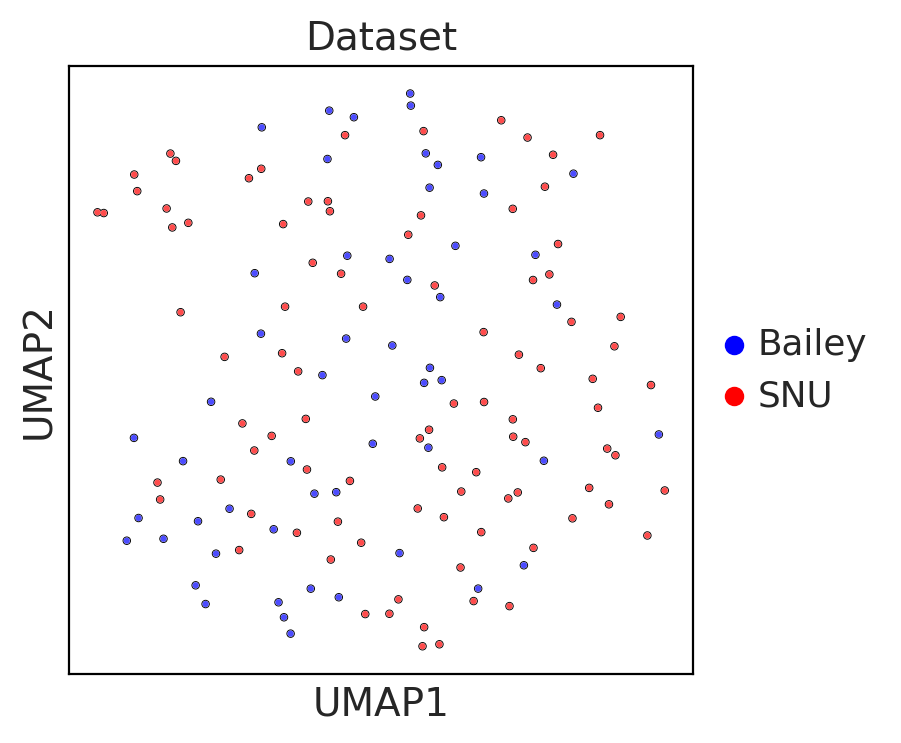

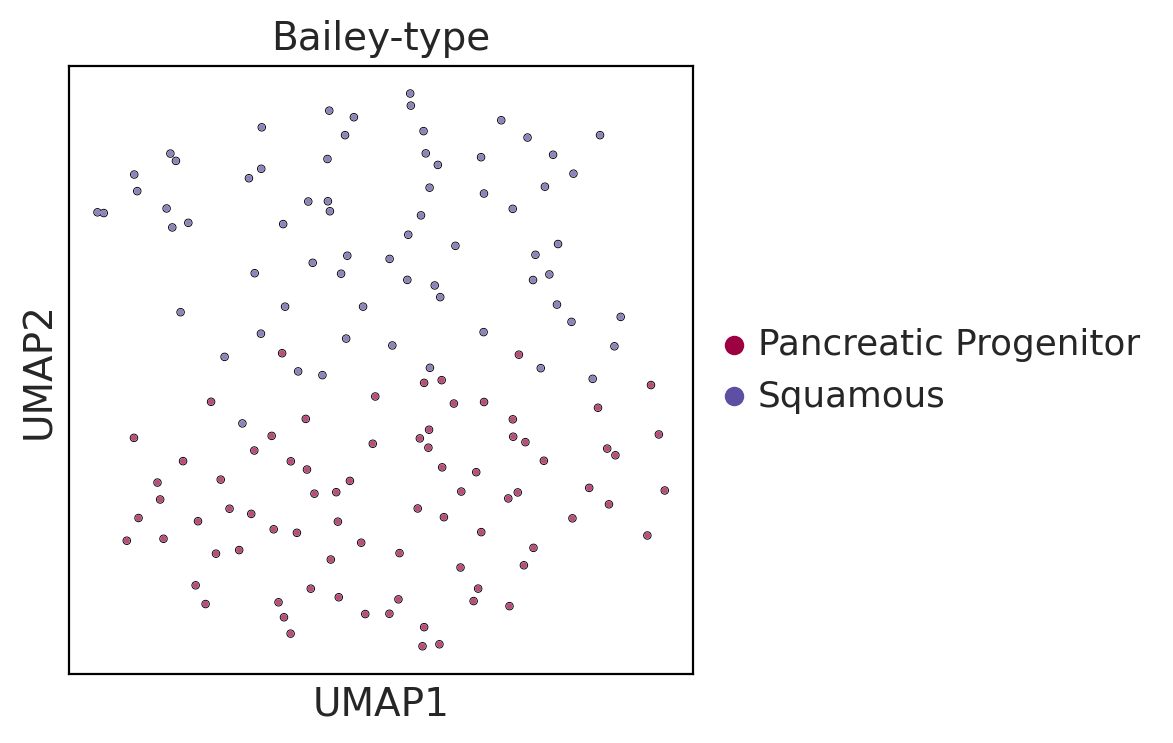

In [555]:
N_pca = 30
sc.tl.pca(mg_adata_bec, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(mg_adata_bec, n_neighbors=30, n_pcs=N_pca)
sc.tl.umap(mg_adata_bec)
sc.pl.umap(mg_adata_bec, color=['Dataset'], palette='bwr', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))
sc.pl.umap(mg_adata_bec, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

In [556]:
mg_adata_bec.obs['Bailey2type'] = mg_adata_bec.obs['Bailey-type'].copy()
mg_adata_bec.obs['Bailey2type'].loc[test_idx] = y_test
mg_adata_bec.obs['Bailey2type']

20-T00330_FO-01-0                 Squamous
19-T00062_FO-01-0                 Squamous
20-T00814_FT-01-0    Pancreatic Progenitor
19-T00201_FO-01-0                 Squamous
19-T00505_FO-01-0    Pancreatic Progenitor
                             ...          
ICGC_0518-1          Pancreatic Progenitor
ICGC_0507-1          Pancreatic Progenitor
ICGC_0521-1                       Squamous
ICGC_0522-1                       Squamous
ICGC_0543-1                       Squamous
Name: Bailey2type, Length: 148, dtype: category
Categories (2, object): ['Pancreatic Progenitor', 'Squamous']

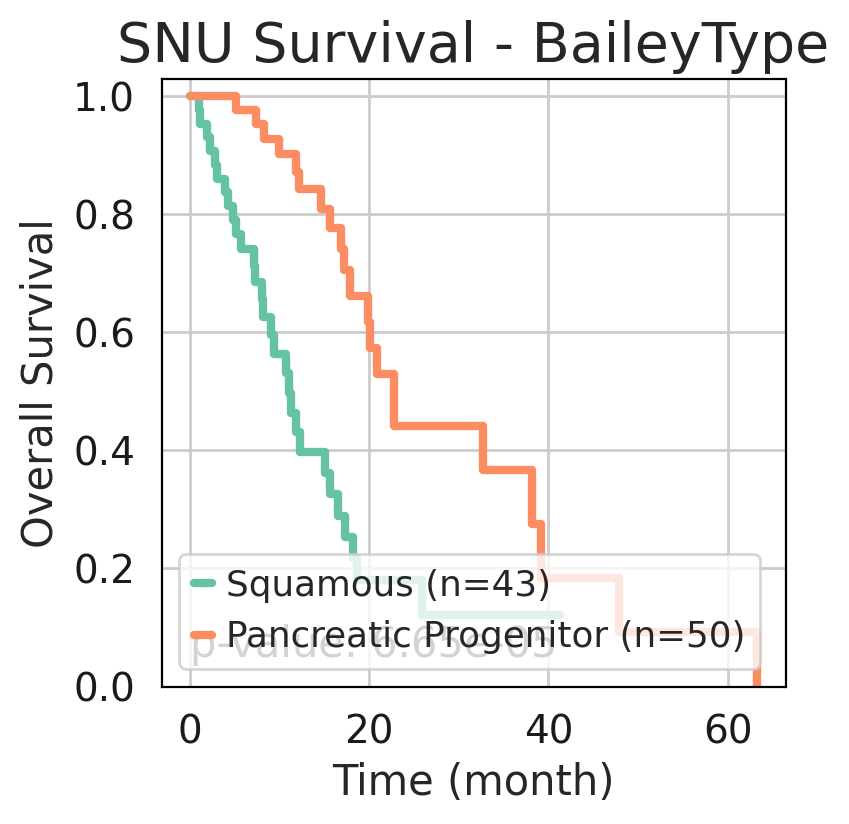

'6.65e-05'

In [557]:
#sc.settings.set_figure_params(dpi=100, figsize=(7,5), fontsize=18)
m = mg_adata_bec.obs['Dataset'] == 'SNU'
SNU_sel = mg_adata_bec[m]
snu_df1 = SNU_sel.obs.copy()
km_plot(df_info=snu_df1, category='Bailey2type', os='OS_F', event='OS_event', title='SNU Survival - BaileyType')

In [471]:
# other = pd.read_csv('ALL_TYPE2.csv',index_col=0)
# other['Bailey2type'] = list(snu_df1['Bailey2type'])
# other.to_csv('ALL_TYPE2.csv')
# #other['Bailey2type2'] = 

# Bailey 2 subtype (ADEX / Immunogenic)

In [10]:
SNU_adata = sc.read_h5ad('SNU_AnnDataForm_20220519.h5ad')
SNU_adata.obs['Dataset'] = 'SNU'
SNU_genes = list(SNU_adata.to_df().columns)
print(len(SNU_genes))
sc.pp.log1p(SNU_adata)

# TCGA_adata = sc.read_h5ad('TCGA_TPM_AnnDataForm.h5ad')
# TCGA_adata.obs['Dataset'] = 'TCGA'
# sc.pp.log1p(TCGA_adata)
# TCGA_genes = list(TCGA_adata.to_df().columns)

Bailey_adata = sc.read_h5ad('Bailey_TPM_norm_AnnDataForm.h5ad')
Bailey_adata.obs['Dataset'] = 'Bailey'
Bailey_genes = list(Bailey_adata.to_df().columns)
print(len(Bailey_genes))

common_genes_all = list(set(SNU_genes)&set(Bailey_genes))
print(len(common_genes_all))

19987
18077
15420


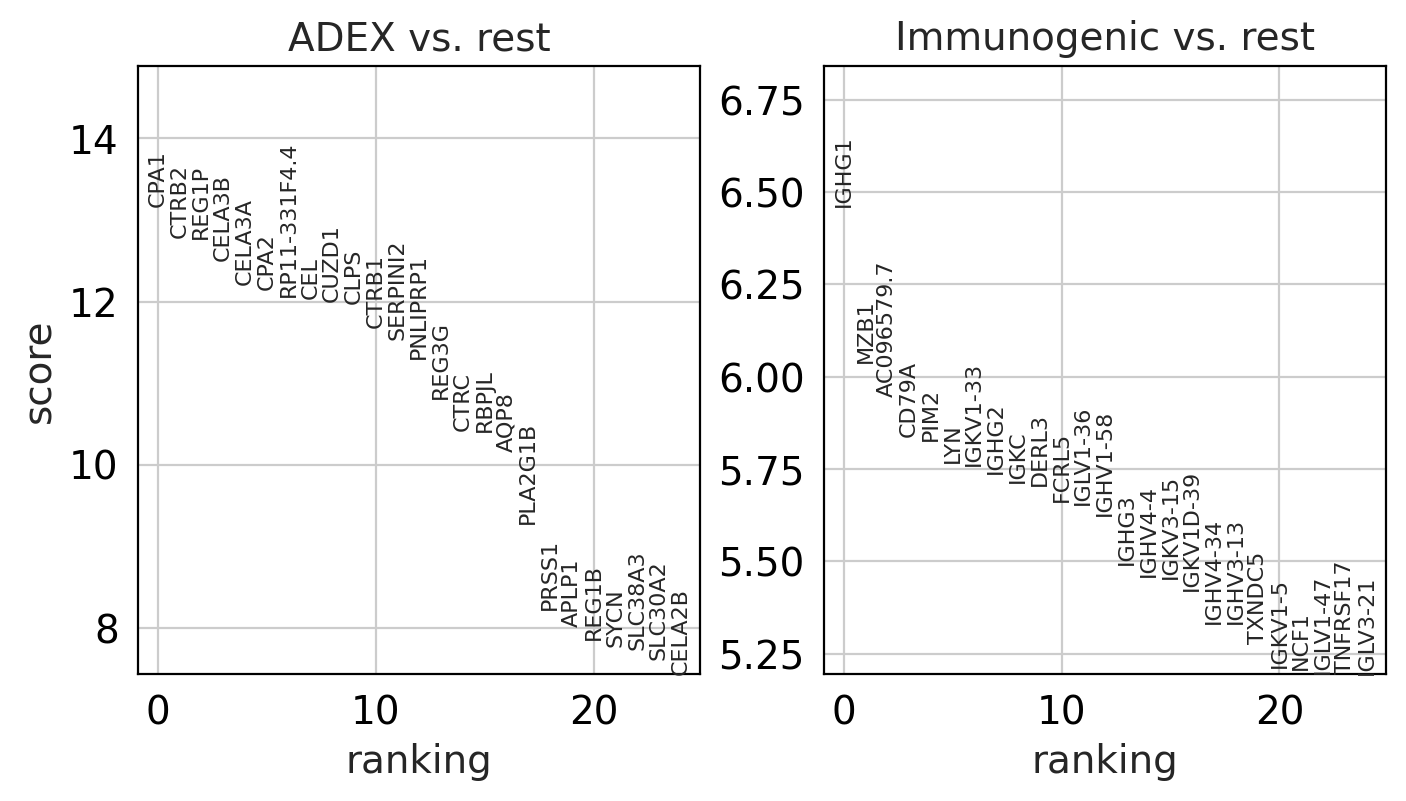

total genes: 498


In [11]:
sc.settings.set_figure_params(dpi=100)
m = Bailey_adata.obs['Bailey-type'].isin(['ADEX', 'Immunogenic'])
Bailey_adata = Bailey_adata[m,:]
sc.tl.rank_genes_groups(Bailey_adata, 'Bailey-type', method='t-test')
sc.pl.rank_genes_groups(Bailey_adata, n_genes=25, sharey=False, ncols=2, wspace=0.5)

test_method = 't-test' # wilcoxon / t-test
target_group = 'Bailey-type'
groups = ['ADEX', 'Immunogenic']
test = groups[0]
control = groups[1]
sc.tl.rank_genes_groups(Bailey_adata, target_group, groups=[test], reference=control, method=test_method)
result = Bailey_adata.uns['rank_genes_groups']
df_deg = pd.DataFrame( index = result['names'][test] )
for key in ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']:
    df_deg[key] = result[key][test]
#df_wilcoxon.columns = ['logfoldchanges', 'wilcoxon-pvals', 'wilcoxon-pvals_adj', 'wilcoxon-scores']
df_deg = df_deg.sort_values(by='pvals')

threshold = 0.05
m = df_deg['pvals_adj'] < threshold
df_deg = df_deg[m]
total_unique = list(df_deg.index)
print('total genes: {}'.format(len(total_unique)))

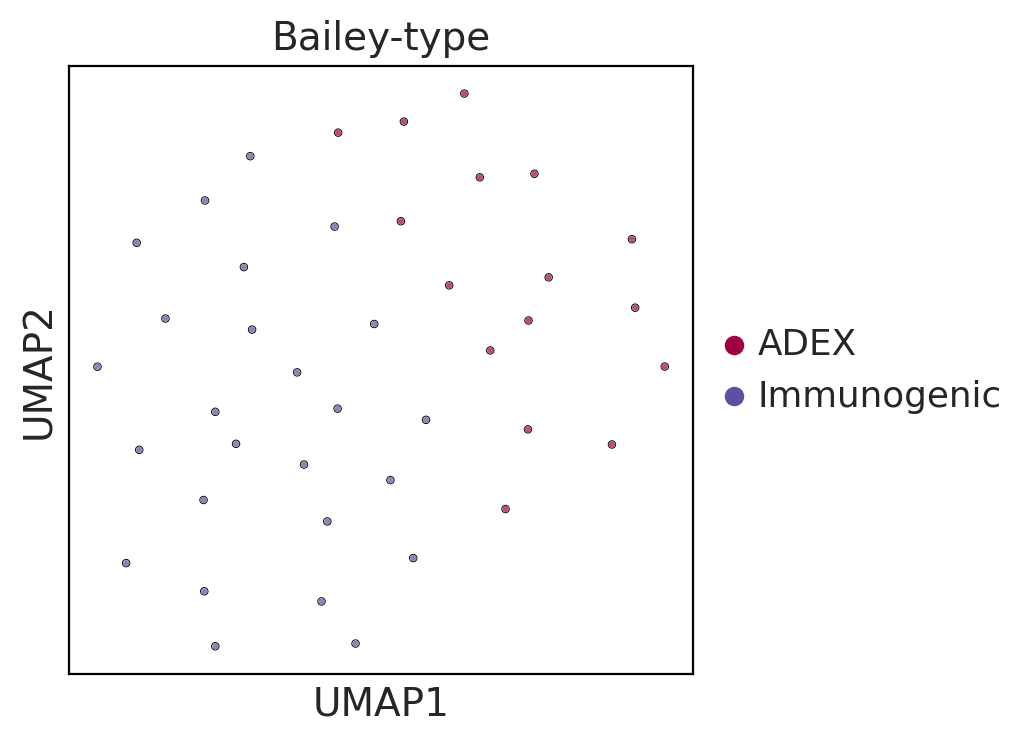

In [12]:
Bailey_adata
N_pca = 40
sc.tl.pca(Bailey_adata, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(Bailey_adata, n_neighbors=20, n_pcs=N_pca)
sc.tl.umap(Bailey_adata)
sc.pl.umap(Bailey_adata, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

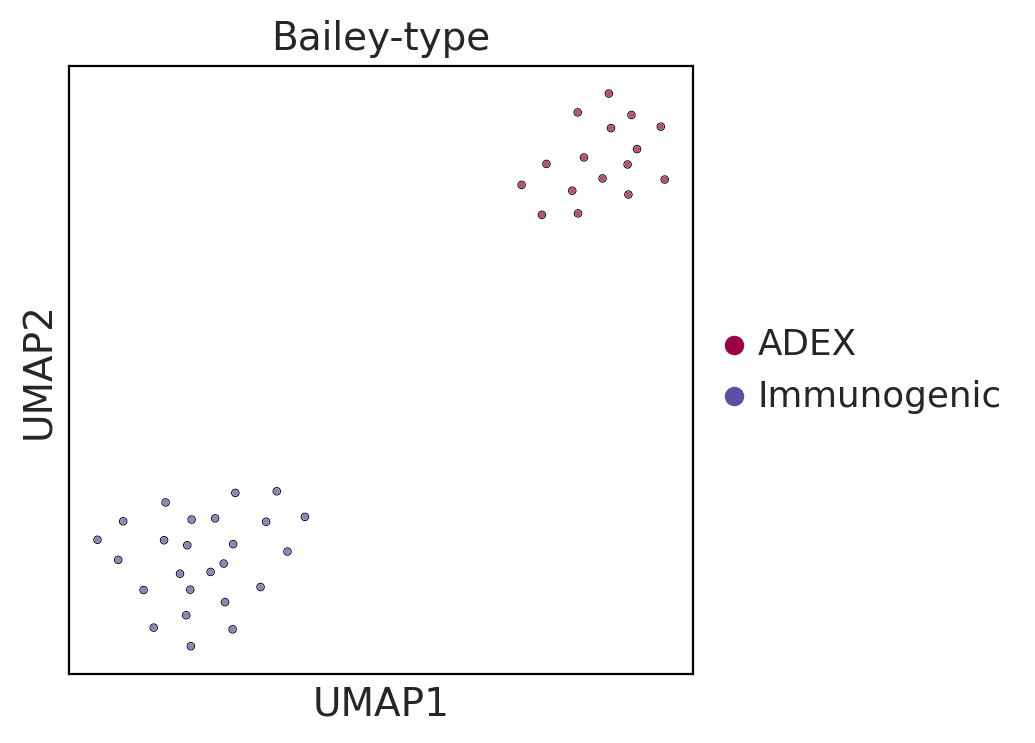

In [13]:
Bailey_adata_sel = Bailey_adata[:,total_unique]
N_pca = 40
sc.tl.pca(Bailey_adata_sel, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(Bailey_adata_sel, n_neighbors=20, n_pcs=N_pca)
sc.tl.umap(Bailey_adata_sel)
sc.pl.umap(Bailey_adata_sel, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

In [16]:
m = df_deg['scores'] > 0
adex = df_deg[m]


logfoldchanges         pvals     pvals_adj     scores
CPA1          16.333231  2.165615e-15  1.977092e-11  13.161767
CTRB2               NaN  2.187412e-15  1.977092e-11  12.776464
CELA3B              NaN  5.732418e-15  2.653062e-11  12.493658
REG1P               NaN  5.870581e-15  2.653062e-11  12.771474
CELA3A              NaN  8.568089e-15  3.097707e-11  12.207375
...                 ...           ...           ...        ...
PPP2R2D        0.804674  1.278217e-03  4.764191e-02   3.746854
RGS7                NaN  1.322954e-03  4.870357e-02   3.587549
CALY          -1.062482  1.325560e-03  4.870357e-02   3.502421
MPP6           1.499866  1.368006e-03  4.981465e-02   3.524081
NRG2          -1.060989  1.376094e-03  4.995111e-02   3.451960

[269 rows x 4 columns]

In [18]:
arcina_cell_mk = 'AKR1C3,ALDOB,AMY2B,ANGPTL4,ANPEP,C15ORF48,CEL,CELA1,CELA2A,CELA3A,CELA3B,CFB,CLPS,CPA1,CPA2,CPB1,CTRB1,CTRB2,CTRC,CXCL17,DUOXA2,GDF15,GSTA1,GSTA2,KLK1,LGALS2,LYZ,MUC1,OLFM4,PDZK1IP1,PLA2G1B,PNLIP,PNLIPRP1,PRSS1,PRSS2,PRSS3,PTF1A,RARRES2,RBPJL,REG1A,REG1B,REG3A,RNASE1,SERPINA3,SPINK1,SYCN,UBD,ZG16'.split(',')
','.join(list(set(adex.index)&set(arcina_cell_mk)))

'RBPJL,REG3A,CLPS,AMY2B,PRSS1,SYCN,CTRB2,CELA3B,KLK1,REG1B,CPB1,CPA2,CPA1,PNLIP,PRSS3,PLA2G1B,CTRB1,CTRC,CEL,REG1A,SERPINA3,CELA3A,PNLIPRP1,CELA2A'

In [562]:
features = list(set(common_genes_all)&set(total_unique))
print(len(features))
mg_adata = SNU_adata[:,features].concatenate(Bailey_adata[:,features])
mg_adata.to_df()

369


ACAN       KMO     CELF3      EPOR      PRSS1  \
20-T00330_FO-01-0  0.039221  1.851599  0.593327  2.215937   3.400531   
19-T00062_FO-01-0  0.494696  0.717840  0.000000  1.629241   7.216144   
20-T00814_FT-01-0  1.258461  0.806476  0.000000  2.737609   5.253320   
19-T00201_FO-01-0  0.254642  1.568616  0.553885  2.567254   0.000000   
19-T00505_FO-01-0  0.000000  1.501853  0.652325  2.119864   6.110780   
...                     ...       ...       ...       ...        ...   
ICGC_0415-1        1.945923  0.077398  0.774817  1.403707  -0.529001   
ICGC_0420-1       -0.261361 -0.388413 -2.688216  0.994144  10.614231   
ICGC_0536-1        4.788425  1.685398 -5.801917  0.716961   0.432388   
ICGC_0503-1        0.810592 -0.210502  2.430089  1.275470   9.103376   
ICGC_0526-1        4.649529  1.389313 -5.520159  1.117778   6.701565   

                      BNIP3     WDR17  TMEM132D       GP2     IGLL5  ...  \
20-T00330_FO-01-0  1.481605  0.314811  0.231112  2.088154  2.615204  ...   
19-T00062_FO-01-0  2.086914  0.570980  0.039221  6.231583  2.780681  ...   
20-T00814_FT-01-0  3.596216  2.026832  0.751416  2.944439  1.834180  ...   
19-T00201_FO-01-0  2.089392  0.336472  0.000000  0.000000  3.520461  ...   
19-T00505_FO-01-0  2.283402  0.482426  0.000000  4.103965  3.388450  ...   
...                     ...       ...       ...       ...       ...  ...   
ICGC_0415-1        2.701763  0.516462 -2.648696  6.527950  5.751946  ...   
ICGC_0420-1        2.659742  2.048947 -2.192783  8.131433 -0.167492  ...   
ICGC_0536-1        2.449517  1.770309 -5.560494  2.018167  5.576870  ...   
ICGC_0503-1        3.193707  2.153913  2.790080  7.563612  2.828020  ...   
ICGC_0526-1       -0.324262  2.202741 -7.640418  7.420516  3.075577  ...   

                      LPAR3     TGIF1      DNER    BTN2A2      CBX6     EVI2B  \
20-T00330_FO-01-0  0.000000  3.647797  0.824175  1.756132  2.390596  2.986187   
19-T00062_FO-01-0  0.357674  3.420673  0.797507  2.373044  2.358965  3.131573   
20-T00814_FT-01-0  0.246860  3.845456  0.000000  2.292535  2.698673  2.551786   
19-T00201_FO-01-0  1.427916  5.016485  1.800058  2.846071  3.155723  2.363680   
19-T00505_FO-01-0  0.246860  4.620551  0.131028  2.367436  2.489065  3.081910   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0415-1       -6.642017  4.854519 -1.925481  2.760133  5.768301  3.890186   
ICGC_0420-1       -1.144987  5.403866  1.140584  3.742270  5.579152  2.834455   
ICGC_0536-1       -1.266259  5.642068  2.240369  4.374300  5.517261  4.599148   
ICGC_0503-1        0.565295  4.677510  1.161026  2.492473  6.191132  3.153821   
ICGC_0526-1       -2.204628  4.449954 -2.012093  3.029626  5.153749  3.149628   

                       GIPR    PLGLB2     BRSK2      CD74  
20-T00330_FO-01-0  2.228939  0.604316  1.532557  6.226853  
19-T00062_FO-01-0  0.850151  1.396245  1.601406  5.840235  
20-T00814_FT-01-0  3.695110  1.258461  2.460443  6.120956  
19-T00201_FO-01-0  2.955951  2.078191  1.166271  7.075953  
19-T00505_FO-01-0  3.217274  0.751416  1.609438  6.374923  
...                     ...       ...       ...       ...  
ICGC_0415-1        1.740113 -3.951700 -0.638322  9.084168  
ICGC_0420-1        2.844746  0.832440  0.597907  8.725453  
ICGC_0536-1        1.170505 -0.120461 -1.773972  9.888703  
ICGC_0503-1        1.979087 -0.784231  0.666524  9.252247  
ICGC_0526-1        2.055805 -2.553138 -1.102537  9.492087  

[134 rows x 369 columns]

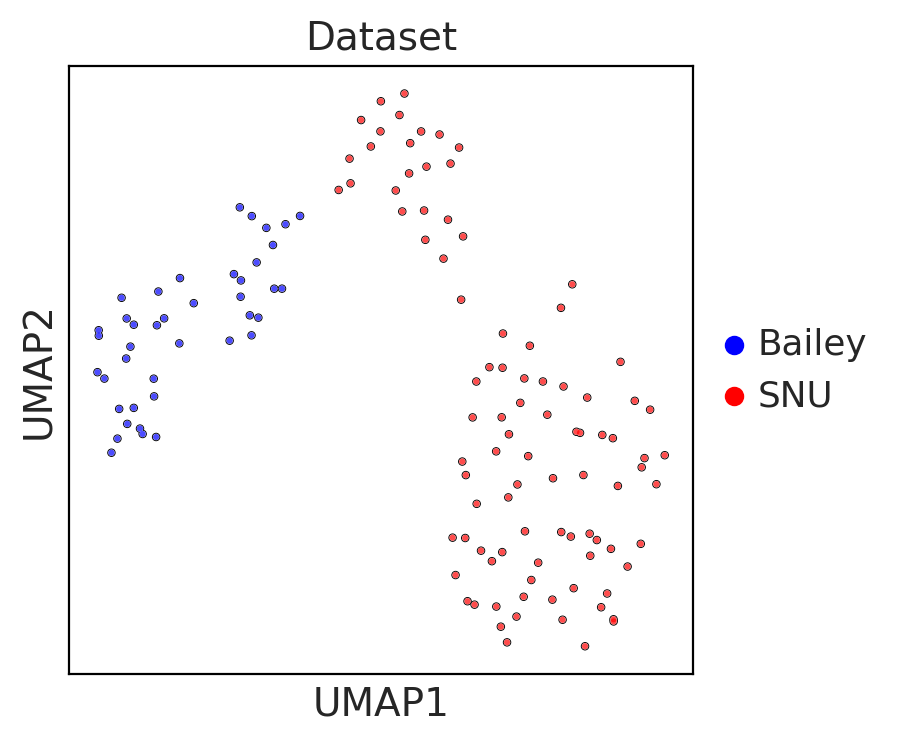

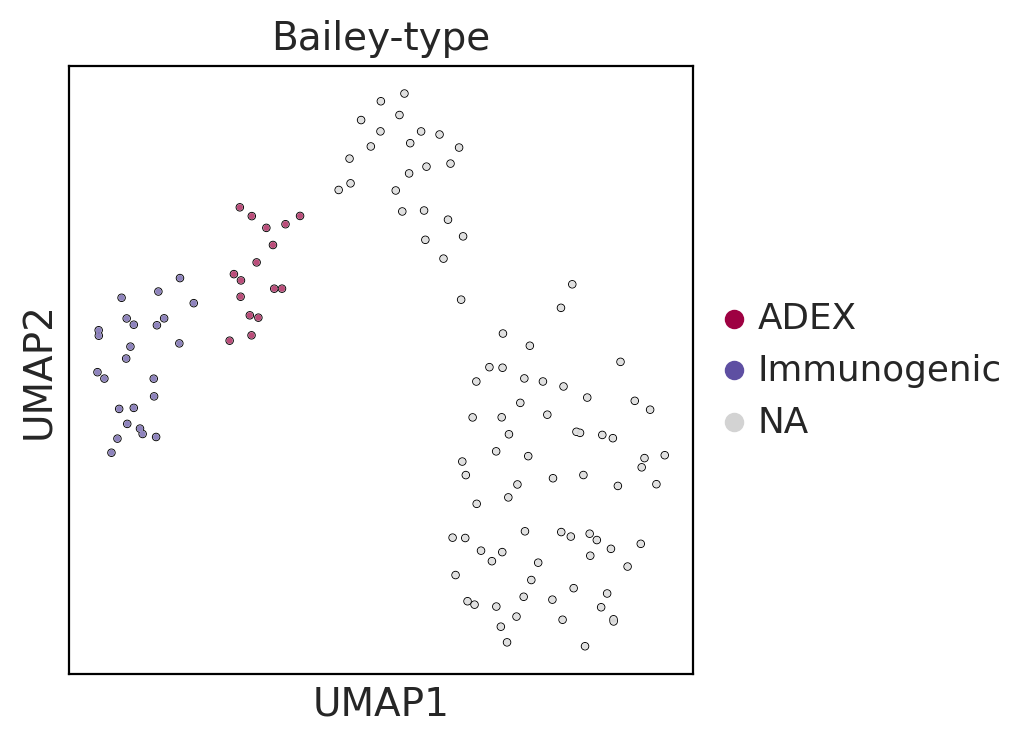

In [563]:
N_pca = 40
sc.tl.pca(mg_adata, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(mg_adata, n_neighbors=20, n_pcs=N_pca)
sc.tl.umap(mg_adata)
sc.pl.umap(mg_adata, color=['Dataset'], palette='bwr', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))
sc.pl.umap(mg_adata, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

# Combat

In [566]:
df_exp_all = mg_adata.to_df().T
batch = list(mg_adata.obs['Dataset'].values)
df_corrected = pycombat(df_exp_all,batch).T
mg_adata_bec = sc.AnnData(df_corrected)
mg_adata_bec.obs = mg_adata.obs.copy()
mg_adata_bec.to_df()

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


ACAN       KMO     CELF3      EPOR     PRSS1     BNIP3  \
20-T00330_FO-01-0  0.127964  1.671772  0.036499  1.813981  4.351507  1.390080   
19-T00062_FO-01-0  0.963129  0.389228 -1.304700  1.179193  8.930091  2.108608   
20-T00814_FT-01-0  2.363578  0.489496 -1.304700  2.378414  6.574780  3.900213   
19-T00201_FO-01-0  0.522963  1.351652 -0.052658  2.194095  0.271006  2.111550   
19-T00505_FO-01-0  0.056048  1.276128  0.169863  1.710032  7.603698  2.341848   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0415-1        0.976690  0.731156  1.375727  2.242851 -1.019665  2.503977   
ICGC_0420-1       -0.433432  0.355814 -0.754435  1.897187  7.518820  2.471504   
ICGC_0536-1        2.792620  2.026851 -2.669717  1.663249 -0.283002  2.309051   
ICGC_0503-1        0.251384  0.499171  2.393909  2.134622  6.361130  2.884132   
ICGC_0526-1        2.703886  1.788271 -2.496404  2.001532  4.520746  0.165580   

                      WDR17  TMEM132D       GP2     IGLL5  ...     LPAR3  \
20-T00330_FO-01-0  0.408209 -0.142587  3.147194  2.628880  ... -0.994858   
19-T00062_FO-01-0  0.702966 -0.749575  8.159520  2.854346  ... -0.302652   
20-T00814_FT-01-0  2.378127  1.503233  4.183046  1.564720  ... -0.517111   
19-T00201_FO-01-0  0.433133 -0.873637  0.621145  3.862311  ...  1.768581   
19-T00505_FO-01-0  0.601073 -0.873637  5.585731  3.682443  ... -0.517111   
...                     ...       ...       ...       ...  ...       ...   
ICGC_0415-1        0.305362 -0.983320  3.891258  4.695041  ... -3.491358   
ICGC_0420-1        1.521174 -0.711954  5.112404  0.505492  ... -0.020435   
ICGC_0536-1        1.300113 -2.716461  0.456794  4.571128  ... -0.097008   
ICGC_0503-1        1.604449  2.253912  4.679975  2.625599  ...  1.059468   
ICGC_0526-1        1.643188 -3.954460  4.570999  2.800811  ... -0.689511   

                      TGIF1      DNER    BTN2A2      CBX6     EVI2B      GIPR  \
20-T00330_FO-01-0  3.974739  0.715897  1.951377  3.078197  3.011938  1.700681   
19-T00062_FO-01-0  3.735582  0.667441  2.591907  3.042194  3.175677  0.168642   
20-T00814_FT-01-0  4.182870 -0.781624  2.508316  3.428859  2.522704  3.329818   
19-T00201_FO-01-0  5.415943  2.489069  3.083044  3.949087  2.310854  2.508502   
19-T00505_FO-01-0  4.999032 -0.543546  2.586084  3.190277  3.119745  2.798871   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0415-1        4.111911 -0.716220  2.301111  3.966949  3.674845  2.717820   
ICGC_0420-1        4.591291  1.246541  3.174427  3.815467  2.820371  3.623732   
ICGC_0536-1        4.799156  1.950575  3.736429  3.765901  4.248655  2.250684   
ICGC_0503-1        3.957446  1.259627  2.063108  4.305579  3.078855  2.913803   
ICGC_0526-1        3.758872 -0.771666  2.540744  3.474778  3.075461  2.976720   

                     PLGLB2     BRSK2      CD74  
20-T00330_FO-01-0 -0.336772  0.795990  6.953682  
19-T00062_FO-01-0  0.747561  0.912398  6.512072  
20-T00814_FT-01-0  0.558903  2.364849  6.832723  
19-T00201_FO-01-0  1.681303  0.176678  7.923559  
19-T00505_FO-01-0 -0.135358  0.925979  7.122814  
...                     ...       ...       ...  
ICGC_0415-1       -1.499946  0.895529  7.324897  
ICGC_0420-1        1.876351  1.701503  7.038579  
ICGC_0536-1        1.203863  0.155130  7.967060  
ICGC_0503-1        0.735423  1.746239  7.459054  
ICGC_0526-1       -0.512943  0.592880  7.650489  

[134 rows x 369 columns]

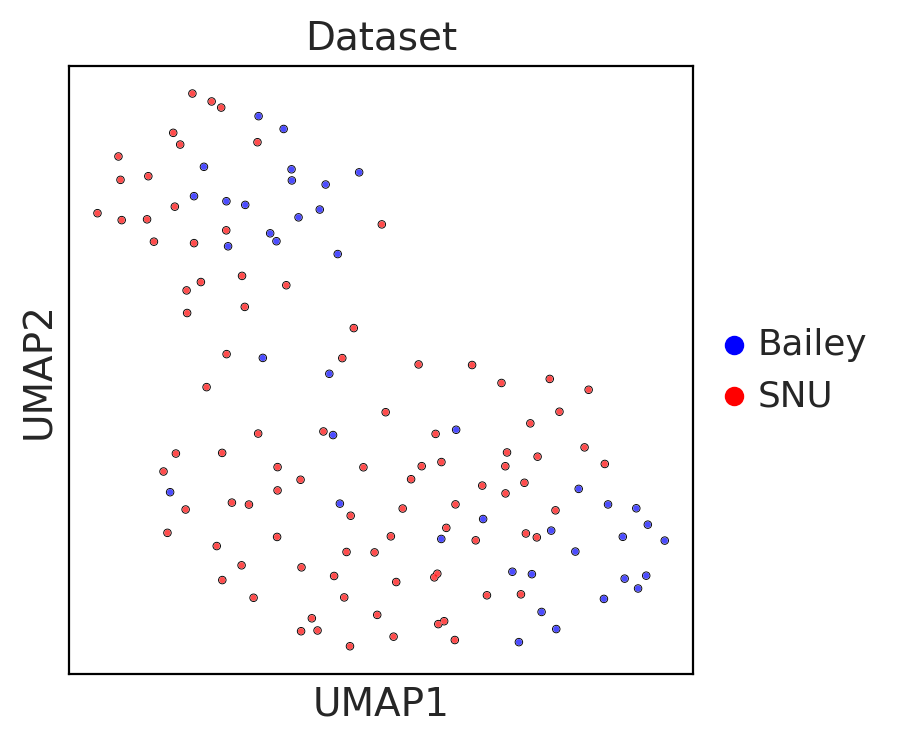

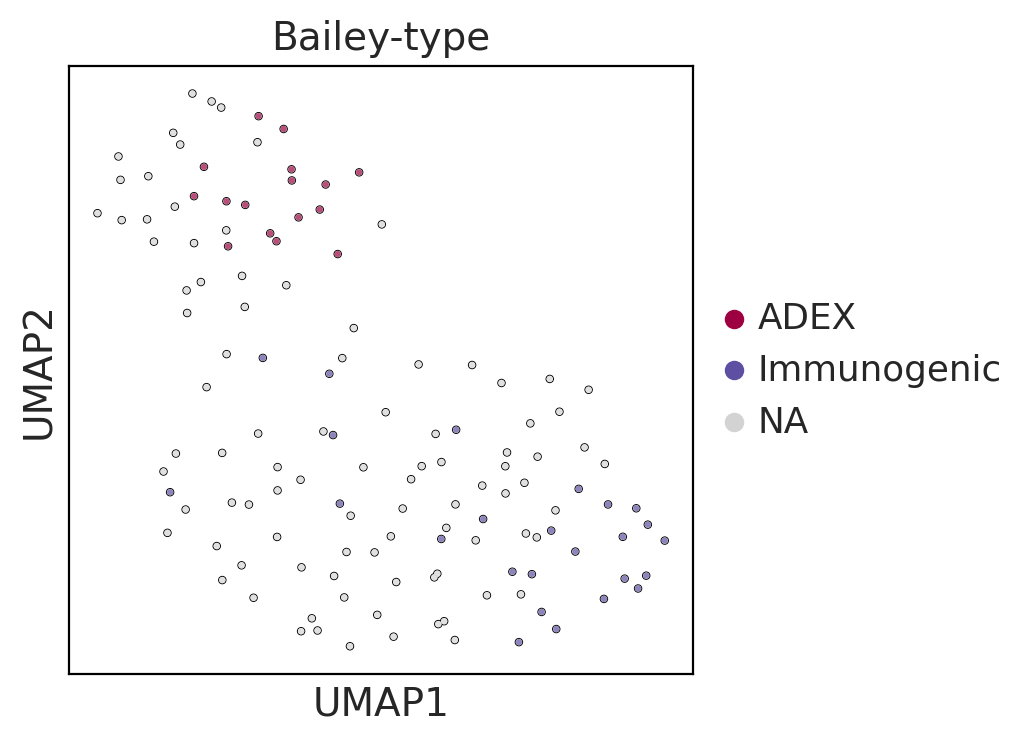

In [568]:
N_pca = 30
sc.tl.pca(mg_adata_bec, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(mg_adata_bec, n_neighbors=30, n_pcs=N_pca)
sc.tl.umap(mg_adata_bec)
sc.pl.umap(mg_adata_bec, color=['Dataset'], palette='bwr', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))
sc.pl.umap(mg_adata_bec, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

In [569]:
all_exp = mg_adata_bec.to_df()
scaled_df = pd.DataFrame(scaler.fit_transform(all_exp), columns=all_exp.columns, index=all_exp.index)
scaled_df

ACAN       KMO     CELF3      EPOR     PRSS1     BNIP3  \
20-T00330_FO-01-0 -0.761960  1.131067  0.276864 -0.024547  0.130930 -1.275922   
19-T00062_FO-01-0  0.237753 -0.769226 -0.745325 -1.104660  1.745544 -0.528594   
20-T00814_FT-01-0  1.914124 -0.620663 -0.745325  0.935853  0.914956  1.334823   
19-T00201_FO-01-0 -0.289136  0.656759  0.208913  0.622229 -1.308039 -0.525534   
19-T00505_FO-01-0 -0.848045  0.544857  0.378507 -0.201420  1.277798 -0.286005   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0415-1        0.253986 -0.262606  1.297551  0.705189 -1.763188 -0.117378   
ICGC_0420-1       -1.433965 -0.818734 -0.325943  0.117030  1.247867 -0.151152   
ICGC_0536-1        2.427699  1.657173 -1.785667 -0.281022 -1.503407 -0.320117   
ICGC_0503-1       -0.614223 -0.606328  2.073553  0.521033  0.839613  0.278015   
ICGC_0526-1        2.321482  1.303679 -1.653577  0.294577  0.190611 -2.549503   

                      WDR17  TMEM132D       GP2     IGLL5  ...     LPAR3  \
20-T00330_FO-01-0 -0.867116  0.288908 -0.019300 -0.535954  ... -0.838079   
19-T00062_FO-01-0 -0.508018 -0.206807  2.085861 -0.401362  ... -0.275736   
20-T00814_FT-01-0  1.532798  1.633020  0.415755 -1.171207  ... -0.449960   
19-T00201_FO-01-0 -0.836751 -0.308127 -1.080232  0.200346  ...  1.406921   
19-T00505_FO-01-0 -0.632153 -0.308127  1.004877  0.092973  ... -0.449960   
...                     ...       ...       ...       ...  ...       ...   
ICGC_0415-1       -0.992413 -0.397702  0.293204  0.697446  ... -2.866220   
ICGC_0420-1        0.488789 -0.176083  0.806082 -1.803515  ... -0.046464   
ICGC_0536-1        0.219475 -1.813127 -1.149259  0.623476  ... -0.108672   
ICGC_0503-1        0.590241  2.246085  0.624463 -0.537912  ...  0.830842   
ICGC_0526-1        0.637436 -2.824177  0.578694 -0.433320  ... -0.590017   

                      TGIF1      DNER    BTN2A2      CBX6     EVI2B      GIPR  \
20-T00330_FO-01-0 -1.143841  0.295223 -1.570656 -1.022008 -0.113146 -0.436368   
19-T00062_FO-01-0 -1.522892  0.259339 -0.191057 -1.077625  0.124225 -2.127702   
20-T00814_FT-01-0 -0.813966 -0.813767 -0.371099 -0.480304 -0.822385  1.362159   
19-T00201_FO-01-0  1.140380  1.608347  0.866774  0.323345 -1.129504  0.455446   
19-T00505_FO-01-0  0.479601 -0.637459 -0.203597 -0.848867  0.043140  0.776006   
...                     ...       ...       ...       ...       ...       ...   
ICGC_0415-1       -0.926432 -0.765333 -0.817384  0.350940  0.847866  0.686529   
ICGC_0420-1       -0.166643  0.688192  1.063599  0.116929 -0.390860  1.686634   
ICGC_0536-1        0.162810  1.209565  2.274062  0.040359  1.679716  0.170822   
ICGC_0503-1       -1.171250  0.697883 -1.330005  0.874056 -0.016137  0.902889   
ICGC_0526-1       -1.485977 -0.806393 -0.301253 -0.409368 -0.021057  0.972348   

                     PLGLB2     BRSK2      CD74  
20-T00330_FO-01-0 -0.756091 -0.085979 -0.773428  
19-T00062_FO-01-0  0.302826 -0.003586 -1.494204  
20-T00814_FT-01-0  0.118590  1.024441 -0.970852  
19-T00201_FO-01-0  1.214682 -0.524321  0.809557  
19-T00505_FO-01-0 -0.559398  0.006026 -0.497379  
...                     ...       ...       ...  
ICGC_0415-1       -1.892002 -0.015526 -0.167549  
ICGC_0420-1        1.405158  0.554933 -0.634865  
ICGC_0536-1        0.748433 -0.539572  0.880557  
ICGC_0503-1        0.290972  0.586596  0.051415  
ICGC_0526-1       -0.928133 -0.229738  0.363866  

[134 rows x 369 columns]

In [570]:
Bailey_labels = mg_adata_bec.obs['Bailey-type'].to_frame('labels')
Bailey_labels

labels
20-T00330_FO-01-0          NaN
19-T00062_FO-01-0          NaN
20-T00814_FT-01-0          NaN
19-T00201_FO-01-0          NaN
19-T00505_FO-01-0          NaN
...                        ...
ICGC_0415-1        Immunogenic
ICGC_0420-1               ADEX
ICGC_0536-1        Immunogenic
ICGC_0503-1               ADEX
ICGC_0526-1        Immunogenic

[134 rows x 1 columns]

In [571]:
train_idx = ~Bailey_labels['labels'].isna()
test_idx = ~train_idx

X = scaled_df.loc[train_idx,:]
y = Bailey_labels.loc[train_idx,:]
y = y['labels']
y

ICGC_0006-1           ADEX
ICGC_0007-1    Immunogenic
ICGC_0075-1           ADEX
ICGC_0354-1           ADEX
ICGC_0020-1    Immunogenic
ICGC_0026-1           ADEX
ICGC_0033-1           ADEX
ICGC_0048-1           ADEX
ICGC_0391-1           ADEX
ICGC_0052-1           ADEX
ICGC_0061-1    Immunogenic
ICGC_0099-1    Immunogenic
ICGC_0103-1           ADEX
ICGC_0063-1    Immunogenic
ICGC_0108-1    Immunogenic
ICGC_0109-1    Immunogenic
ICGC_0205-1           ADEX
ICGC_0207-1    Immunogenic
ICGC_0115-1    Immunogenic
ICGC_0124-1    Immunogenic
ICGC_0135-1    Immunogenic
ICGC_0144-1    Immunogenic
ICGC_0146-1           ADEX
ICGC_0149-1    Immunogenic
ICGC_0150-1    Immunogenic
ICGC_0153-1    Immunogenic
ICGC_0201-1           ADEX
ICGC_0214-1    Immunogenic
ICGC_0395-1    Immunogenic
ICGC_0300-1    Immunogenic
ICGC_0338-1           ADEX
ICGC_0301-1    Immunogenic
ICGC_0312-1    Immunogenic
ICGC_0303-1    Immunogenic
ICGC_0406-1           ADEX
ICGC_0412-1    Immunogenic
ICGC_0415-1    Immunogenic
I

In [412]:
param_grid = {'C': np.arange(0.1,1.1,0.1),
             'l1_ratio': np.arange(0.1,1,0.1)}
model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', class_weight = 'balanced', multi_class='multinomial', 
                           max_iter = 5000, l1_ratio=0.1)
#model.fit(X,y)
# #SklearnClassifier(SVC(kernel='linear',probability=True))
# model = svm.SVC(kernel='linear', probability=True, class_weight='balanced')
# param_grid = {'C': np.arange(0.01,0.5,0.05)}
final_model = classification_model_training(model=model, param_grid=param_grid, X=X, y=y, title='')

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Estimator
LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.1, max_iter=5000,
                   multi_class='multinomial', penalty='elasticnet',
                   solver='saga')
cv score mean: 1.0


In [572]:
final_model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', class_weight = 'balanced', multi_class='multinomial', 
                           max_iter = 5000, l1_ratio=0.15, C=0.1)
final_model.fit(X,y)

LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.15, max_iter=5000,
                   multi_class='multinomial', penalty='elasticnet',
                   solver='saga')

In [573]:
coeff_ = pd.DataFrame(final_model.coef_, columns=X.columns)
coeff_
m = coeff_.sum(axis=0) != 0
coeff_.loc[:,m]

PRSS1     WDR17     IGLL5     FCRL5      PIM2   SLC28A2      CYBB  \
0 -0.010276 -0.003618  0.025641  0.025332  0.037126 -0.000591  0.001034   

      CLPS     AP3B2      NCF1  ...    MBOAT4     CD79A       IGJ       CEL  \
0 -0.03721 -0.009414  0.015333  ... -0.013355  0.040754  0.007976 -0.033966   

      REG3G      CPA1     CTRB2   TXNDC5      MYT1    ACRBP  
0 -0.050478 -0.037872 -0.031632  0.01719 -0.000799  0.00185  

[1 rows x 77 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


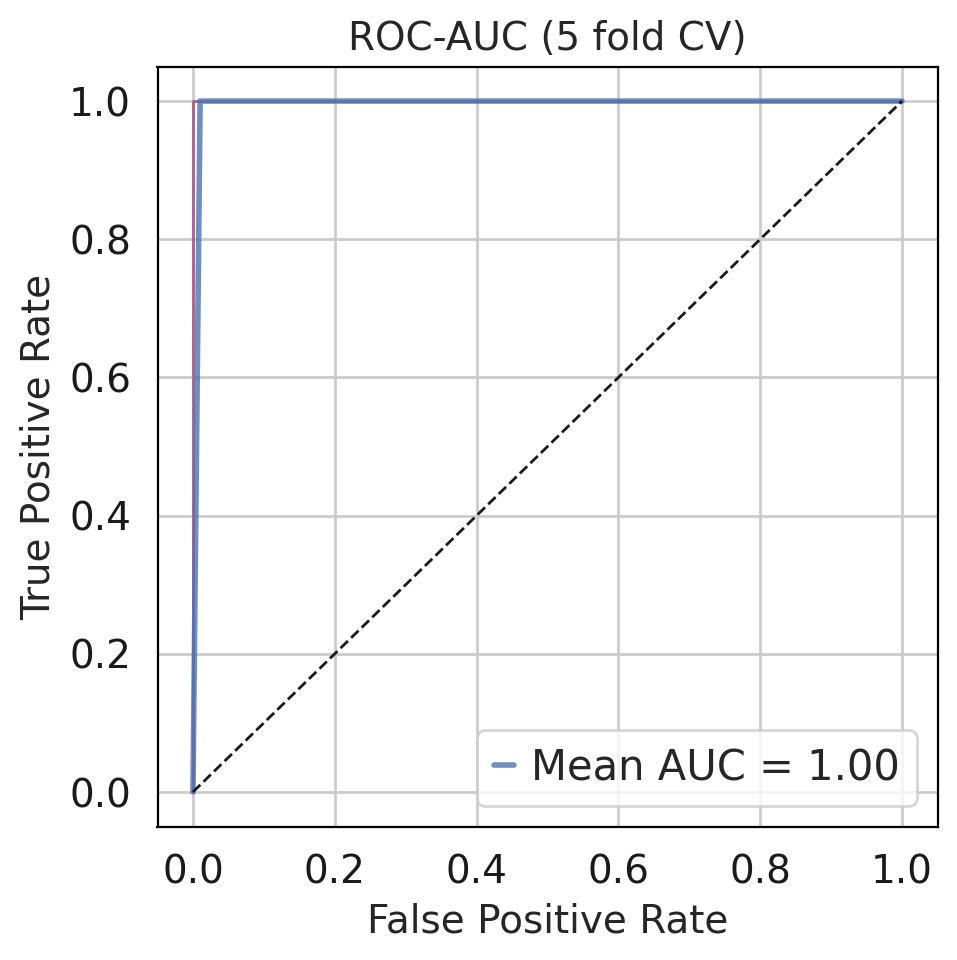

In [485]:
draw_AUC_curve_binary(X,y,final_model)

In [574]:
X_test = scaled_df.loc[test_idx,:]
y_test = list(final_model.predict(X_test))
tmp = pd.DataFrame(final_model.predict_proba(X_test)).idxmax(axis=1).to_frame('argmax')
tmp['type'] = y_test
tmp

argmax         type
0        1  Immunogenic
1        0         ADEX
2        0         ADEX
3        1  Immunogenic
4        0         ADEX
..     ...          ...
88       1  Immunogenic
89       1  Immunogenic
90       1  Immunogenic
91       1  Immunogenic
92       0         ADEX

[93 rows x 2 columns]

In [575]:
mg_adata_bec.obs['Bailey-type'].loc[X_test.index] = y_test
mg_adata_bec.obs

N0         PID       dateA         Snubh_BB  \
20-T00330_FO-01-0  sb2441  32644755.0  2020-05-15  20-B01156_EB-03   
19-T00062_FO-01-0  sb1947  10108754.0  2019-03-18  19-B00635_EB-03   
20-T00814_FT-01-0  sb2669  33563897.0  2020-12-16  20-B04522_EB-04   
19-T00201_FO-01-0  sb2097  24118798.0  2019-05-27              NaN   
19-T00505_FO-01-0  sb2298  31651231.0  2019-09-09  19-B02081_EB-03   
...                   ...         ...         ...              ...   
ICGC_0415-1           NaN         NaN         NaN              NaN   
ICGC_0420-1           NaN         NaN         NaN              NaN   
ICGC_0536-1           NaN         NaN         NaN              NaN   
ICGC_0503-1           NaN         NaN         NaN              NaN   
ICGC_0526-1           NaN         NaN         NaN              NaN   

                  pathology_number tumorcellularity(pathology)  DNA_RNA  \
20-T00330_FO-01-0      S 200019390                          25  DNA+RNA   
19-T00062_FO-01-0      S 190013089                          45  DNA+RNA   
20-T00814_FT-01-0      S 200053444                          35  DNA+RNA   
19-T00201_FO-01-0      S 190025387                          40      RNA   
19-T00505_FO-01-0      S 190043830                          50  DNA+RNA   
...                            ...                         ...      ...   
ICGC_0415-1                    NaN                         NaN      NaN   
ICGC_0420-1                    NaN                         NaN      NaN   
ICGC_0536-1                    NaN                         NaN      NaN   
ICGC_0503-1                    NaN                         NaN      NaN   
ICGC_0526-1                    NaN                         NaN      NaN   

                   methylSeq  metagenomic liquid_number  ...         Country  \
20-T00330_FO-01-0        NaN          NaN          R167  ...             NaN   
19-T00062_FO-01-0        NaN          NaN           NaN  ...             NaN   
20-T00814_FT-01-0        NaN          NaN          R201  ...             NaN   
19-T00201_FO-01-0        NaN          NaN          R017  ...             NaN   
19-T00505_FO-01-0        NaN          NaN          R074  ...             NaN   
...                      ...          ...           ...  ...             ...   
ICGC_0415-1              NaN          NaN           NaN  ...       Australia   
ICGC_0420-1              NaN          NaN           NaN  ...       Australia   
ICGC_0536-1              NaN          NaN           NaN  ...       Australia   
ICGC_0503-1              NaN          NaN           NaN  ...  United Kingdom   
ICGC_0526-1              NaN          NaN           NaN  ...  United Kingdom   

                            Smoker                   Tumour Grade  \
20-T00330_FO-01-0              NaN                            NaN   
19-T00062_FO-01-0              NaN                            NaN   
20-T00814_FT-01-0              NaN                            NaN   
19-T00201_FO-01-0              NaN                            NaN   
19-T00505_FO-01-0              NaN                            NaN   
...                            ...                            ...   
ICGC_0415-1        Stopped Smoking  2 - Moderately differentiated   
ICGC_0420-1          Still Smoking      3 - Poorly differentiated   
ICGC_0536-1          Still Smoking      3 - Poorly differentiated   
ICGC_0503-1         Not documented  2 - Moderately differentiated   
ICGC_0526-1         Not documented      3 - Poorly differentiated   

                                       HistoSubtype Tumour Location  \
20-T00330_FO-01-0                               NaN             NaN   
19-T00062_FO-01-0                               NaN             NaN   
20-T00814_FT-01-0                               NaN             NaN   
19-T00201_FO-01-0                               NaN             NaN   
19-T00505_FO-01-0                               NaN             NaN   
...                                             ...             .

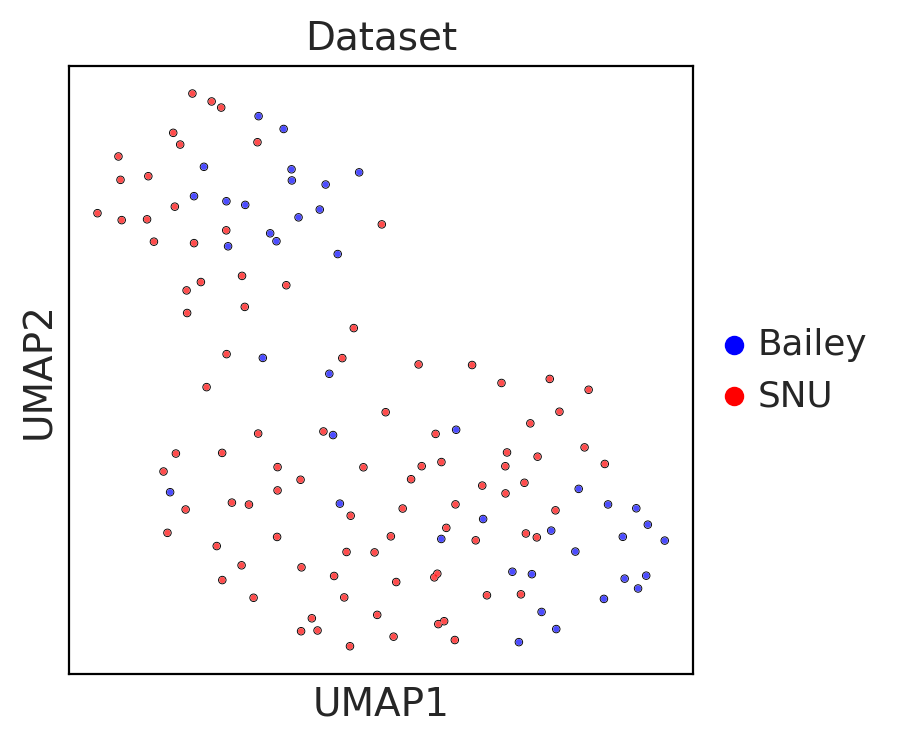

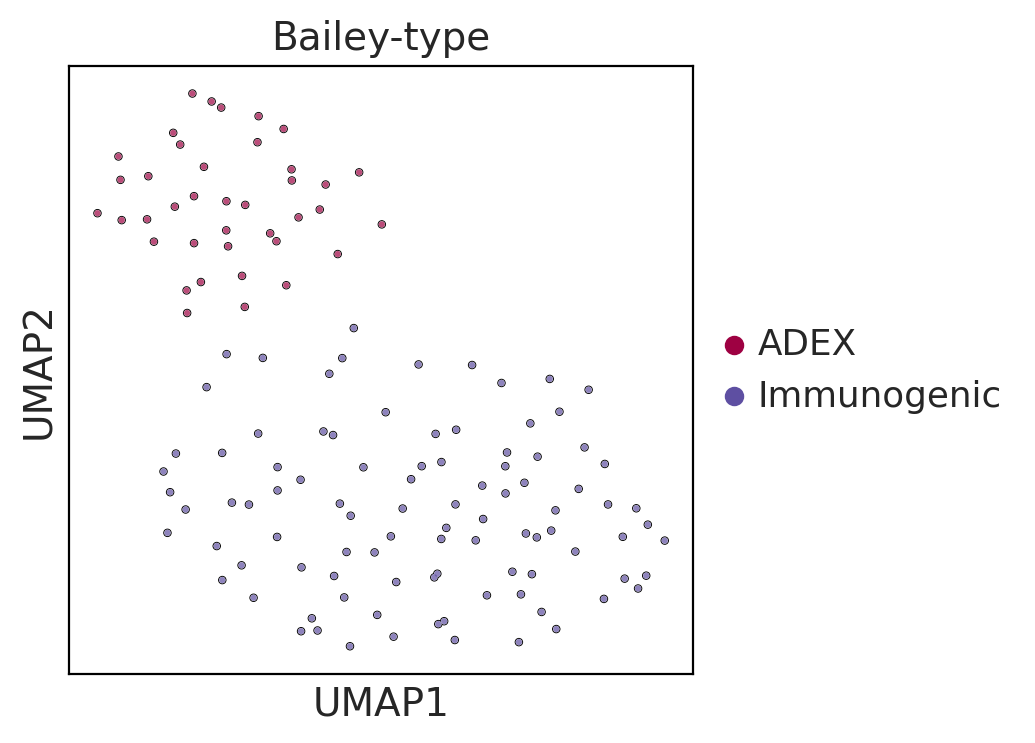

In [576]:
N_pca = 30
sc.tl.pca(mg_adata_bec, svd_solver='arpack', n_comps = N_pca)
sc.pp.neighbors(mg_adata_bec, n_neighbors=30, n_pcs=N_pca)
sc.tl.umap(mg_adata_bec)
sc.pl.umap(mg_adata_bec, color=['Dataset'], palette='bwr', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))
sc.pl.umap(mg_adata_bec, color=['Bailey-type'], palette='Spectral', s=20, wspace=0.3, add_outline=True, outline_width=(0.15, 0.03))

In [577]:
mg_adata_bec.obs['Bailey2type'] = mg_adata_bec.obs['Bailey-type'].copy()
mg_adata_bec.obs['Bailey2type'].loc[test_idx] = y_test
mg_adata_bec.obs['Bailey2type']

20-T00330_FO-01-0    Immunogenic
19-T00062_FO-01-0           ADEX
20-T00814_FT-01-0           ADEX
19-T00201_FO-01-0    Immunogenic
19-T00505_FO-01-0           ADEX
                        ...     
ICGC_0415-1          Immunogenic
ICGC_0420-1                 ADEX
ICGC_0536-1          Immunogenic
ICGC_0503-1                 ADEX
ICGC_0526-1          Immunogenic
Name: Bailey2type, Length: 134, dtype: category
Categories (2, object): ['ADEX', 'Immunogenic']

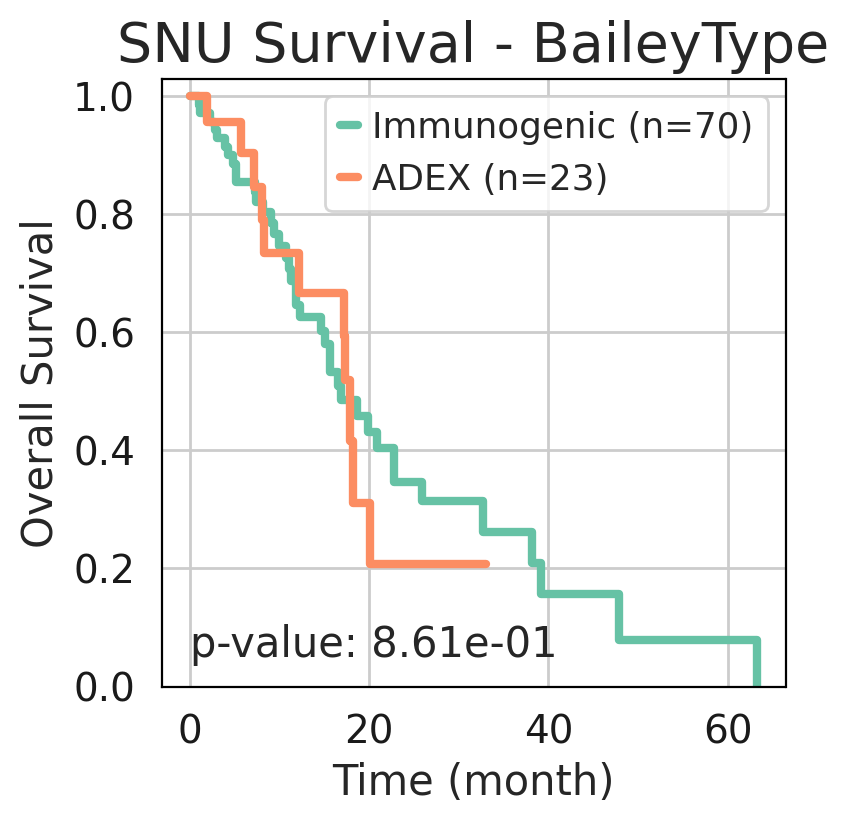

'8.61e-01'

In [578]:
#sc.settings.set_figure_params(dpi=100, figsize=(7,5), fontsize=18)
m = mg_adata_bec.obs['Dataset'] == 'SNU'
SNU_sel = mg_adata_bec[m]
snu_df1 = SNU_sel.obs.copy()
km_plot(df_info=snu_df1, category='Bailey2type', os='OS_F', event='OS_event', title='SNU Survival - BaileyType')

In [440]:
# other = pd.read_csv('ALL_TYPE2.csv',index_col=0)
# other['Bailey2type2'] = list(snu_df1['Bailey2type'])
# other.to_csv('ALL_TYPE2.csv')
# #other['Bailey2type2'] = 

In [434]:
snu_df1

N0         PID       dateA         Snubh_BB  \
20-T00330_FO-01-0  sb2441  32644755.0  2020-05-15  20-B01156_EB-03   
19-T00062_FO-01-0  sb1947  10108754.0  2019-03-18  19-B00635_EB-03   
20-T00814_FT-01-0  sb2669  33563897.0  2020-12-16  20-B04522_EB-04   
19-T00201_FO-01-0  sb2097  24118798.0  2019-05-27              NaN   
19-T00505_FO-01-0  sb2298  31651231.0  2019-09-09  19-B02081_EB-03   
...                   ...         ...         ...              ...   
21-T00576_FT-01-0     NaN  10805327.0  2021-07-23              NaN   
19-T00620_FO-01-0  sb2342  31927356.0  2019-10-30  19-B02516_EB-03   
19-T00413_FO-01-0  sb2283  31464792.0  2019-08-06  19-B01826_EB-03   
20-T00073_FO-01-0  sb1988  11769796.0  2020-02-03  20-B00280_EB-03   
19-T00119_FO-01-0  sb2223  30981162.0  2019-04-30              NaN   

                  pathology_number tumorcellularity(pathology)  DNA_RNA  \
20-T00330_FO-01-0      S 200019390                          25  DNA+RNA   
19-T00062_FO-01-0      S 190013089                          45  DNA+RNA   
20-T00814_FT-01-0      S 200053444                          35  DNA+RNA   
19-T00201_FO-01-0      S 190025387                          40      RNA   
19-T00505_FO-01-0      S 190043830                          50  DNA+RNA   
...                            ...                         ...      ...   
21-T00576_FT-01-0      S 210032997                         NaN      RNA   
19-T00620_FO-01-0      S 190052008                          35  DNA+RNA   
19-T00413_FO-01-0      S 190038136                          20  DNA+RNA   
20-T00073_FO-01-0      S 200005133                          45  DNA+RNA   
19-T00119_FO-01-0      S 190021043                           5      RNA   

                   methylSeq  metagenomic liquid_number  ...  Smoker  \
20-T00330_FO-01-0        NaN          NaN          R167  ...     NaN   
19-T00062_FO-01-0        NaN          NaN           NaN  ...     NaN   
20-T00814_FT-01-0        NaN          NaN          R201  ...     NaN   
19-T00201_FO-01-0        NaN          NaN          R017  ...     NaN   
19-T00505_FO-01-0        NaN          NaN          R074  ...     NaN   
...                      ...          ...           ...  ...     ...   
21-T00576_FT-01-0        NaN          NaN           NaN  ...     NaN   
19-T00620_FO-01-0        NaN          NaN          R106  ...     NaN   
19-T00413_FO-01-0        NaN          NaN           NaN  ...     NaN   
20-T00073_FO-01-0        NaN          NaN           NaN  ...     NaN   
19-T00119_FO-01-0        NaN          NaN           NaN  ...     NaN   

                  Tumour Grade  HistoSubtype  Tumour Location  \
20-T00330_FO-01-0          NaN           NaN              NaN   
19-T00062_FO-01-0          NaN           NaN              NaN   
20-T00814_FT-01-0          NaN           NaN              NaN   
19-T00201_FO-01-0          NaN           NaN              NaN   
19-T00505_FO-01-0          NaN           NaN              NaN   
...                        ...           ...              ...   
21-T00576_FT-01-0          NaN           NaN              NaN   
19-T00620_FO-01-0          NaN           NaN              NaN   
19-T00413_FO-01-0          NaN           NaN              NaN   
20-T00073_FO-01-0          NaN           NaN              NaN   
19-T00119_FO-01-0          NaN           NaN              NaN   

                  AJCC Pathology Stage  Status  Length of Follow Up (months)  \
20-T00330_FO-01-0                  NaN     NaN                           NaN   
19-T00062_FO-01-0                  NaN     NaN                           NaN   
20-T00814_FT-01-0                  NaN     NaN                           NaN   
19-T00201_FO-01-0                  NaN     NaN                           NaN   
19-T00505_FO-01-0                  NaN     NaN                           NaN   
...                                ...     ...                           ...   
21-T00576_FT-01-0                  NaN     NaN                           Na

In [436]:
other

MoffittType             BaileyType SNU_3subtype MichelleType  \
Snubh_TB                                                                       
20-T00330_FO-01   BasalLike               Squamous    Subtype_1  BasalLike-B   
19-T00062_FO-01   BasalLike                   ADEX    Subtype_1  BasalLike-A   
20-T00814_FT-01   BasalLike  Pancreatic Progenitor    Subtype_0  Classical-B   
19-T00201_FO-01   BasalLike               Squamous    Subtype_0       Hybrid   
19-T00505_FO-01   Classical  Pancreatic Progenitor    Subtype_0       Hybrid   
...                     ...                    ...          ...          ...   
21-T00576_FT-01   Classical            Immunogenic    Subtype_0  Classical-B   
19-T00620_FO-01   BasalLike            Immunogenic    Subtype_0  Classical-A   
19-T00413_FO-01   Classical  Pancreatic Progenitor    Subtype_0  Classical-B   
20-T00073_FO-01   BasalLike            Immunogenic    Subtype_1       Hybrid   
19-T00119_FO-01   Classical                   ADEX    Subtype_0  Classical-B   

                SNU_4subtype      TME_2      TME_3      TME_4     TSub_2  \
Snubh_TB                                                                   
20-T00330_FO-01    Subtype_1  Subtype_1  Subtype_1  Subtype_2  Subtype_0   
19-T00062_FO-01    Subtype_1  Subtype_1  Subtype_1  Subtype_2  Subtype_0   
20-T00814_FT-01  Subtype_0_1  Subtype_0  Subtype_0  Subtype_0  Subtype_0   
19-T00201_FO-01  Subtype_0_1  Subtype_0  Subtype_0  Subtype_0  Subtype_0   
19-T00505_FO-01  Subtype_0_0  Subtype_0  Subtype_0  Subtype_0  Subtype_0   
...                      ...        ...        ...        ...        ...   
21-T00576_FT-01  Subtype_0_0  Subtype_1  Subtype_1  Subtype_2  Subtype_0   
19-T00620_FO-01  Subtype_0_1  Subtype_0  Subtype_0  Subtype_0  Subtype_0   
19-T00413_FO-01  Subtype_0_0  Subtype_0  Subtype_0  Subtype_1  Subtype_0   
20-T00073_FO-01    Subtype_1  Subtype_1  Subtype_1  Subtype_2  Subtype_1   
19-T00119_FO-01  Subtype_0_0  Subtype_0  Subtype_0  Subtype_1  Subtype_0   

                    TSub_3     TSub_4   TME_3_v1   TME_2_v1   TME_2_v2  \
Snubh_TB                                                                 
20-T00330_FO-01  Subtype_0  Subtype_1  Subtype_2  Subtype_0  Subtype_0   
19-T00062_FO-01  Subtype_1  Subtype_1  Subtype_1  Subtype_0  Subtype_0   
20-T00814_FT-01  Subtype_0  Subtype_0  Subtype_2  Subtype_0  Subtype_0   
19-T00201_FO-01  Subtype_0  Subtype_1  Subtype_1  Subtype_0  Subtype_0   
19-T00505_FO-01  Subtype_0  Subtype_0  Subtype_2  Subtype_0  Subtype_0   
...                    ...        ...        ...        ...        ...   
21-T00576_FT-01  Subtype_0  Subtype_0  Subtype_2  Subtype_0  Subtype_0   
19-T00620_FO-01  Subtype_0  Subtype_1  Subtype_0  Subtype_1  Subtype_1   
19-T00413_FO-01  Subtype_0  Subtype_0  Subtype_1  Subtype_0  Subtype_0   
20-T00073_FO-01  Subtype_1  Subtype_2  Subtype_0  Subtype_1  Subtype_0   
19-T00119_FO-01  Subtype_0  Subtype_0  Subtype_0  Subtype_0  Subtype_0   

                  TME_3_v2   TME_2_v3    CE XCELL_2type MyPaper_TME2  \
Snubh_TB                                                               
20-T00330_FO-01  Subtype_2  Subtype_0   CE2   Subtype_1    Subtype_0   
19-T00062_FO-01  Subtype_1  Subtype_0   CE1   Subtype_1    Subtype_0   
20-T00814_FT-01  Subtype_2  Subtype_0   CE5   Subtype_1    Subtype_0   
19-T00201_FO-01  Subtype_1  Subtype_1   CE2   Subtype_0    Subtype_0   
19-T00505_FO-01  Subtype_2  Subtype_0   CE8   Subtype_0    Subtype_0   
...                    ...        ...   ...         ...          ...   
21-T00576_FT-01  Subtype_2  Subtype_0  CE10   Subtype_1    Subtype_0   
19-T00620_FO-01  Subtype_0  Subtype_0   CE8   Subtype_1    Subtype_1   
19-T00413_FO-01  Subtype_1  Subtype_1   CE7   Subtype_0    Subtype_0   
20-T00073_FO-01  Subtype_0  Subtype_0  CE10   Subtype_0    Subtype_0   
19-T00119_FO-01  Subtype_0  Subtype_1   CE6   Subtype_1    Subtype_0   

                           Bailey2type  
Snubh_TB                                
20-T

In [65]:
# mg_adata_bec.obsm['X_umap']

In [66]:
# from sklearn.neighbors import KNeighborsClassifier
# m = ~mg_adata_bec.obs['Bailey-type'].isna()
# x_train = mg_adata_bec[m].obsm['X_umap']
# y_train = mg_adata_bec[m].obs['Bailey-type'].values

# model = KNeighborsClassifier(n_neighbors=3)
# model.fit(x_train,y_train)

# x_test = mg_adata_bec.obsm['X_umap'][~m,:]
# pred = model.predict(x_test)

# mg_adata_bec.obs['Bailey-type-NN'] = mg_adata_bec.obs['Bailey-type']
# mg_adata_bec.obs.loc[~m,'Bailey-type-NN'] = pred
# sc.pl.umap(mg_adata_bec, color=['Bailey-type','Bailey-type-NN'], s=20, ncols=1)

In [67]:
# m = mg_adata_bec.obs['Dataset'] == 'SNU'
# SNU_sel = mg_adata_bec[m]
# snu_df = SNU_sel.obs.copy()
# km_plot_multi(df_info=snu_df, category='Bailey-type-NN', os='OS_F', event='OS_event', title='SNU Survival - BaileyType')

# Moffitt Annotation to SNU

In [46]:
moffitt_features = pd.read_csv('features.csv',index_col=0)
moffitt_features['diff_'] = moffitt_features['F6_BasalLike']-moffitt_features['F8_Classical']
moffitt_features['diff_abs'] = abs(moffitt_features['F6_BasalLike']-moffitt_features['F8_Classical'])
moffitt_features = moffitt_features.sort_values(by='diff_',ascending=False)
moffitt_features = moffitt_features.loc[:,['F6_BasalLike','F8_Classical','diff_','diff_abs']]
moffitt_features

F6_BasalLike  F8_Classical   diff_  diff_abs
symbol                                              
S100A2        5.2310        1.2927  3.9383    3.9383
KRT6A         3.5343        0.1442  3.3901    3.3901
CST6          4.1886        0.8567  3.3319    3.3319
GPR87         3.3626        0.0786  3.2840    3.2840
SCEL          3.7537        0.5748  3.1789    3.1789
...              ...           ...     ...       ...
CTSE          1.5018        5.9462 -4.4444    4.4444
TM4SF4        0.3483        4.9021 -4.5538    4.5538
TSPAN8        1.6123        6.3160 -4.7037    4.7037
LGALS4        0.8129        5.9280 -5.1151    5.1151
REG4          0.3717        5.5144 -5.1427    5.1427

[19749 rows x 4 columns]

In [34]:
moffitt_features

F6_BasalLike  F8_Classical   diff_  diff_abs
symbol                                              
S100A2        5.2310        1.2927  3.9383    3.9383
KRT6A         3.5343        0.1442  3.3901    3.3901
CST6          4.1886        0.8567  3.3319    3.3319
GPR87         3.3626        0.0786  3.2840    3.2840
SCEL          3.7537        0.5748  3.1789    3.1789
...              ...           ...     ...       ...
CTSE          1.5018        5.9462 -4.4444    4.4444
TM4SF4        0.3483        4.9021 -4.5538    4.5538
TSPAN8        1.6123        6.3160 -4.7037    4.7037
LGALS4        0.8129        5.9280 -5.1151    5.1151
REG4          0.3717        5.5144 -5.1427    5.1427

[19749 rows x 4 columns]

In [35]:
SNU_adata = sc.read_h5ad('SNU_AnnDataForm_20220519.h5ad')
SNU_adata.obs['Dataset'] = 'SNU'
SNU_genes = list(SNU_adata.to_df().columns)
sc.pp.log1p(SNU_adata)

In [47]:
BasalLike_50 = list(set(moffitt_features.iloc[:60].index)&set(SNU_genes))
Classical_50 = list(set(moffitt_features.iloc[-60:].index)&set(SNU_genes))
Moffitt_genes = BasalLike_50+Classical_50

In [48]:
len(Moffitt_genes)

110

In [49]:
SNU_exp_df = SNU_adata[:,Moffitt_genes].to_df()
SNU_exp_df

scaled_df = pd.DataFrame(scaler.fit_transform(SNU_exp_df), columns=SNU_exp_df.columns, index=SNU_exp_df.index)
scaled_df

EFEMP1  ARHGAP23      KRT7      AREG    KCNMB4     PTGES  \
Snubh_TB                                                                      
20-T00330_FO-01 -0.710647  1.236866  0.915267  0.821214  0.255485  1.283830   
19-T00062_FO-01  0.500039 -0.445147 -0.994193 -0.952385 -0.035535 -0.332327   
20-T00814_FT-01 -0.872817  1.563485 -0.100505 -0.683934 -1.033858 -0.949331   
19-T00201_FO-01  1.961247  1.507022  1.629896  0.472256  2.532476  2.031994   
19-T00505_FO-01 -0.170332 -0.909024  0.296784  0.962231 -0.052403  0.494048   
...                   ...       ...       ...       ...       ...       ...   
21-T00576_FT-01 -0.089833 -0.999734 -1.320736  0.323550 -0.488063 -1.201127   
19-T00620_FO-01 -0.885787 -0.537246 -0.204292 -0.511041 -0.988409 -1.043396   
19-T00413_FO-01 -1.731597 -0.472212 -0.017636 -0.317320 -0.988409 -1.990047   
20-T00073_FO-01  0.255767  0.587435  0.190806 -2.427351  1.834836 -0.529941   
19-T00119_FO-01 -0.083004 -1.798316 -1.490631 -0.610506 -1.272993 -1.047920   

                     SAA1  C16orf74     KRT16    PMAIP1  ...      GPX2  \
Snubh_TB                                                 ...             
20-T00330_FO-01  1.157286  1.091400  0.985448  0.284117  ... -1.314863   
19-T00062_FO-01 -0.456239  0.493320  0.847474 -1.377576  ... -0.580458   
20-T00814_FT-01 -1.269579 -1.667859 -1.920516  0.741449  ... -0.073042   
19-T00201_FO-01  0.374520  1.110674  0.740008  1.907983  ... -0.244828   
19-T00505_FO-01 -0.300128 -0.936338  0.130872  0.959828  ...  0.717414   
...                   ...       ...       ...       ...  ...       ...   
21-T00576_FT-01 -0.305195 -0.578298 -0.551512 -1.242381  ...  0.665849   
19-T00620_FO-01  0.019773 -0.672459 -1.037796  0.438261  ... -0.207456   
19-T00413_FO-01  0.583639 -1.667859 -0.616836 -0.706385  ...  0.582386   
20-T00073_FO-01 -1.269579  0.754805 -0.585801 -0.000593  ... -1.439775   
19-T00119_FO-01  0.872729 -0.127813 -1.089242 -1.463933  ...  0.418311   

                     AGR2      TFF3       PGC      AGR3      REG4    ANXA13  \
Snubh_TB                                                                      
20-T00330_FO-01 -1.156365 -0.832488 -0.751458 -0.705301 -1.298933 -0.503660   
19-T00062_FO-01 -0.344598  0.684576 -0.332727 -0.191281 -0.013389 -1.127696   
20-T00814_FT-01  0.139576  0.644547 -0.246062 -0.015250  1.744949  0.473434   
19-T00201_FO-01  0.284909  0.177122 -0.649445  0.210612 -0.796749 -0.335041   
19-T00505_FO-01  0.090589  0.724300  0.233863  0.774441  0.266783 -0.294333   
...                   ...       ...       ...       ...       ...       ...   
21-T00576_FT-01  0.592351  0.981382  0.277653  0.499678  0.565573 -0.328853   
19-T00620_FO-01  0.699398 -0.523795  0.828334  0.273471 -0.696812 -0.306141   
19-T00413_FO-01  0.152608  0.405232  1.710415  0.440704  0.831565  0.819849   
20-T00073_FO-01 -1.228667 -0.799454 -1.105353 -0.274209 -1.349299 -1.325096   
19-T00119_FO-01  0.794099 -0.285600  0.674423  0.343691  0.805955  1.195414   

                      LYZ   SLC40A1      TFF2  
Snubh_TB                                       
20-T00330_FO-01 -0.947040 -1.134570 -0.507908  
19-T00062_FO-01 -0.682440 -0.944569  0.556107  
20-T00814_FT-01  0.596144 -0.658135  1.323667  
19-T00201_FO-01 -0.508199  0.715500  0.205252  
19-T00505_FO-01  0.187967  0.468484  0.300668  
...                   ...       ...       ...  
21-T00576_FT-01  0.138566 -0.162180  0.690190  
19-T00620_FO-01  0.425809 -0.089331 -0.985877  
19-T00413_FO-01  1.303073  1.211561  0.503199  
20-T00073_FO-01 -1.404035 -1.445676 -2.208057  
19-T00119_FO-01  1.051499 -0.239384 -0.113955  

[93 rows x 110 columns]

In [50]:
SNU_exp_df = scaled_df.copy()

In [51]:
from sklearn.cluster import AgglomerativeClustering
def attr(x):
    return 'attr_'+str(x)

n_clusters=2
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
pred = cluster.fit_predict(SNU_exp_df)
cluster_df = pd.DataFrame(pred, columns=['Cluster'], index=SNU_exp_df.index)
colormap=mcp.gen_color(cmap="Set2",n=n_clusters)
c_dict = dict(zip(range(n_clusters),colormap))
cluster_df['color'] = cluster_df['Cluster'].map(c_dict)
cluster_df['leaves'] = res['leaves']
cluster_df['leaves'] = cluster_df['leaves'].map(attr)
cluster_df
D_leaf_colors = dict(zip(cluster_df['leaves'], cluster_df['color']))
cluster_df
# s=1+len(linked)
# link_cols = dict(zip(range(s,s+len(linked),1),cluster_df.sort_values(by='leaves')['color']))
# link_cols
# for i in range(len(linked)):
    

Cluster    color   leaves
Snubh_TB                                  
20-T00330_FO-01        0  #66c2a5   attr_2
19-T00062_FO-01        0  #66c2a5  attr_19
20-T00814_FT-01        0  #66c2a5  attr_42
19-T00201_FO-01        0  #66c2a5  attr_34
19-T00505_FO-01        1  #b3b3b3   attr_0
...                  ...      ...      ...
21-T00576_FT-01        1  #b3b3b3  attr_68
19-T00620_FO-01        0  #66c2a5  attr_75
19-T00413_FO-01        1  #b3b3b3  attr_20
20-T00073_FO-01        0  #66c2a5  attr_37
19-T00119_FO-01        1  #b3b3b3  attr_64

[93 rows x 3 columns]

In [52]:
SNU_exp_df

EFEMP1  ARHGAP23      KRT7      AREG    KCNMB4     PTGES  \
Snubh_TB                                                                      
20-T00330_FO-01 -0.710647  1.236866  0.915267  0.821214  0.255485  1.283830   
19-T00062_FO-01  0.500039 -0.445147 -0.994193 -0.952385 -0.035535 -0.332327   
20-T00814_FT-01 -0.872817  1.563485 -0.100505 -0.683934 -1.033858 -0.949331   
19-T00201_FO-01  1.961247  1.507022  1.629896  0.472256  2.532476  2.031994   
19-T00505_FO-01 -0.170332 -0.909024  0.296784  0.962231 -0.052403  0.494048   
...                   ...       ...       ...       ...       ...       ...   
21-T00576_FT-01 -0.089833 -0.999734 -1.320736  0.323550 -0.488063 -1.201127   
19-T00620_FO-01 -0.885787 -0.537246 -0.204292 -0.511041 -0.988409 -1.043396   
19-T00413_FO-01 -1.731597 -0.472212 -0.017636 -0.317320 -0.988409 -1.990047   
20-T00073_FO-01  0.255767  0.587435  0.190806 -2.427351  1.834836 -0.529941   
19-T00119_FO-01 -0.083004 -1.798316 -1.490631 -0.610506 -1.272993 -1.047920   

                     SAA1  C16orf74     KRT16    PMAIP1  ...      GPX2  \
Snubh_TB                                                 ...             
20-T00330_FO-01  1.157286  1.091400  0.985448  0.284117  ... -1.314863   
19-T00062_FO-01 -0.456239  0.493320  0.847474 -1.377576  ... -0.580458   
20-T00814_FT-01 -1.269579 -1.667859 -1.920516  0.741449  ... -0.073042   
19-T00201_FO-01  0.374520  1.110674  0.740008  1.907983  ... -0.244828   
19-T00505_FO-01 -0.300128 -0.936338  0.130872  0.959828  ...  0.717414   
...                   ...       ...       ...       ...  ...       ...   
21-T00576_FT-01 -0.305195 -0.578298 -0.551512 -1.242381  ...  0.665849   
19-T00620_FO-01  0.019773 -0.672459 -1.037796  0.438261  ... -0.207456   
19-T00413_FO-01  0.583639 -1.667859 -0.616836 -0.706385  ...  0.582386   
20-T00073_FO-01 -1.269579  0.754805 -0.585801 -0.000593  ... -1.439775   
19-T00119_FO-01  0.872729 -0.127813 -1.089242 -1.463933  ...  0.418311   

                     AGR2      TFF3       PGC      AGR3      REG4    ANXA13  \
Snubh_TB                                                                      
20-T00330_FO-01 -1.156365 -0.832488 -0.751458 -0.705301 -1.298933 -0.503660   
19-T00062_FO-01 -0.344598  0.684576 -0.332727 -0.191281 -0.013389 -1.127696   
20-T00814_FT-01  0.139576  0.644547 -0.246062 -0.015250  1.744949  0.473434   
19-T00201_FO-01  0.284909  0.177122 -0.649445  0.210612 -0.796749 -0.335041   
19-T00505_FO-01  0.090589  0.724300  0.233863  0.774441  0.266783 -0.294333   
...                   ...       ...       ...       ...       ...       ...   
21-T00576_FT-01  0.592351  0.981382  0.277653  0.499678  0.565573 -0.328853   
19-T00620_FO-01  0.699398 -0.523795  0.828334  0.273471 -0.696812 -0.306141   
19-T00413_FO-01  0.152608  0.405232  1.710415  0.440704  0.831565  0.819849   
20-T00073_FO-01 -1.228667 -0.799454 -1.105353 -0.274209 -1.349299 -1.325096   
19-T00119_FO-01  0.794099 -0.285600  0.674423  0.343691  0.805955  1.195414   

                      LYZ   SLC40A1      TFF2  
Snubh_TB                                       
20-T00330_FO-01 -0.947040 -1.134570 -0.507908  
19-T00062_FO-01 -0.682440 -0.944569  0.556107  
20-T00814_FT-01  0.596144 -0.658135  1.323667  
19-T00201_FO-01 -0.508199  0.715500  0.205252  
19-T00505_FO-01  0.187967  0.468484  0.300668  
...                   ...       ...       ...  
21-T00576_FT-01  0.138566 -0.162180  0.690190  
19-T00620_FO-01  0.425809 -0.089331 -0.985877  
19-T00413_FO-01  1.303073  1.211561  0.503199  
20-T00073_FO-01 -1.404035 -1.445676 -2.208057  
19-T00119_FO-01  1.051499 -0.239384 -0.113955  

[93 rows x 110 columns]

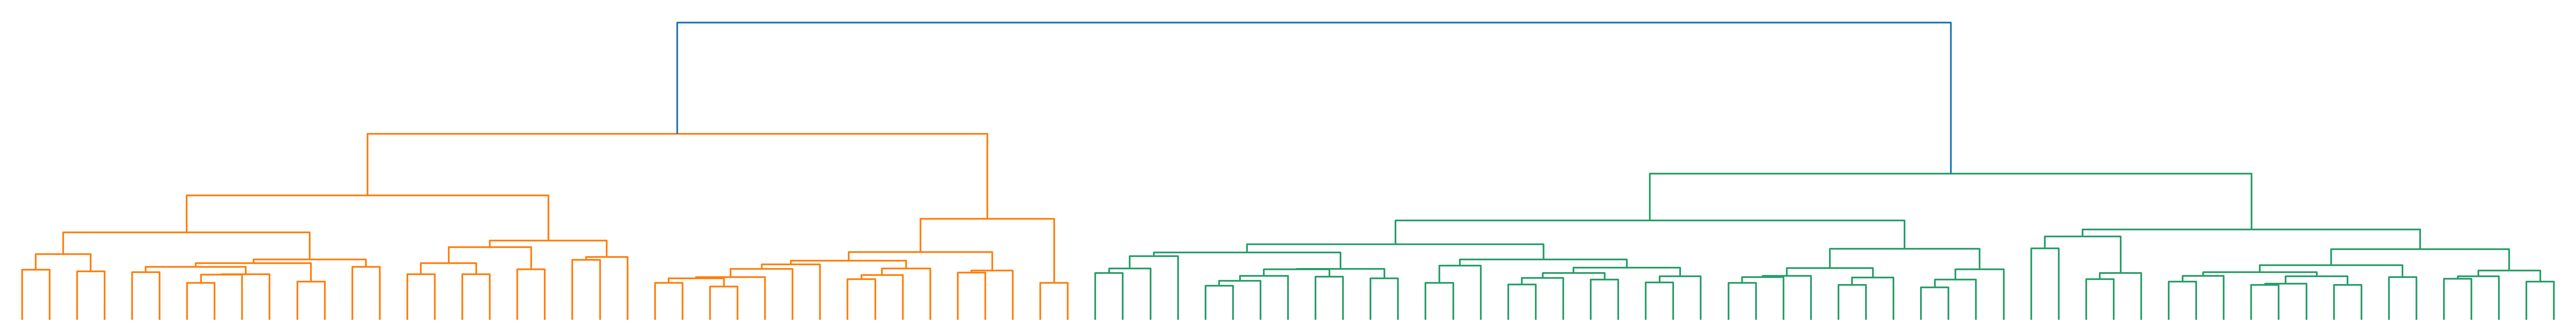

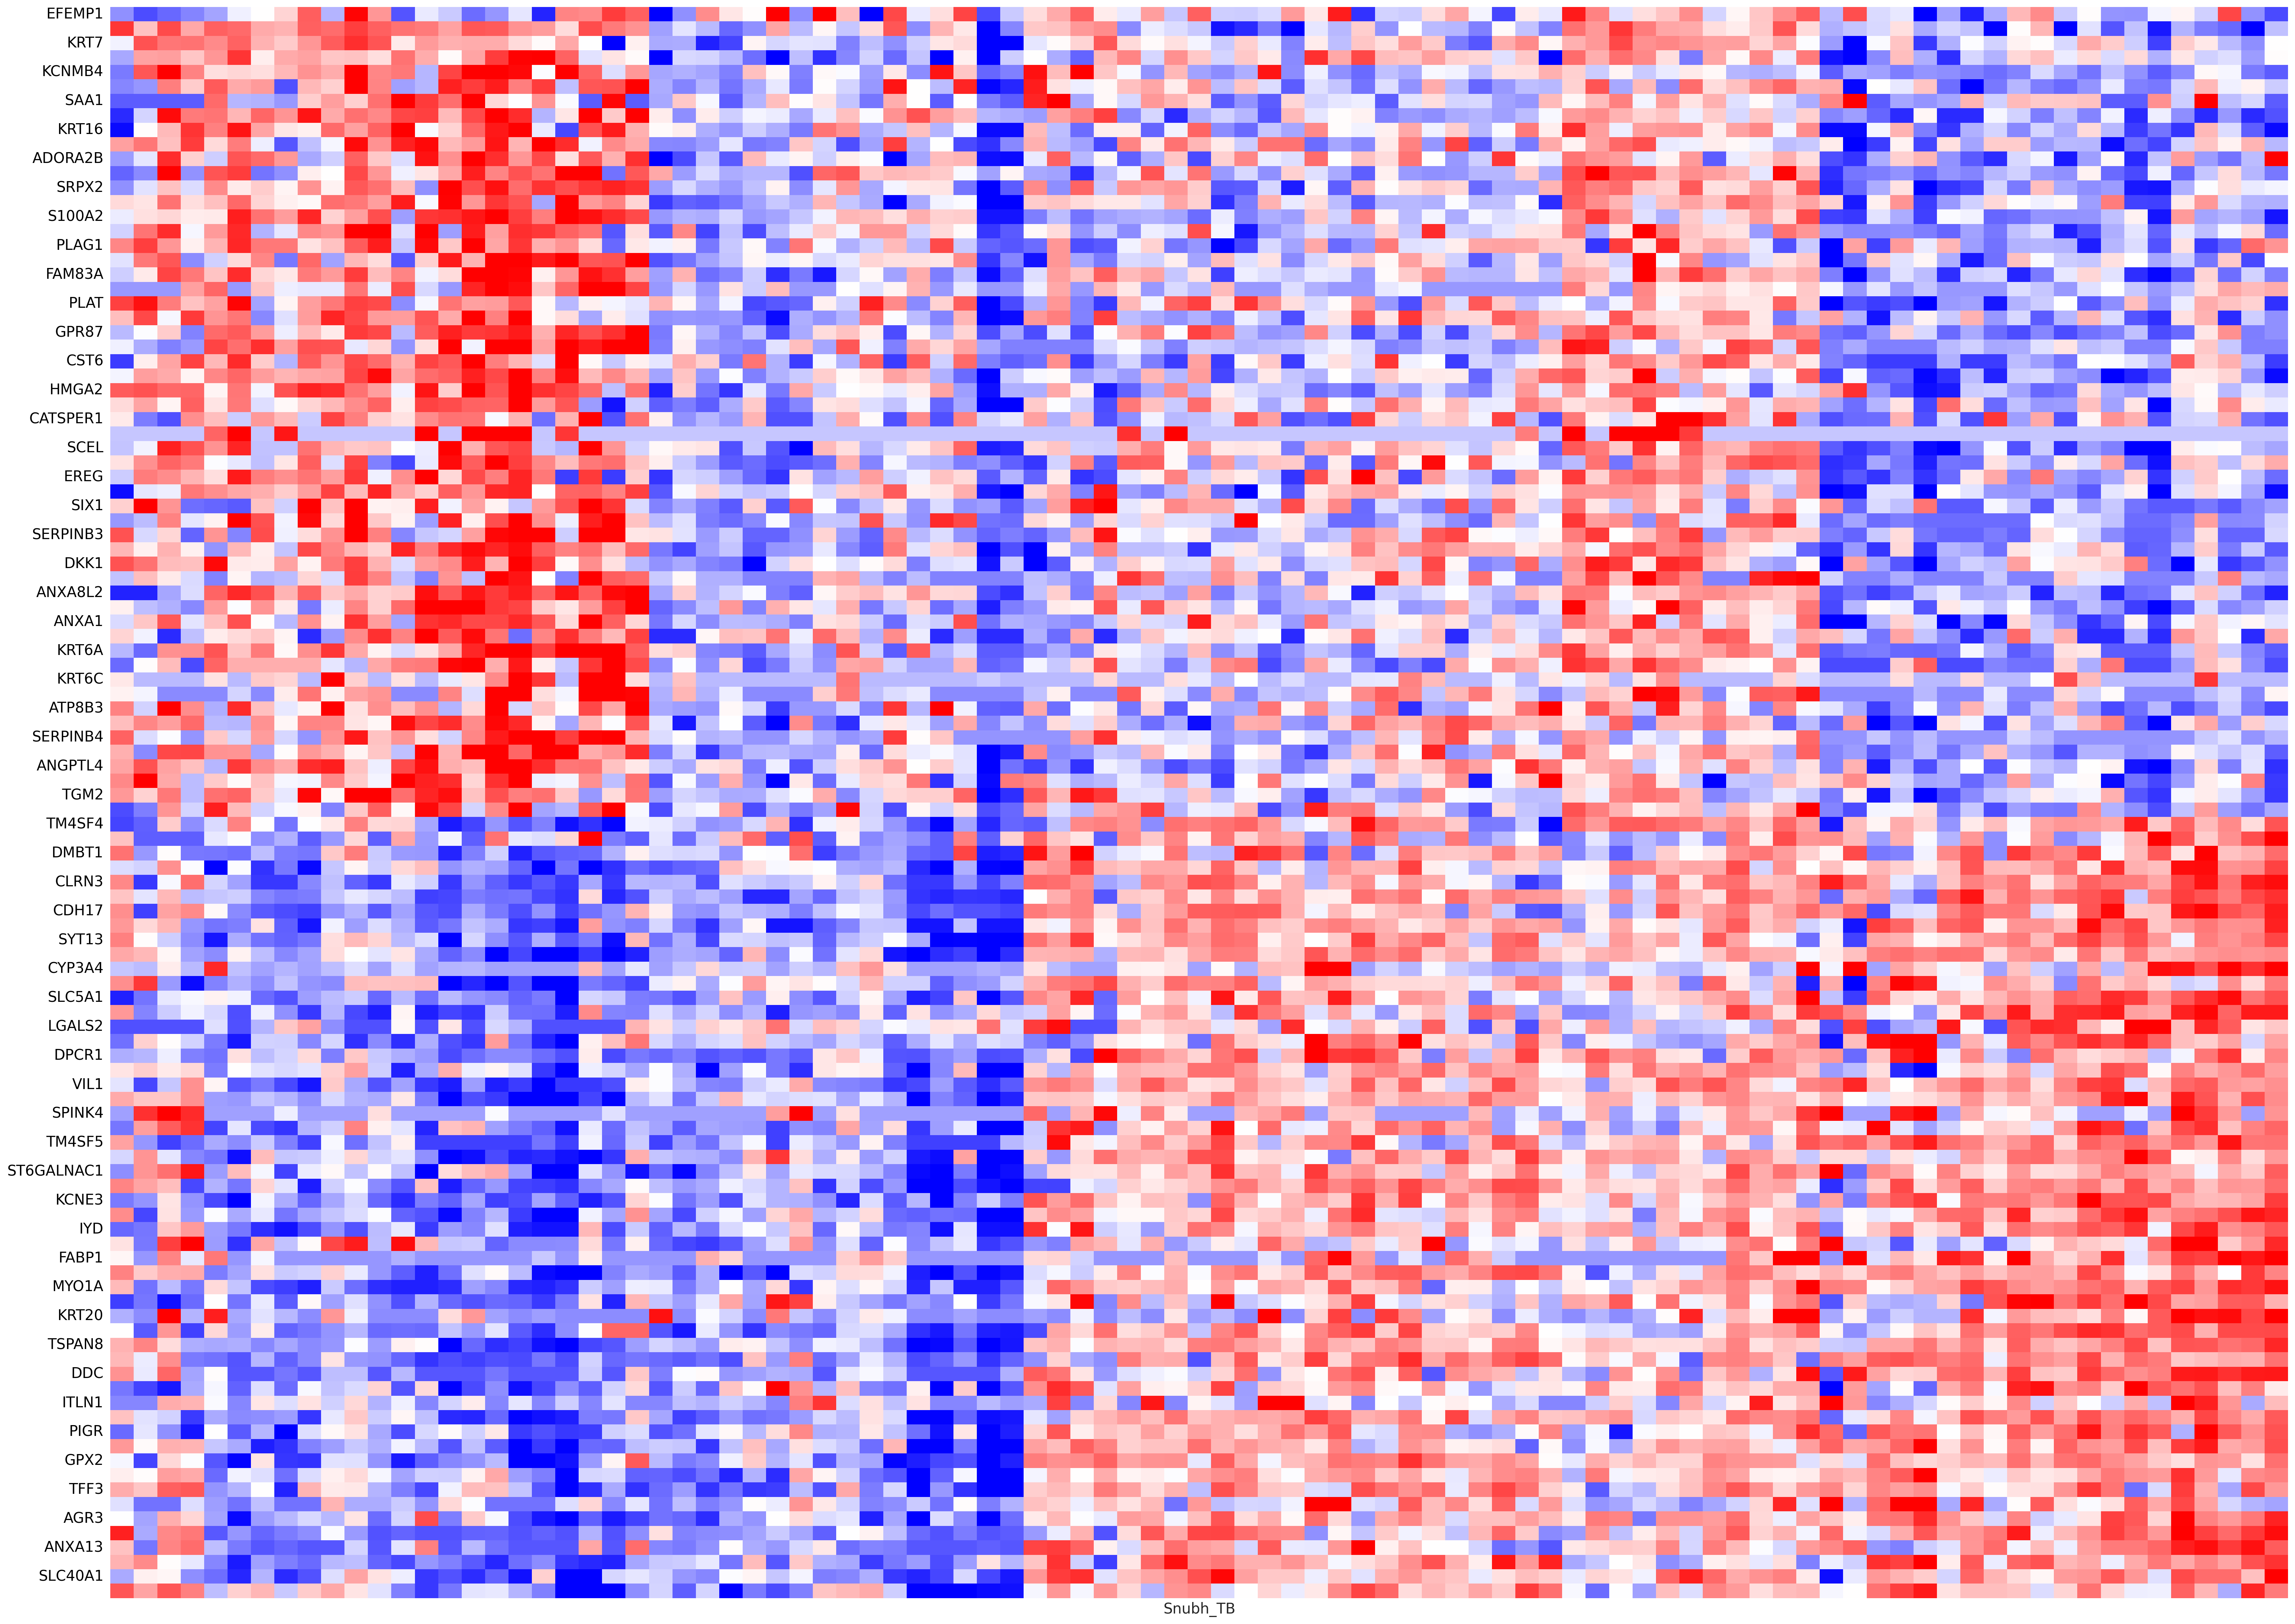

{'20-T00814_FT-01': 'C1',
 '21-T00963_FT-01': 'C1',
 '20-T00375_FO-01': 'C1',
 '19-T00506_FO-01': 'C1',
 '20-T00330_FO-01': 'C1',
 '18-02904_FO-01': 'C1',
 '21-T00687_FT-01': 'C1',
 '21-T00771_FT-01': 'C1',
 '19-T00385_FO-01': 'C1',
 '19-T00017_FO-01': 'C1',
 '19-T00201_FO-01': 'C1',
 '19-T00126_FO-01': 'C1',
 '21-T00266_FT-01': 'C1',
 '21-T00583_FT-01': 'C1',
 '21-T00817_FT-01': 'C1',
 '18-00447_FO-01': 'C1',
 '18-01500_FO-01': 'C1',
 '20-T00115_FO-01': 'C1',
 '20-T00851_FT-01': 'C1',
 '20-T00311_FO-01': 'C1',
 '21-T00277_FT-01': 'C1',
 '19-T00668_FO-01': 'C1',
 '19-T00545_FO-01': 'C1',
 '19-T00494_FO-01': 'C1',
 '19-T00380_FO-01': 'C1',
 '21-T00611_FT-01': 'C1',
 '21-T00882_FT-01': 'C1',
 '22-T00007_FT-01': 'C1',
 '19-T00073_FO-01': 'C1',
 '19-T00620_FO-01': 'C1',
 '18-01501_FO-01': 'C1',
 '19-T00062_FO-01': 'C1',
 '20-T00360_FO-01': 'C1',
 '19-T00737_FO-01': 'C1',
 '21-T00987_FT-01': 'C1',
 '20-T00073_FO-01': 'C1',
 '21-T00999_FT-01': 'C1',
 '21-T00639_FT-01': 'C1',
 '21-T00800_FT-0

In [53]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from mycolorpy import colorlist as mcp
sc.settings.set_figure_params(dpi=100, figsize=(10,5), fontsize=18)

plt.figure(figsize=(40, 5))
linked = linkage(SNU_exp_df, method='ward', metric='euclidean', optimal_ordering=True)
res = dendrogram(linked, orientation='top', labels=SNU_exp_df.T.columns,
            distance_sort='descending', color_threshold=50,
            show_leaf_counts=True)
# res = dendrogram(linked, orientation='top', labels=SNU_exp_df.T.columns,
#             distance_sort='descending', link_color_func=lambda k: link_cols[k],
#             show_leaf_counts=True)

plt.box(False)
plt.yticks([])
plt.xticks([])
plt.show()

sc.settings.set_figure_params(dpi=100, figsize=(40,40), fontsize=15)
plt.figure(figsize=(40, 30))
sns.heatmap(SNU_exp_df.T.loc[:,res['ivl']], cmap='bwr', vmin=-2, vmax=2, cbar=False)
#plt.yticks([])
plt.xticks([])
plt.show()

Moffitt = dict()
Moffitt['C1'] = 'BasalLike'
Moffitt['C2'] = 'Classical'

mapping_cluster = dict(zip(res['ivl'], res['leaves_color_list']))
mapping_cluster

In [62]:
order = list(reversed(list(mapping_cluster.keys())))
pd.DataFrame(order,columns=['Moffitt_order']).to_csv('Moffitt_order.csv')

In [187]:
# g = sns.clustermap(SNU_exp_df.T, row_cluster=False, xticklabels=True,figsize=(50,30),cmap='bwr',method='ward', vmin=-2, vmax=2)

In [292]:
SNU_adata.obs['MoffittType'] = SNU_adata.obs.index.map(mapping_cluster).map(Moffitt)
SNU_adata.obs

N0       PID       dateA         Snubh_BB  \
Snubh_TB                                                         
20-T00330_FO-01  sb2441  32644755  2020-05-15  20-B01156_EB-03   
19-T00062_FO-01  sb1947  10108754  2019-03-18  19-B00635_EB-03   
20-T00814_FT-01  sb2669  33563897  2020-12-16  20-B04522_EB-04   
19-T00201_FO-01  sb2097  24118798  2019-05-27              NaN   
19-T00505_FO-01  sb2298  31651231  2019-09-09  19-B02081_EB-03   
...                 ...       ...         ...              ...   
21-T00576_FT-01     NaN  10805327  2021-07-23              NaN   
19-T00620_FO-01  sb2342  31927356  2019-10-30  19-B02516_EB-03   
19-T00413_FO-01  sb2283  31464792  2019-08-06  19-B01826_EB-03   
20-T00073_FO-01  sb1988  11769796  2020-02-03  20-B00280_EB-03   
19-T00119_FO-01  sb2223  30981162  2019-04-30              NaN   

                pathology_number tumorcellularity(pathology)  DNA_RNA  \
Snubh_TB                                                                
20-T00330_FO-01      S 200019390                          25  DNA+RNA   
19-T00062_FO-01      S 190013089                          45  DNA+RNA   
20-T00814_FT-01      S 200053444                          35  DNA+RNA   
19-T00201_FO-01      S 190025387                          40      RNA   
19-T00505_FO-01      S 190043830                          50  DNA+RNA   
...                          ...                         ...      ...   
21-T00576_FT-01      S 210032997                         NaN      RNA   
19-T00620_FO-01      S 190052008                          35  DNA+RNA   
19-T00413_FO-01      S 190038136                          20  DNA+RNA   
20-T00073_FO-01      S 200005133                          45  DNA+RNA   
19-T00119_FO-01      S 190021043                           5      RNA   

                 methylSeq  metagenomic liquid_number  ...  \
Snubh_TB                                               ...   
20-T00330_FO-01        NaN          NaN          R167  ...   
19-T00062_FO-01        NaN          NaN           NaN  ...   
20-T00814_FT-01        NaN          NaN          R201  ...   
19-T00201_FO-01        NaN          NaN          R017  ...   
19-T00505_FO-01        NaN          NaN          R074  ...   
...                    ...          ...           ...  ...   
21-T00576_FT-01        NaN          NaN           NaN  ...   
19-T00620_FO-01        NaN          NaN          R106  ...   
19-T00413_FO-01        NaN          NaN           NaN  ...   
20-T00073_FO-01        NaN          NaN           NaN  ...   
19-T00119_FO-01        NaN          NaN           NaN  ...   

                 CTx_response_GNP_2L total_CTx_response  clinical_setting  \
Snubh_TB                                                                    
20-T00330_FO-01                  NaN                NaN                OP   
19-T00062_FO-01                  NaN                NaN   pall CTx or BSC   
20-T00814_FT-01                  2.0                NaN   pall CTx or BSC   
19-T00201_FO-01                  NaN                NaN   pall CTx or BSC   
19-T00505_FO-01                  NaN                NaN                OP   
...                              ...                ...               ...   
21-T00576_FT-01                  NaN                NaN   pall CTx or BSC   
19-T00620_FO-01                  2.0                NaN   pall CTx or BSC   
19-T00413_FO-01                  NaN                NaN                OP   
20-T00073_FO-01                  4.0                NaN   pall CTx or BSC   
19-T00119_FO-01                  NaN                NaN                OP   

                EFS_event  EFS_F  OS_event  OS_F     stage_2  Dataset  \
Snubh_TB                                                                
20-T00330_FO-01       0.0   19.0         0  26.7   LOCALIZED      SNU   
19-T00062_FO-01       1.0    7.2         1   7.2   LOCALIZED      SNU   
20-T00814_FT-01       1.0    3.3         1   8.3   LOCALIZED      SNU   
19-T00201_FO-01       1.0   15.3      

In [295]:
# SNU_annot = pd.read_csv('ALL_TYPE2.csv',index_col=0)
# SNU_annot['MoffittType'] = SNU_adata.obs['MoffittType']
# SNU_annot.to_csv('ALL_TYPE2.csv')

In [302]:
# SNU_annot = pd.read_csv('ALL_TYPE2.csv',index_col=0)
# SNU_annot
# CD = dict()
# CD['BasalLike B'] = 'BasalLike-B'
# CD['BasalLike A'] = 'BasalLike-A'
# CD['Hybrid'] = 'Hybrid'
# CD['Classical-B'] = 'Classical-B'
# CD['Classical-A'] = 'Classical-A'
# SNU_annot['MichelleType'] = SNU_annot['MichelleType'].map(CD)
# SNU_annot.to_csv('ALL_TYPE2.csv')
# SNU_annot

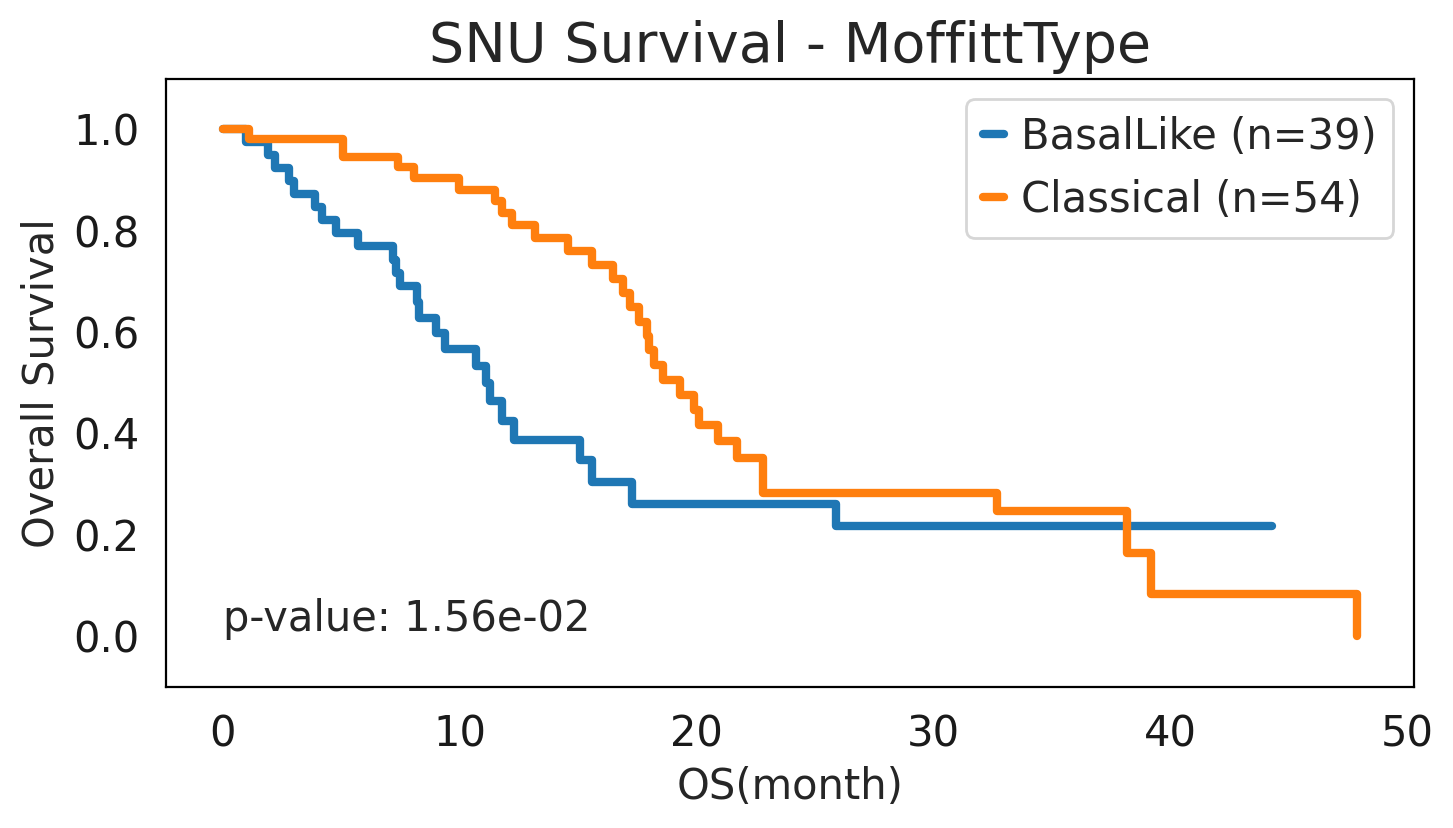

'1.56e-02'

In [293]:
snu_df2 = SNU_adata.obs.copy()
km_plot_multi(df_info=snu_df2, category='MoffittType', os='OS_F', event='OS_event', title='SNU Survival - MoffittType')

In [37]:
Bailey = list(snu_df1['Bailey-type-EL'])

In [38]:
snu_df2['BaileyType'] = Bailey
snu_df2.loc[:,['MoffittType', 'BaileyType']]

MoffittType             BaileyType
Snubh_TB                                          
20-T00330_FO-01   BasalLike               Squamous
19-T00062_FO-01   BasalLike                   ADEX
20-T00814_FT-01   Classical  Pancreatic Progenitor
19-T00201_FO-01   BasalLike               Squamous
19-T00505_FO-01   Classical  Pancreatic Progenitor
...                     ...                    ...
21-T00576_FT-01   Classical            Immunogenic
19-T00620_FO-01   BasalLike            Immunogenic
19-T00413_FO-01   Classical  Pancreatic Progenitor
20-T00073_FO-01   BasalLike            Immunogenic
19-T00119_FO-01   Classical                   ADEX

[93 rows x 2 columns]

In [279]:
def km_plot(df_info, category, os, event, title='', order=None):
    i=0
    kmf = lifelines.KaplanMeierFitter()
    #plt.figure(figsize=(8,4))
    #ax = plt.gca()
    m = ~df_info[category].isna()
    df_info = df_info[m]
    category_vals = list(df_info[category].unique())
    
    if len(category_vals) > 6:
        colormap=mcp.gen_color(cmap="Set2",n=len(category_vals))
    else:
        colormap=mcp.gen_color(cmap="Set2",n=6)
    
    
    median_os = df_info[os].median()
    group_os = dict()
    for val in category_vals:
        m = df_info[category] == val
        count = sum(m)
        label = "{} (n={})".format(val,count)
        T_exp, E_exp = df_info.loc[m,os], df_info.loc[m,event]
        kmf.fit(T_exp, E_exp, label=label)
        time = kmf.predict(median_os)
        group_os[val]=time

    m_survival = pd.DataFrame.from_dict(group_os, orient='index', columns=['m_survival']).sort_values(by='m_survival', ascending=True)
    sorted_category = list(m_survival.index)
    
    if order:
        sorted_category = order
    
    for val in sorted_category:
        m = df_info[category] == val
        count = sum(m)
        label = "{} (n={})".format(val,count)
        T_exp, E_exp = df_info.loc[m,os], df_info.loc[m,event]
        kmf.fit(T_exp, E_exp, label=label)
        kmf.plot_survival_function(ci_show=False, linewidth=3, show_censors=False, color=colormap[i])
        i+=1
        

    result = multivariate_logrank_test(df_info[os], df_info[category], df_info[event])
    p_val="{:.2e}".format(result.p_value)
    plt.text(0, 0.05, 'p-value: {}'.format(p_val), fontsize=15)
    if title=='':
        title = 'KM Plot - {}'.format(category)
    plt.title(title, fontsize=20)
    plt.xlabel('Time (month)',fontsize=15)
    plt.ylabel('Overall Survival',fontsize=15)
    plt.ylim((0,1.03))
    plt.show()
    return p_val

In [644]:
SNU_adata = sc.read_h5ad('SNU_AnnDataForm_20220814.h5ad')
SNU_adata.obs['Dataset'] = 'SNU'
SNU_genes = list(SNU_adata.to_df().columns)
sc.pp.log1p(SNU_adata)

geneset = ['KRT5', 'KRT6A', 'KRT14', 'TP63', 'FOXJ1', 'DRC1', 'C12orf55', 'CST6', 'VSIG1', 'ANXA10', 'GATA6', 'LYZ', 'SPINK4', 'REG4', 'BTNL8', 'KRT20']
chan_geneset = geneset
exp = SNU_adata.to_df().loc[:,geneset]
obs = SNU_adata.obs.copy()
scaled_df = pd.DataFrame(scaler.fit_transform(exp), columns=exp.columns, index=exp.index).T
scaled_df

Snubh_TB  20-T00330_FO-01  19-T00062_FO-01  20-T00814_FT-01  19-T00201_FO-01  \
KRT5             1.455018         1.318780        -0.118441        -0.181707   
KRT6A            1.339603         1.339830        -0.552282         0.678383   
KRT14            2.081876         2.299143        -0.006227         0.643120   
TP63             0.955421         1.250138        -0.454106         1.202486   
FOXJ1            1.202284         0.770837        -0.944340        -0.090296   
DRC1             0.484148        -0.717844        -0.717844         0.984053   
C12orf55         1.214185         0.720622        -0.368056         0.633808   
CST6             0.550145        -0.604754        -1.527099         1.429070   
VSIG1           -1.450060         0.281381         0.250075         0.386773   
ANXA10          -0.606320        -0.350590         0.956471        -0.016766   
GATA6           -1.705261        -0.923969         0.392224        -0.766365   
LYZ             -0.947040        -0.682440         0.596144        -0.508199   
SPINK4          -0.743717         0.247704        -0.743717        -0.743717   
REG4            -1.298933        -0.013389         1.744949        -0.796749   
BTNL8           -0.312160        -0.934723         0.797917        -1.422717   
KRT20            1.758226        -0.347021        -0.615049        -0.120323   

Snubh_TB  19-T00505_FO-01  20-T00764_FT-01  20-T00577_FT-01  21-T00687_FT-01  \
KRT5            -0.041225        -0.989397        -0.444391         1.635775   
KRT6A           -0.081449        -1.272211        -0.880216         1.038993   
KRT14           -0.542837        -0.733644        -0.733644        -0.139445   
TP63            -0.212096         0.128032         1.360957         1.723799   
FOXJ1           -1.062649        -0.710969         0.305838        -1.016965   
DRC1            -0.717844        -0.717844         0.263128        -0.717844   
C12orf55        -0.960257        -1.274239        -0.874720         0.413667   
CST6            -0.316375        -0.232919        -1.527099         0.395514   
VSIG1            0.764942         1.397149         1.115774         0.480847   
ANXA10           0.372591         1.384299         0.867069         0.338757   
GATA6            0.011960         1.601659         0.505607        -0.798958   
LYZ              0.187967         0.664029         1.054082        -0.749310   
SPINK4          -0.129074        -0.114160        -0.743717        -0.743717   
REG4             0.266783         1.240872         1.463605        -1.190887   
BTNL8           -0.026176         0.747637        -0.529059        -0.123260   
KRT20           -0.520803         0.050894        -0.534977        -0.219269   

Snubh_TB  21-T00771_FT-01  18-01500_FO-01  ...  19-T00380_FO-01  \
KRT5             0.735377        2.053119  ...         0.118446   
KRT6A            0.058080        2.266097  ...         0.378563   
KRT14            0.248728        3.561909  ...        -0.733644   
TP63             0.335529        2.095183  ...        -0.933249   
FOXJ1           -0.614082       -0.359922  ...        -0.259419   
DRC1             0.367007       -0.717844  ...         0.734534   
C12orf55         0.195661        0.128039  ...        -0.321016   
CST6            -0.584101        1.004078  ...         0.630872   
VSIG1           -0.542687       -0.858331  ...        -0.812170   
ANXA10          -0.213830       -0.807193  ...        -0.784709   
GATA6           -0.124340       -0.436175  ...        -1.580545   
LYZ             -1.003826       -1.690112  ...        -0.403478   
SPINK4          -0.127396       -0.040983  ...        -0.743717   
REG4            -1.027467       -1.209133  ...        -0.983489   
BTNL8           -0.874815       -0.393500  ...        -0.649681   
KRT20           -0.549474       -0.720864  ...        -0.902760   

Snubh_TB  19-T00573_FO-01  20-T00105_FO-01  21-T00511_FT-01  22-T00038_FT-01  \
KRT5            -0.989397        -0.989397        -0.48849

In [643]:
len(geneset)

16

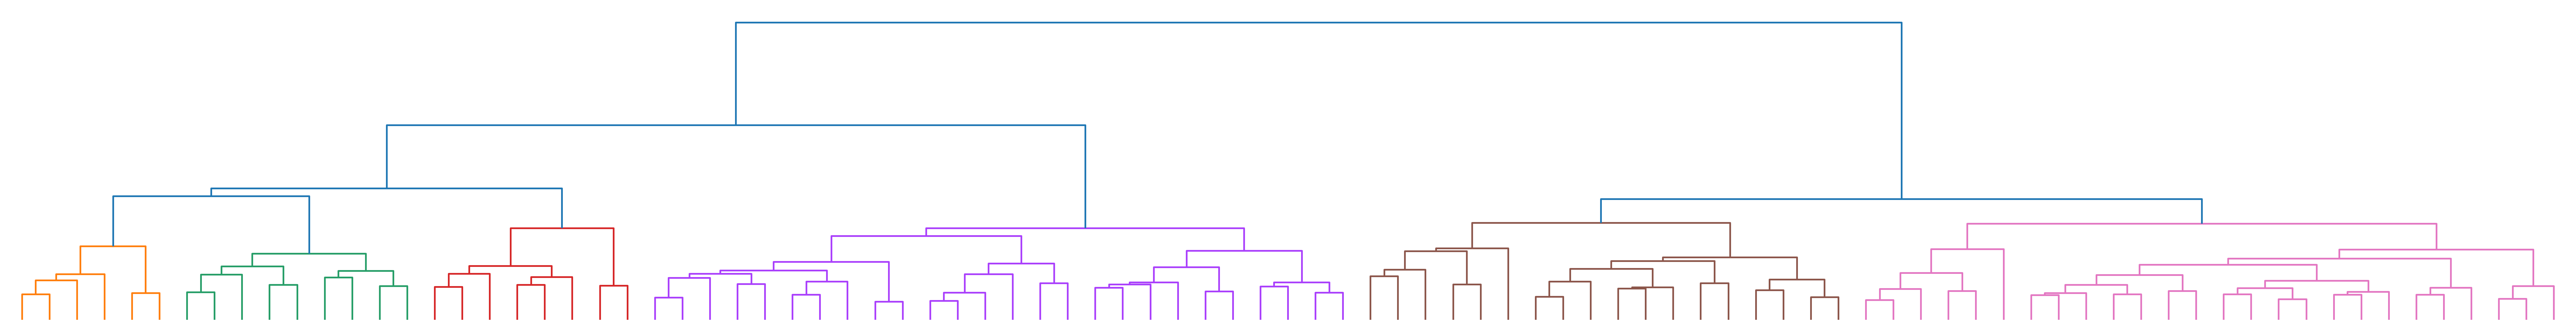

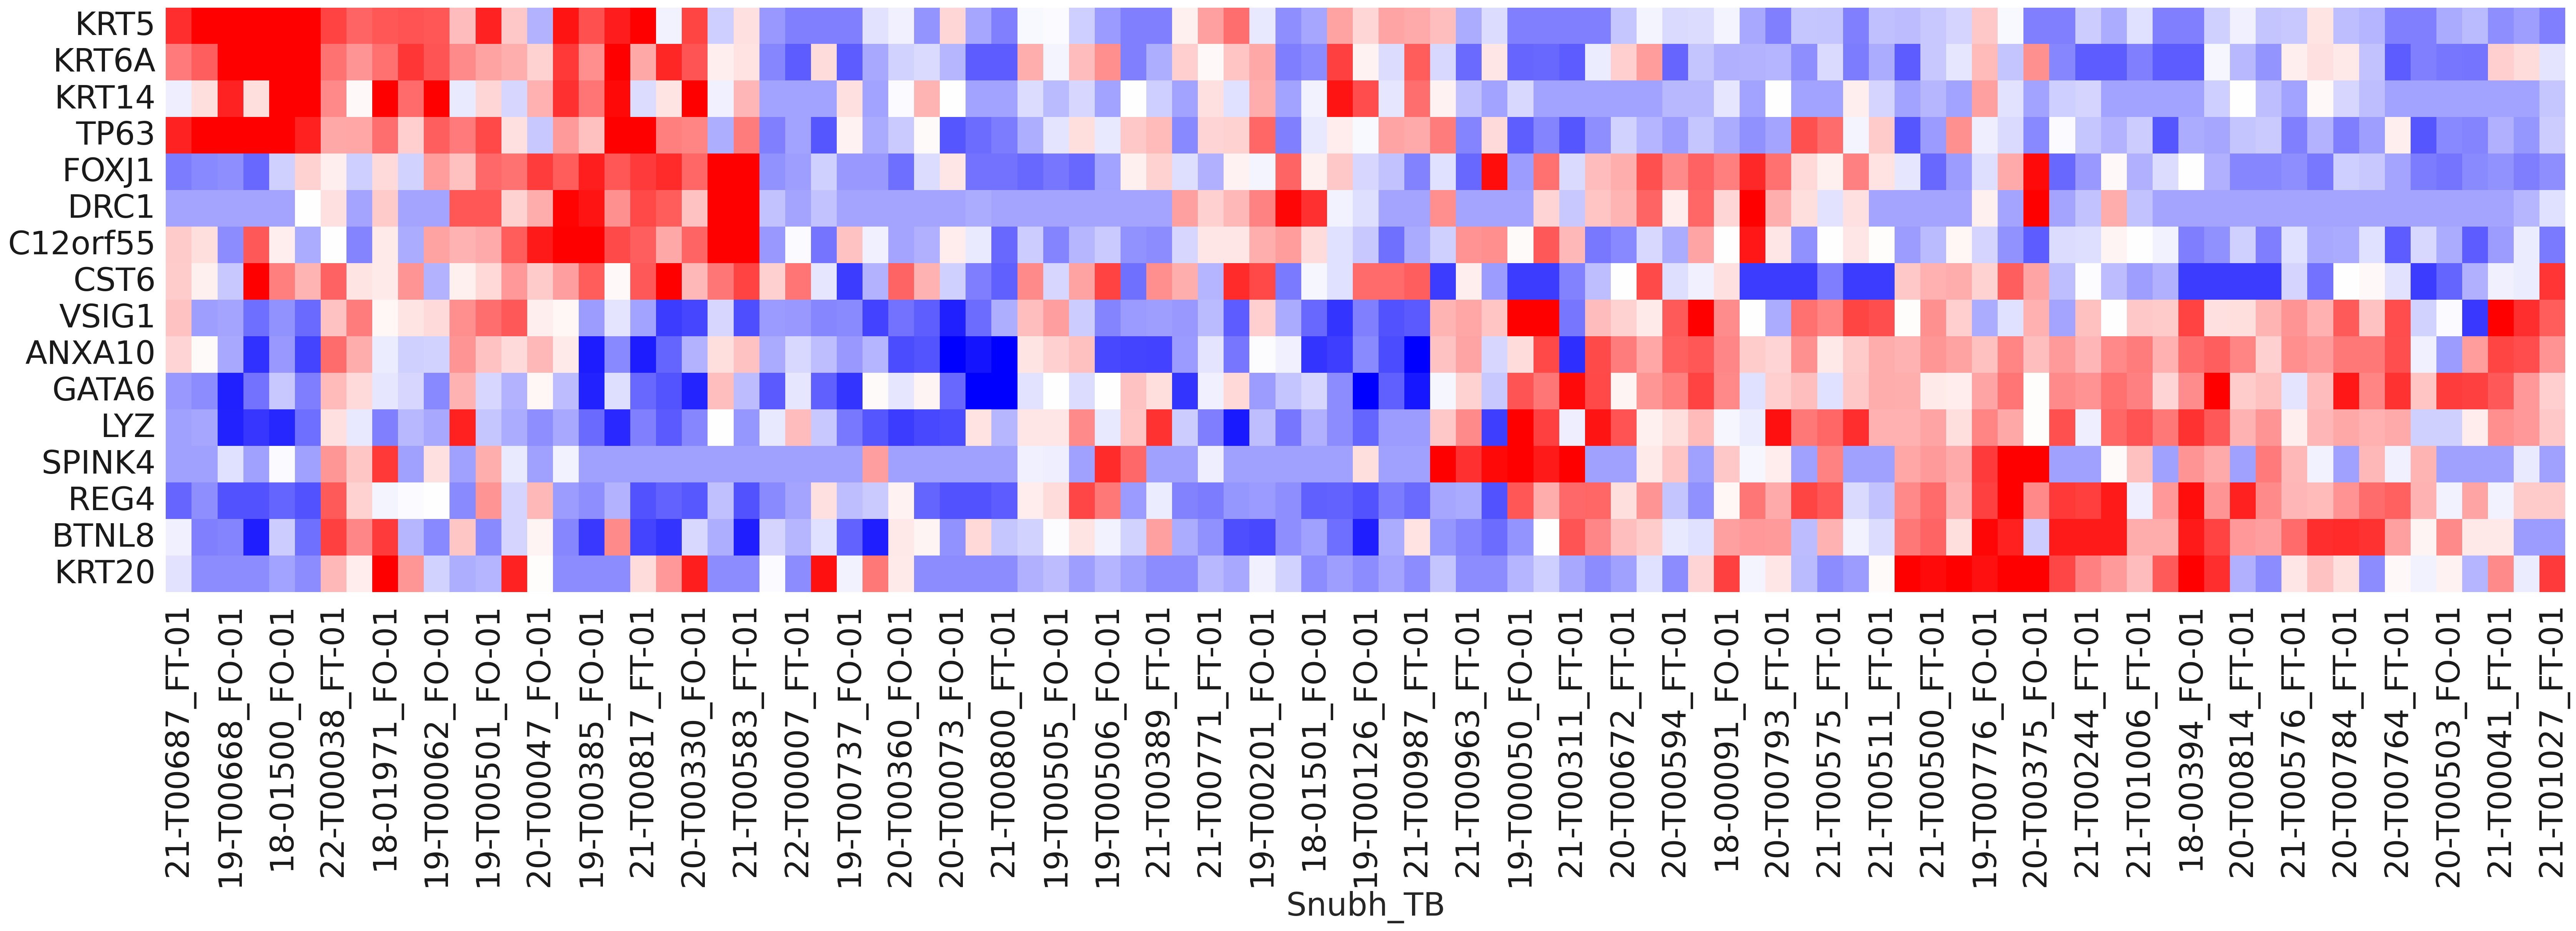

{'21-T00687_FT-01': 'C1',
 '19-T00545_FO-01': 'C1',
 '19-T00668_FO-01': 'C1',
 '20-T00311_FO-01': 'C1',
 '18-01500_FO-01': 'C1',
 '20-T00115_FO-01': 'C1',
 '22-T00038_FT-01': 'C2',
 '20-T00027_FO-01': 'C2',
 '18-01971_FO-01': 'C2',
 '19-T00017_FO-01': 'C2',
 '19-T00062_FO-01': 'C2',
 '21-T00875_FT-01': 'C2',
 '19-T00501_FO-01': 'C2',
 '19-T00489_FO-01': 'C2',
 '20-T00047_FO-01': 'C2',
 '20-T00063_FO-01': 'C3',
 '19-T00385_FO-01': 'C3',
 '21-T00277_FT-01': 'C3',
 '21-T00817_FT-01': 'C3',
 '18-00447_FO-01': 'C3',
 '20-T00330_FO-01': 'C3',
 '19-T00714_FO-01': 'C3',
 '21-T00583_FT-01': 'C3',
 '21-T00611_FT-01': 'C4',
 '22-T00007_FT-01': 'C4',
 '19-T00494_FO-01': 'C4',
 '19-T00737_FO-01': 'C4',
 '19-T00073_FO-01': 'C4',
 '20-T00360_FO-01': 'C4',
 '21-T00266_FT-01': 'C4',
 '20-T00073_FO-01': 'C4',
 '21-T00639_FT-01': 'C4',
 '21-T00800_FT-01': 'C4',
 '21-T00346_FT-01': 'C4',
 '19-T00505_FO-01': 'C4',
 '20-T00823_FT-01': 'C4',
 '19-T00506_FO-01': 'C4',
 '19-T00573_FO-01': 'C4',
 '21-T00389_FT-

In [277]:

sc.settings.set_figure_params(dpi=100, figsize=(10,5), fontsize=18)

method = 'ward'

# row_linkage = hierarchy.linkage(
#     distance.pdist(scaled_df), method='median')

# col_linkage = hierarchy.linkage(
#     distance.pdist(scaled_df.T), method=method)

# sns.clustermap(scaled_df, row_cluster=False, col_linkage=col_linkage, method=method, metric='euclidean',
#                figsize=(30, 13))
# plt.show()



plt.figure(figsize=(40, 5))
linked = linkage(scaled_df.T, method=method, metric='euclidean', optimal_ordering=True)
res = dendrogram(linked, orientation='top', labels=scaled_df.columns,
            distance_sort='descending', color_threshold=10,
            show_leaf_counts=True)
plt.box(False)
plt.yticks([])
plt.xticks([])
plt.show()

sc.settings.set_figure_params(dpi=100, figsize=(40,10), fontsize=30)
plt.figure(figsize=(40, 10))
sns.heatmap(scaled_df.loc[:,res['ivl']], cmap='bwr', vmin=-2, vmax=2, cbar=False)
#plt.yticks([])
#plt.xticks([])
plt.show()

mapping_cluster = dict(zip(res['ivl'], res['leaves_color_list']))
mapping_cluster

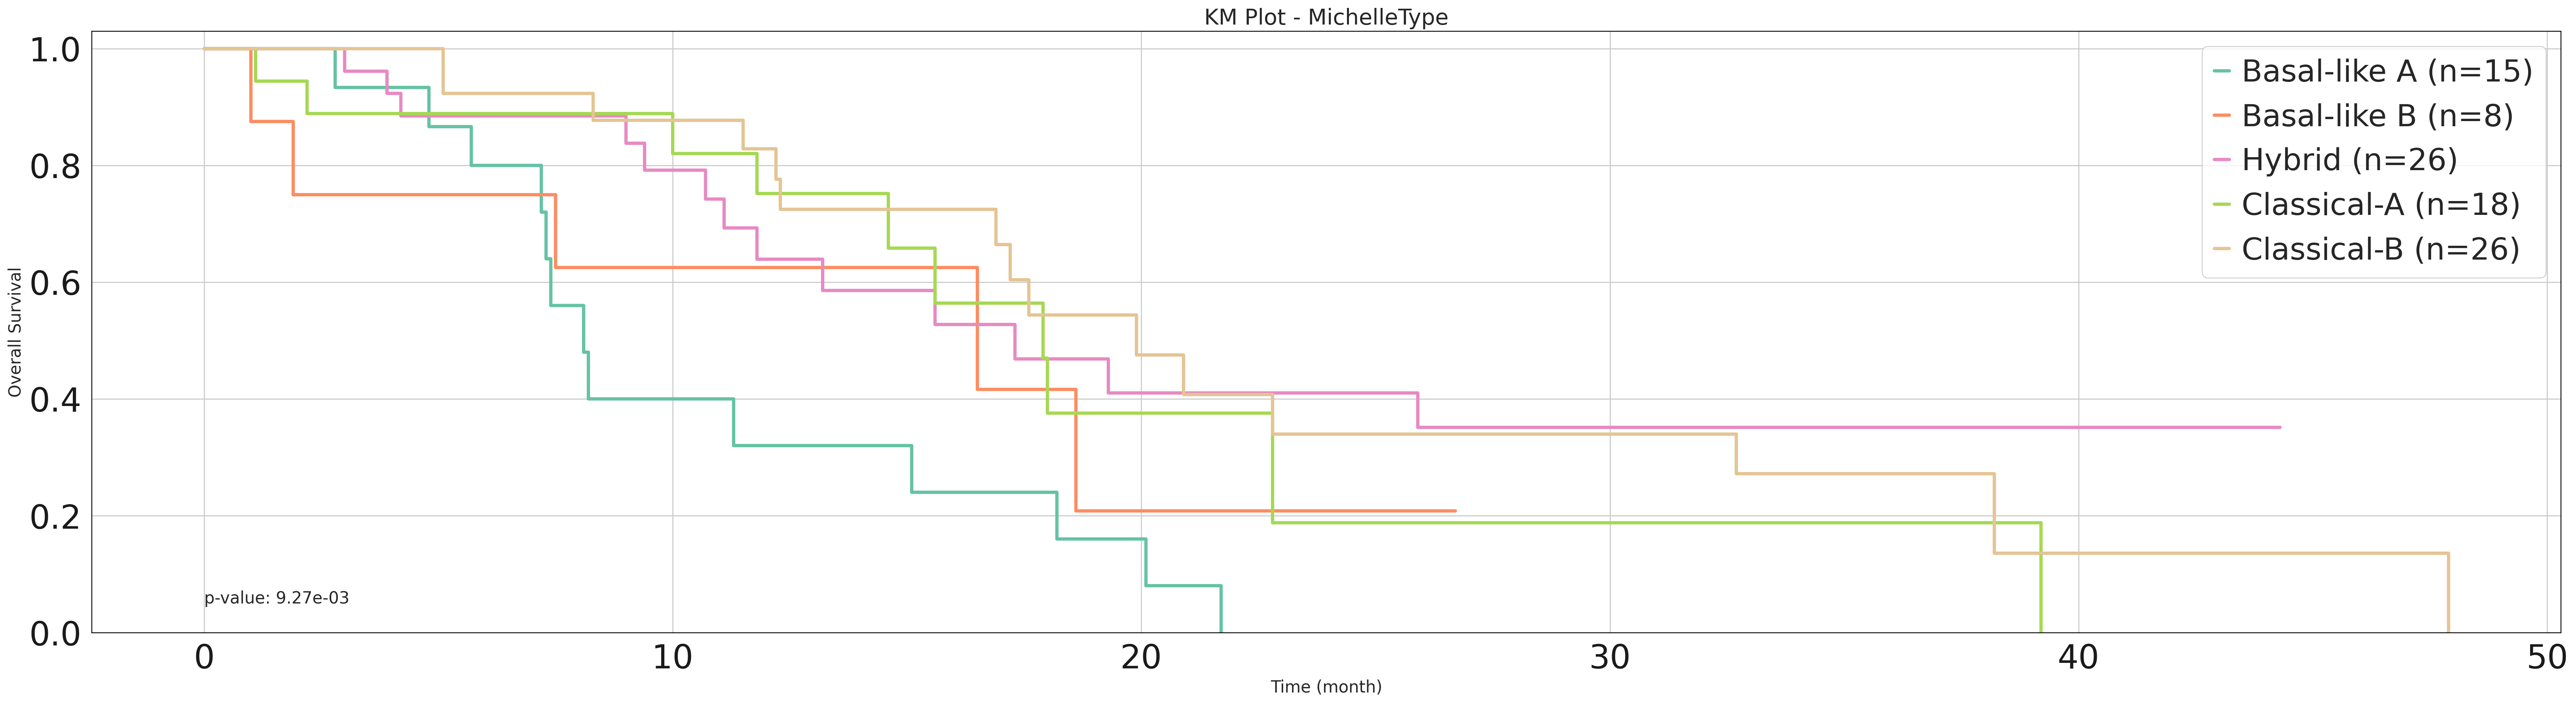

'9.27e-03'

In [280]:
obs = SNU_adata.obs.copy()
obs['Michelle'] = obs.index.map(mapping_cluster)
mapping_dict = dict()
mapping_dict['C1']='Basal-like A'
mapping_dict['C2']='Basal-like A'
mapping_dict['C3']='Basal-like B'
mapping_dict['C4']='Hybrid'
mapping_dict['C5']='Classical-A'
mapping_dict['C6']='Classical-B'
obs['MichelleType'] = obs['Michelle'].map(mapping_dict)
km_plot(df_info=obs, category='MichelleType', os='OS_F', event='OS_event')

In [55]:
# tmp = pd.read_csv('ALL_TYPE2.csv', index_col=0)
# tmp['MichelleType'] = obs['MichelleType']
# tmp.to_csv('ALL_TYPE2.csv')

In [ ]:
SNU_adata = sc.read_h5ad('SNU_AnnDataForm_20220814.h5ad')
SNU_adata.obs['Dataset'] = 'SNU'
SNU_genes = list(SNU_adata.to_df().columns)
sc.pp.log1p(SNU_adata)















In [108]:
SNU_type = pd.read_csv('SNU_subtype.csv',index_col=0)
other = snu_df2.loc[:,['MoffittType', 'BaileyType']]

In [109]:
SNU_type

SNU_2subtype SNU_3subtype
20    Subtype_1    Subtype_1
19    Subtype_1    Subtype_1
20    Subtype_0    Subtype_0
19    Subtype_1    Subtype_0
19    Subtype_0    Subtype_0
..          ...          ...
21    Subtype_0    Subtype_0
19    Subtype_1    Subtype_0
19    Subtype_0    Subtype_0
20    Subtype_1    Subtype_1
19    Subtype_0    Subtype_0

[93 rows x 2 columns]

In [110]:
other['SNU_3subtype'] = list(SNU_type['SNU_3subtype'])
other

MoffittType             BaileyType SNU_3subtype
Snubh_TB                                                       
20-T00330_FO-01   BasalLike               Squamous    Subtype_1
19-T00062_FO-01   BasalLike                   ADEX    Subtype_1
20-T00814_FT-01   Classical  Pancreatic Progenitor    Subtype_0
19-T00201_FO-01   BasalLike               Squamous    Subtype_0
19-T00505_FO-01   Classical  Pancreatic Progenitor    Subtype_0
...                     ...                    ...          ...
21-T00576_FT-01   Classical            Immunogenic    Subtype_0
19-T00620_FO-01   BasalLike            Immunogenic    Subtype_0
19-T00413_FO-01   Classical  Pancreatic Progenitor    Subtype_0
20-T00073_FO-01   BasalLike            Immunogenic    Subtype_1
19-T00119_FO-01   Classical                   ADEX    Subtype_0

[93 rows x 3 columns]

In [111]:
other.to_csv('ALL_TYPE.csv')

In [645]:
up_markers = pd.read_csv('PostiveMarkers_in_3_Dataset.csv',index_col=0)
up_markers['Type'] = 'Tumor_Pos'
down_markers = pd.read_csv('NegativeMarkers_in_3_Dataset.csv',index_col=0)
down_markers['Type'] = 'Tumor_Neg'

tumor_features = list(up_markers['ALL COMMON UP-Regulated geneset'])+list(down_markers['ALL COMMON Down-Regulated geneset'])
len(tumor_features)

110

In [657]:
len(Bailey_PS_genes)

269

<AxesSubplot:>

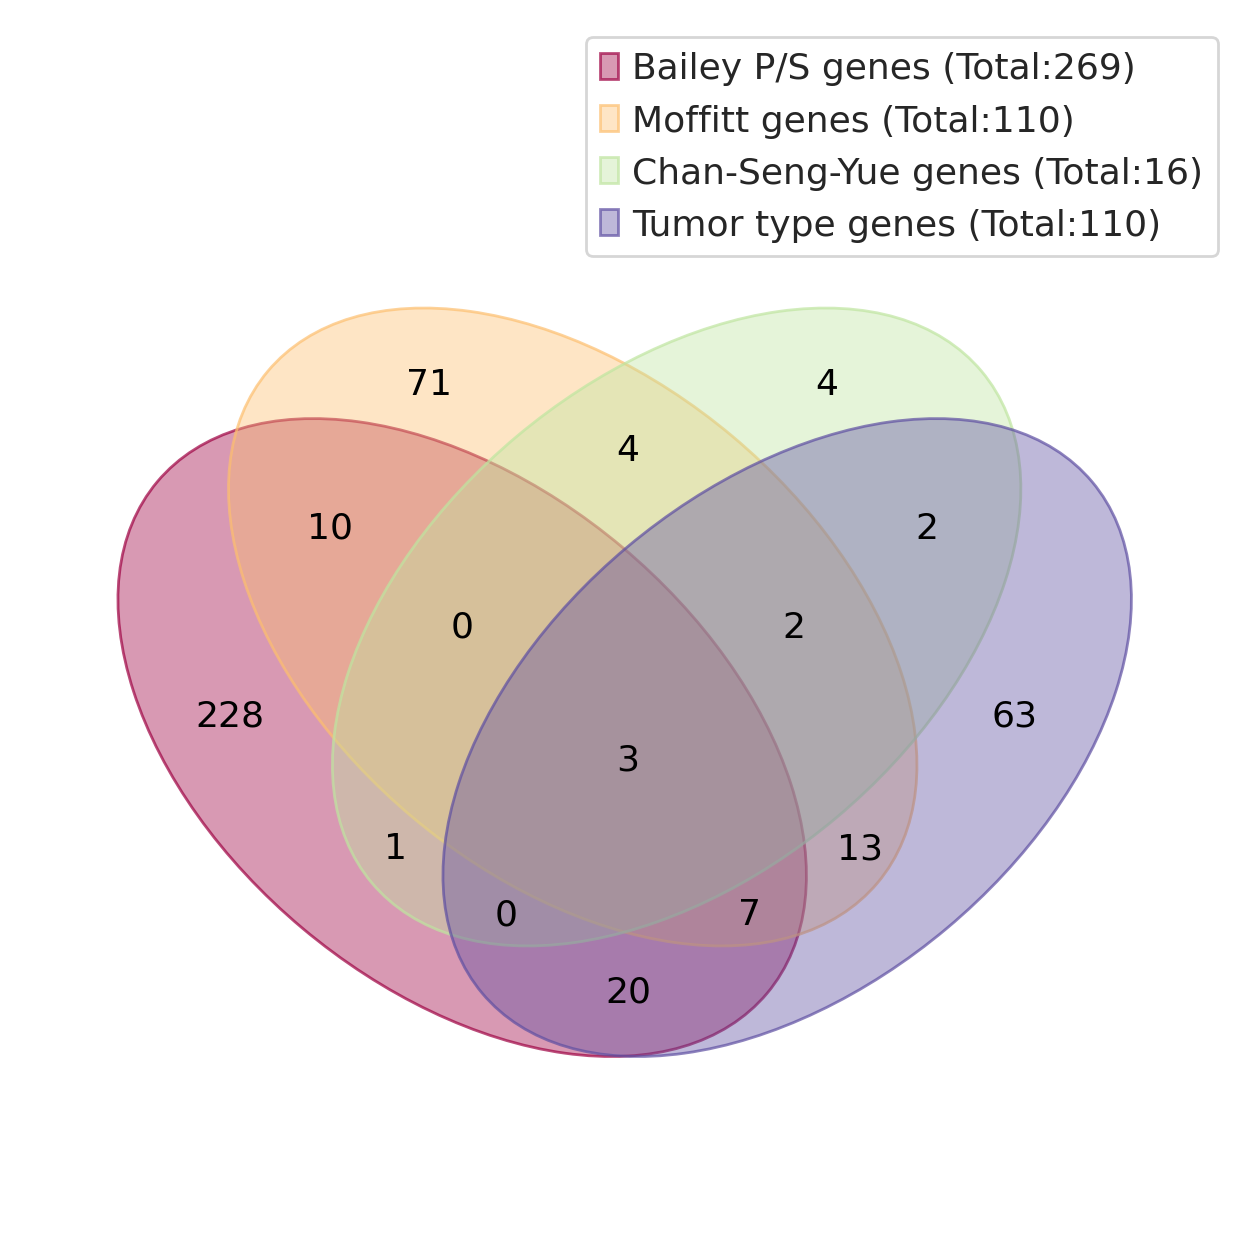

In [715]:
from venn import venn
musicians = {
    "Members of The Beatles": {"Paul McCartney", "John Lennon", "George Harrison", "Ringo Starr"},
    "Guitarists": {"John Lennon", "George Harrison", "Jimi Hendrix", "Eric Clapton", "Carlos Santana"},
    "Played at Woodstock": {"Jimi Hendrix", "Carlos Santana", "Keith Moon"}
}

venn_dict = dict()
venn_dict['Bailey P/S genes (Total:269)'] = set(Bailey_PS_genes)
venn_dict['Moffitt genes (Total:110)'] = set(Moffitt_genes)
venn_dict['Chan-Seng-Yue genes (Total:16)'] = set(chan_geneset)
venn_dict['Tumor type genes (Total:110)'] = set(tumor_features)
venn(venn_dict, cmap='Spectral', figsize=(15, 8))

In [666]:
?venn

# '################################################################'

19987
18077
15420


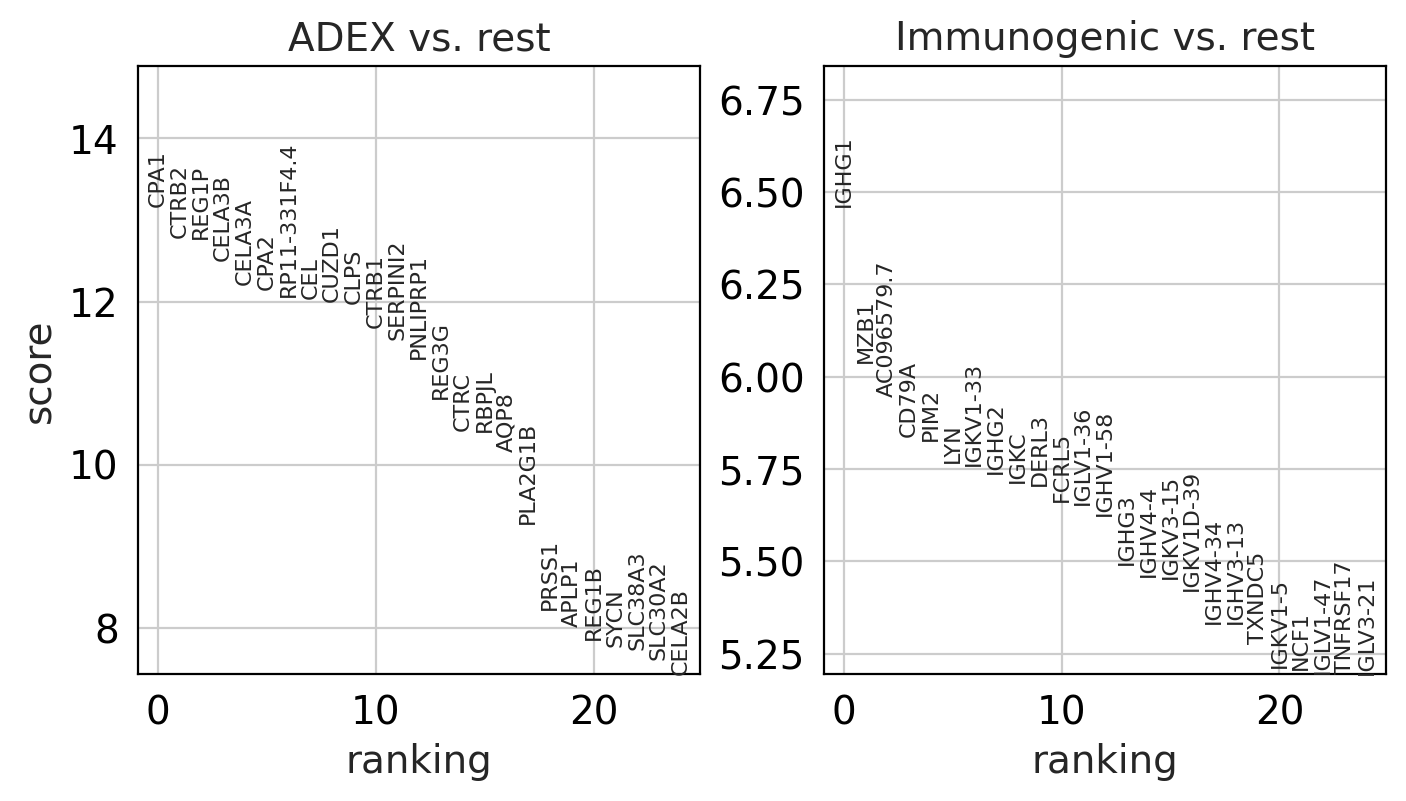

logfoldchanges         pvals     pvals_adj     scores
CPA1          16.333231  2.165615e-15  1.977092e-11  13.161767
CTRB2               NaN  2.187412e-15  1.977092e-11  12.776464
CELA3B              NaN  5.732418e-15  2.653062e-11  12.493658
REG1P               NaN  5.870581e-15  2.653062e-11  12.771474
CELA3A              NaN  8.568089e-15  3.097707e-11  12.207375
...                 ...           ...           ...        ...
NUP107         0.000125  9.993523e-01  9.995491e-01   0.000817
PANK3          0.000187  9.993832e-01  9.995491e-01   0.000781
ABHD15         0.000083  9.996065e-01  9.997100e-01   0.000497
FAM89B        -0.000080  9.996547e-01  9.997100e-01  -0.000436
TRAPPC1       -0.000026  9.998747e-01  9.998747e-01  -0.000158

[18077 rows x 4 columns]

In [90]:
SNU_adata = sc.read_h5ad('SNU_AnnDataForm_20220519.h5ad')
SNU_adata.obs['Dataset'] = 'SNU'
SNU_genes = list(SNU_adata.to_df().columns)
print(len(SNU_genes))
sc.pp.log1p(SNU_adata)

Bailey_adata = sc.read_h5ad('Bailey_TPM_norm_AnnDataForm.h5ad')
Bailey_adata.obs['Dataset'] = 'Bailey'
Bailey_genes = list(Bailey_adata.to_df().columns)
print(len(Bailey_genes))

common_genes_all = list(set(SNU_genes)&set(Bailey_genes))
print(len(common_genes_all))

sc.settings.set_figure_params(dpi=100)
m = Bailey_adata.obs['Bailey-type'].isin(['ADEX', 'Immunogenic'])
Bailey_adata = Bailey_adata[m,:]
sc.tl.rank_genes_groups(Bailey_adata, 'Bailey-type', method='t-test')
sc.pl.rank_genes_groups(Bailey_adata, n_genes=25, sharey=False, ncols=2, wspace=0.5)

test_method = 't-test' # wilcoxon / t-test
target_group = 'Bailey-type'
groups = ['ADEX', 'Immunogenic']
test = groups[0]
control = groups[1]
sc.tl.rank_genes_groups(Bailey_adata, target_group, groups=[test], reference=control, method=test_method)
result = Bailey_adata.uns['rank_genes_groups']
df_deg = pd.DataFrame( index = result['names'][test] )
for key in ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']:
    df_deg[key] = result[key][test]
#df_wilcoxon.columns = ['logfoldchanges', 'wilcoxon-pvals', 'wilcoxon-pvals_adj', 'wilcoxon-scores']
df_deg = df_deg.sort_values(by='pvals')
df_deg
# threshold = 0.0001
# m = df_deg['pvals_adj'] < threshold
# df_deg = df_deg[m]
# total_unique = list(df_deg.index)
#print('total genes: {}'.format(len(total_unique)))



In [91]:
df_deg

logfoldchanges         pvals     pvals_adj     scores
CPA1          16.333231  2.165615e-15  1.977092e-11  13.161767
CTRB2               NaN  2.187412e-15  1.977092e-11  12.776464
CELA3B              NaN  5.732418e-15  2.653062e-11  12.493658
REG1P               NaN  5.870581e-15  2.653062e-11  12.771474
CELA3A              NaN  8.568089e-15  3.097707e-11  12.207375
...                 ...           ...           ...        ...
NUP107         0.000125  9.993523e-01  9.995491e-01   0.000817
PANK3          0.000187  9.993832e-01  9.995491e-01   0.000781
ABHD15         0.000083  9.996065e-01  9.997100e-01   0.000497
FAM89B        -0.000080  9.996547e-01  9.997100e-01  -0.000436
TRAPPC1       -0.000026  9.998747e-01  9.998747e-01  -0.000158

[18077 rows x 4 columns]

In [86]:
from venn import venn

19987
18077
15420


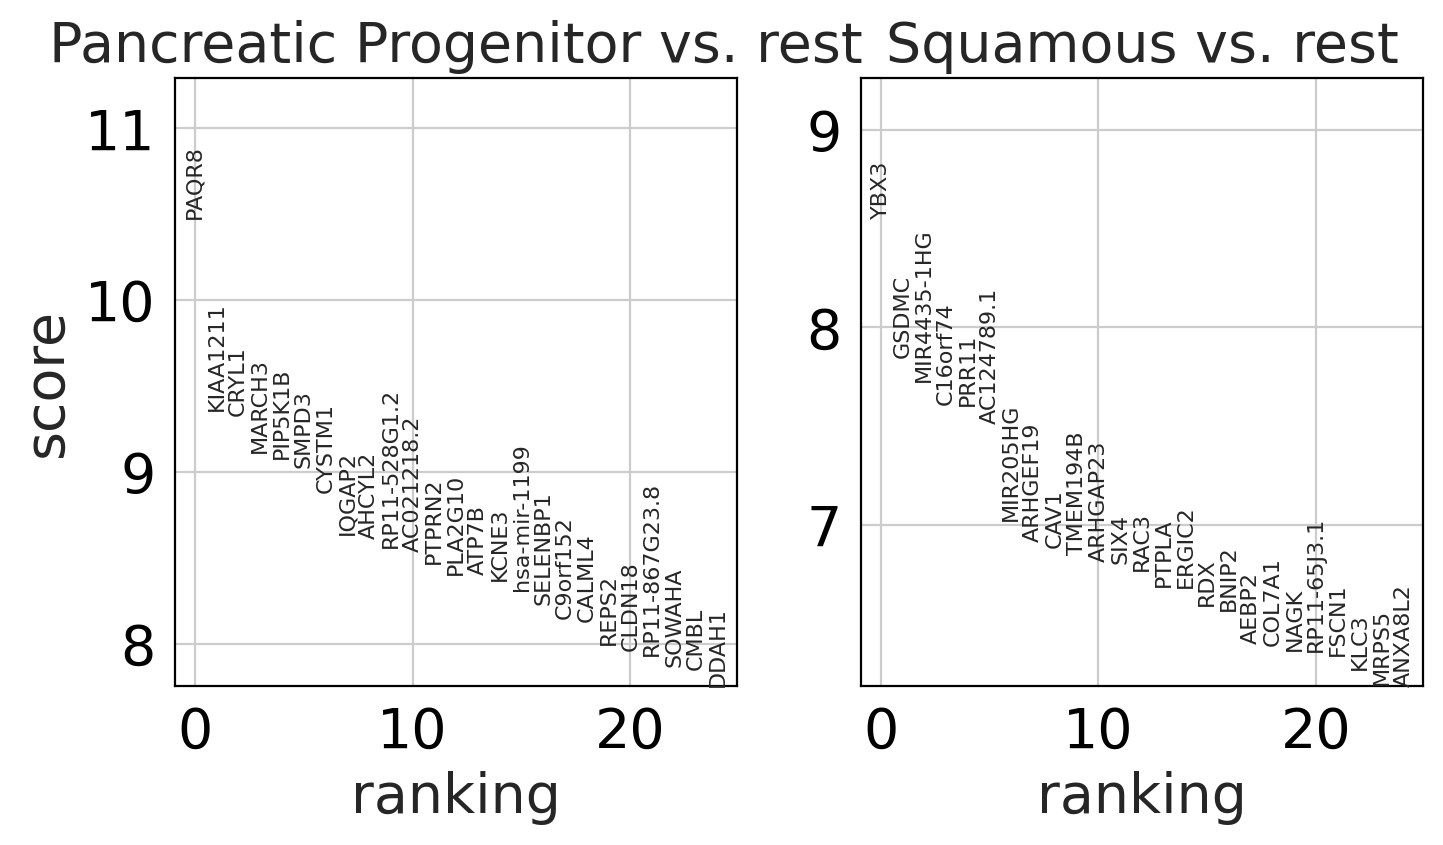

total genes: 1559


In [49]:
SNU_adata = sc.read_h5ad('SNU_AnnDataForm_20220519.h5ad')
SNU_adata.obs['Dataset'] = 'SNU'
SNU_genes = list(SNU_adata.to_df().columns)
print(len(SNU_genes))
sc.pp.log1p(SNU_adata)

Bailey_adata = sc.read_h5ad('Bailey_TPM_norm_AnnDataForm.h5ad')
Bailey_adata.obs['Dataset'] = 'Bailey'
Bailey_genes = list(Bailey_adata.to_df().columns)
print(len(Bailey_genes))

common_genes_all = list(set(SNU_genes)&set(Bailey_genes))
print(len(common_genes_all))

sc.settings.set_figure_params(dpi=100,fontsize=20)
m = Bailey_adata.obs['Bailey-type'].isin(['Pancreatic Progenitor', 'Squamous'])
Bailey_adata = Bailey_adata[m,:]
sc.tl.rank_genes_groups(Bailey_adata, 'Bailey-type', method='t-test')
sc.pl.rank_genes_groups(Bailey_adata, n_genes=25, sharey=False, ncols=2, wspace=0.5)

test_method = 't-test' # wilcoxon / t-test
target_group = 'Bailey-type'
groups = ['Pancreatic Progenitor', 'Squamous']
test = groups[0]
control = groups[1]
sc.tl.rank_genes_groups(Bailey_adata, target_group, groups=[test], reference=control, method=test_method)
result = Bailey_adata.uns['rank_genes_groups']
df_deg = pd.DataFrame( index = result['names'][test] )
for key in ['logfoldchanges', 'pvals', 'pvals_adj', 'scores']:
    df_deg[key] = result[key][test]
#df_wilcoxon.columns = ['logfoldchanges', 'wilcoxon-pvals', 'wilcoxon-pvals_adj', 'wilcoxon-scores']
df_deg = df_deg.sort_values(by='pvals')

threshold = 0.005
m = df_deg['pvals_adj'] < threshold
df_deg = df_deg[m]
total_unique = list(df_deg.index)
print('total genes: {}'.format(len(total_unique)))



In [39]:
df_deg

logfoldchanges         pvals     pvals_adj     scores
PAQR8                3.189636  5.270318e-14  9.527154e-10  10.472304
CRYL1                1.928444  9.131280e-13  8.253307e-09   9.327552
MARCH3               2.254044  2.866130e-12  1.621291e-08   9.107773
KIAA1211             2.812865  3.587522e-12  1.621291e-08   9.356732
PIP5K1B              4.099884  1.153925e-11  4.171902e-08   9.073210
...                       ...           ...           ...        ...
CTD-2196E14.9        0.713234  4.223971e-04  4.910400e-03   3.766819
ELF3                 1.887098  4.240482e-04  4.925693e-03   3.900581
ADSSL1              -1.650233  4.242576e-04  4.925693e-03  -3.826097
TFEB                 0.663446  4.251524e-04  4.932914e-03   3.764446
SLC37A4              0.761940  4.275052e-04  4.957031e-03   3.764776

[1559 rows x 4 columns]

In [40]:
moffitt_features = pd.read_csv('features.csv',index_col=0)
moffitt_features['diff_'] = moffitt_features['F6_BasalLike']-moffitt_features['F8_Classical']
moffitt_features['diff_abs'] = abs(moffitt_features['F6_BasalLike']-moffitt_features['F8_Classical'])
moffitt_features = moffitt_features.sort_values(by='diff_',ascending=False)
moffitt_features = moffitt_features.loc[:,['F6_BasalLike','F8_Classical','diff_','diff_abs']]
moffitt_features

F6_BasalLike  F8_Classical   diff_  diff_abs
symbol                                              
S100A2        5.2310        1.2927  3.9383    3.9383
KRT6A         3.5343        0.1442  3.3901    3.3901
CST6          4.1886        0.8567  3.3319    3.3319
GPR87         3.3626        0.0786  3.2840    3.2840
SCEL          3.7537        0.5748  3.1789    3.1789
...              ...           ...     ...       ...
CTSE          1.5018        5.9462 -4.4444    4.4444
TM4SF4        0.3483        4.9021 -4.5538    4.5538
TSPAN8        1.6123        6.3160 -4.7037    4.7037
LGALS4        0.8129        5.9280 -5.1151    5.1151
REG4          0.3717        5.5144 -5.1427    5.1427

[19749 rows x 4 columns]

In [41]:
Tumor_feature = pd.read_csv('/mnt/HDD1/Work_Paper/RNAseq_Analysis/DEG_Res/DEG_Tumor Subtype_t-test.csv',index_col=0)
m = Tumor_feature['pvals_adj'] < threshold
Tumor_feature = Tumor_feature[m]
Tumor_feature

logfoldchanges         pvals     pvals_adj     scores
LRRC66            3.135379  5.111113e-22  1.021558e-17  12.830123
NR1I2             3.984011  1.899645e-19  1.357638e-15  11.608025
AC106876.2        3.561894  3.190124e-19  1.357638e-15  11.699298
APOBEC1           3.893730  3.373332e-19  1.357638e-15  11.456743
FMO5              2.229024  3.396304e-19  1.357638e-15  11.631742
...                    ...           ...           ...        ...
NR1H4             1.528706  8.152652e-04  4.980045e-03   3.463600
SEPT2             0.496518  8.156848e-04  4.981085e-03   3.547022
SMAD5             0.523879  8.163516e-04  4.983634e-03   3.531376
TMED7             0.599052  8.170575e-04  4.986421e-03   3.537196
PLA2G4A           0.832120  8.175460e-04  4.987879e-03   3.464518

[3276 rows x 4 columns]

In [42]:
common_genes = list(set(df_deg.index)&set(moffitt_features.index)&set(Tumor_feature.index))
print(len(common_genes))
bailey_ = df_deg.loc[common_genes,:]
moffitt_ = moffitt_features.loc[common_genes,:]
tumor_ = Tumor_feature.loc[common_genes,:]

729


In [43]:
m = bailey_['scores'] > 0
PancreaticProgenitor_genes = set(bailey_[m].index)
Squamous_genes = set(bailey_[~m].index)
m = moffitt_['diff_'] < 0
Classical_genes = set(moffitt_[m].index)
Basallike_genes = set(moffitt_[~m].index)
m = Tumor_feature['scores'] > 0
C1_genes = set(tumor_[m].index)
C2_genes = set(tumor_[~m].index)

<AxesSubplot:>

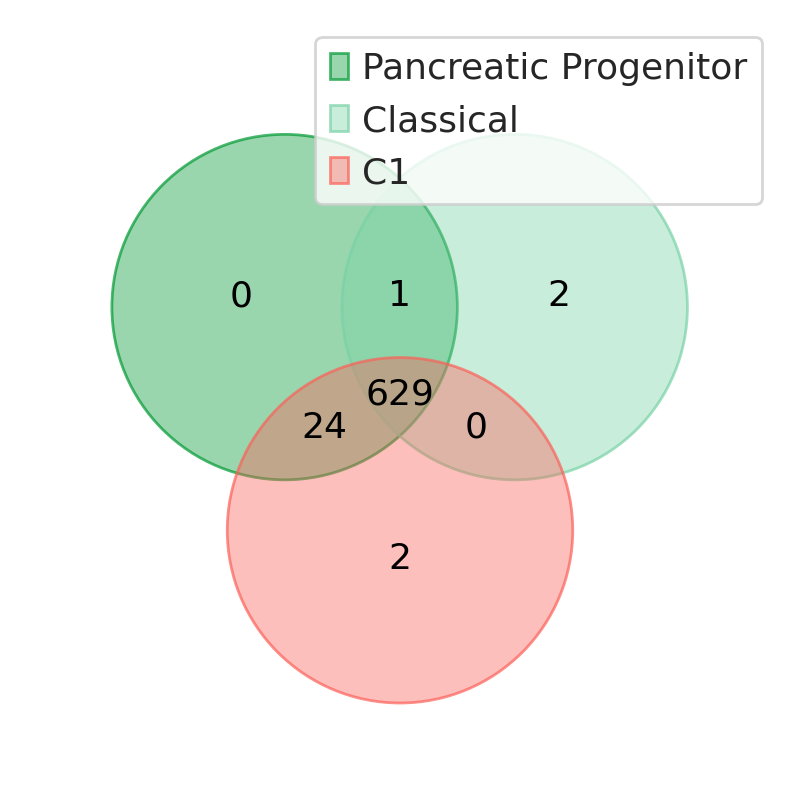

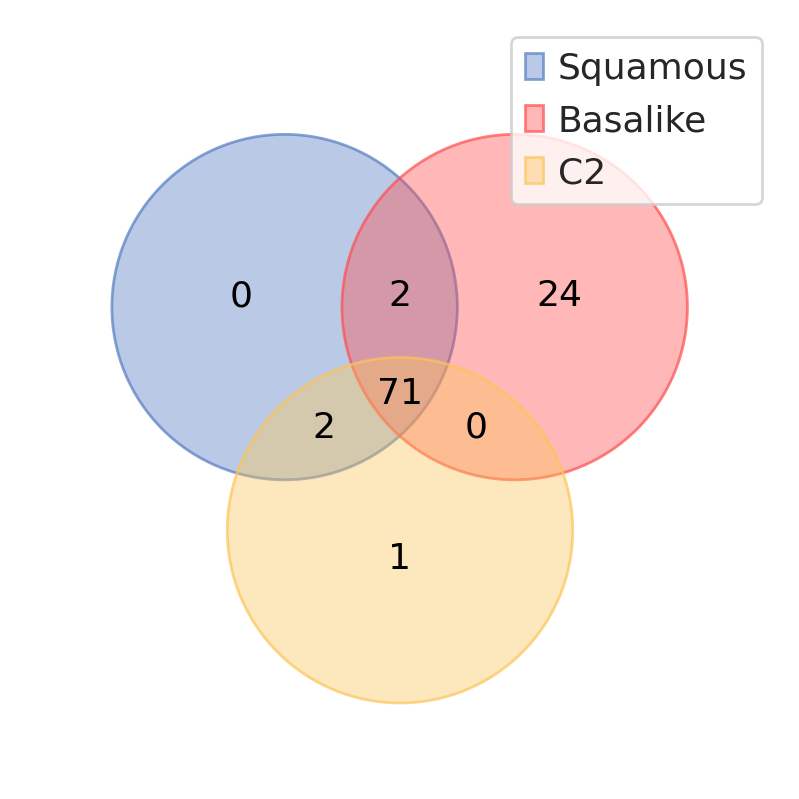

In [63]:
from venn import venn

d1 = dict()
d2 = dict()
d1['Pancreatic Progenitor'] = PancreaticProgenitor_genes
d1['Classical'] = Classical_genes
d1['C1'] = C1_genes

d2['Squamous'] = Squamous_genes
d2['Basalike'] = Basallike_genes
d2['C2'] = C2_genes

venn(d1, cmap=['#009933', '#79d2a6', '#fc6058'], figsize=(5, 5))

venn(d2, cmap=['#537cc2', '#ff4d4d', '#fcc558'], figsize=(5, 5))


In [714]:
mat=245
tot=mat+9+16

mat/tot * 100

90.74074074074075

<AxesSubplot:>

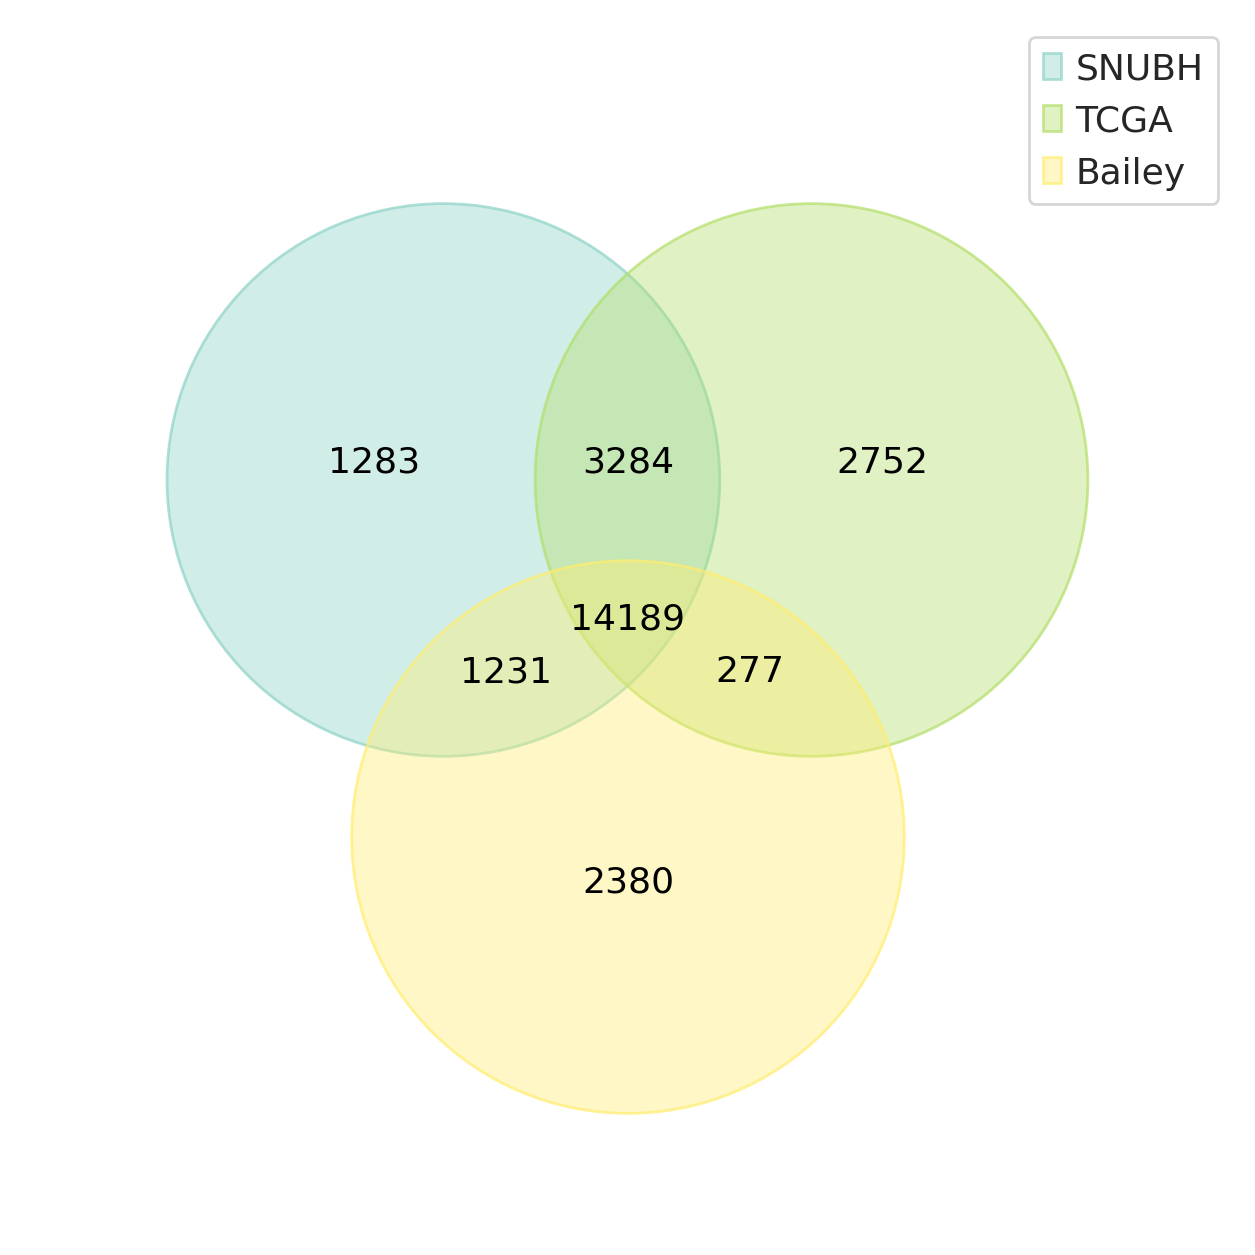

In [49]:
geneset_d = dict()

geneset_d['SNUBH'] = set(SNU_genes)
geneset_d['TCGA'] = set(TCGA_genes)
geneset_d['Bailey'] = set(Bailey_genes)
venn(geneset_d, cmap='Set3', figsize=(15, 8))

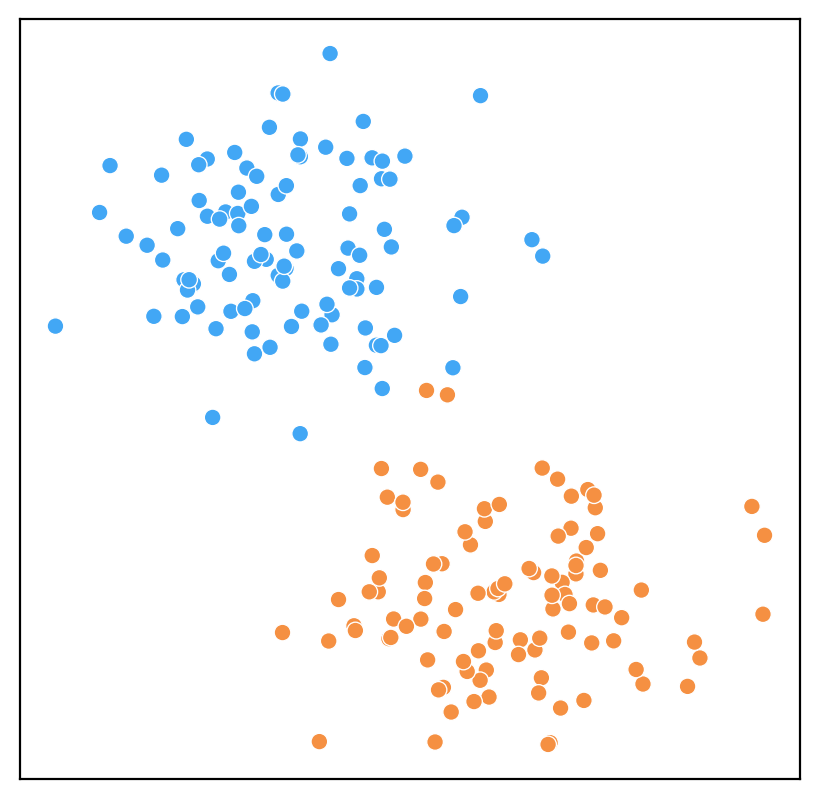

In [76]:
sc.settings.set_figure_params(dpi=100, figsize=(5,5), fontsize=10)

from sklearn.datasets import make_blobs
data, cluster = make_blobs(n_samples=200, 
                                centers=2,
                                random_state=134, 
                                cluster_std=1.80)
data_df = pd.DataFrame(data)
data_df.columns=['Comp1','Comp2']
data_df['cluster'] = cluster
color_map= {0:'#f59042',1:'#42a7f5'}
data_df['color'] = data_df.cluster.map(color_map)
ax = sns.scatterplot(x='Comp1',y='Comp2',hue='cluster',data=data_df, palette=color_map,legend = False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

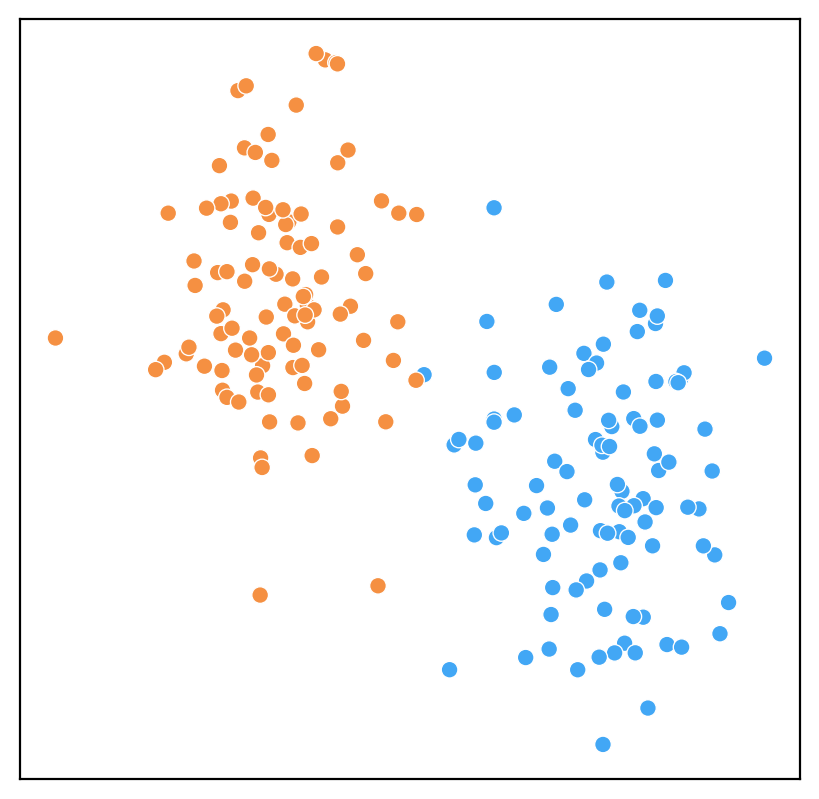

In [80]:
sc.settings.set_figure_params(dpi=100, figsize=(5,5), fontsize=10)

from sklearn.datasets import make_blobs
data, cluster = make_blobs(n_samples=200, 
                                centers=2,
                                random_state=249, 
                                cluster_std=1.9)
data_df = pd.DataFrame(data)
data_df.columns=['Comp1','Comp2']
data_df['cluster'] = cluster
data_df['color'] = data_df.cluster.map(color_map)
ax = sns.scatterplot(x='Comp1',y='Comp2',hue='cluster',data=data_df, palette=color_map,legend = False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

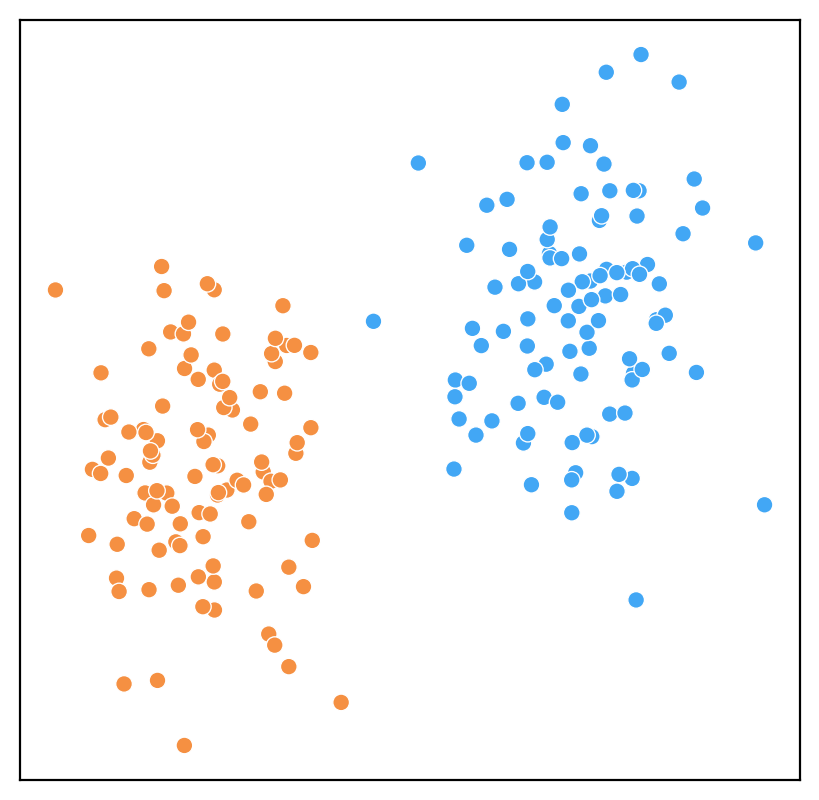

In [82]:
sc.settings.set_figure_params(dpi=100, figsize=(5,5), fontsize=10)

from sklearn.datasets import make_blobs
data, cluster = make_blobs(n_samples=200, 
                                centers=2,
                                random_state=108, 
                                cluster_std=1.3)
data_df = pd.DataFrame(data)
data_df.columns=['Comp1','Comp2']
data_df['cluster'] = cluster
data_df['color'] = data_df.cluster.map(color_map)
ax = sns.scatterplot(x='Comp1',y='Comp2',hue='cluster',data=data_df, palette=color_map,legend = False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [38]:
data_df

Comp1     Comp2  cluster
0    0.618482  4.272247        0
1    2.165623  0.666370        1
2    0.736601  4.525821        0
3    2.015903  4.714488        0
4    2.631684  1.695101        1
..        ...       ...      ...
495 -0.396902  4.454678        0
496  2.592424  1.722642        1
497  0.175715  3.495757        0
498  1.846797  0.548903        1
499  0.563568  3.575341        0

[500 rows x 3 columns]